In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : ['TFC','UHDRSmotor','Digit_symbol_correct','stroop_word'],
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_TFC_UHDRSmotor_Digit_symbol_correct_stroop_word_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4014968, 832)
(4014968, 8)
validation
(782336, 832)
(782336, 8)
test
(325224, 832)
(325224, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 832)]             0         


 dense (Dense)               (None, 1024)              852992    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1543048 (5.89 MB)


Trainable params: 1543048 (5.89 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/402 [..............................] - ETA: 12:21 - loss: 2.3332 - STD: 0.0788 - MAE: 0.2192

  3/402 [..............................] - ETA: 10s - loss: 2.2034 - STD: 0.0576 - MAE: 0.2178  

  5/402 [..............................] - ETA: 10s - loss: 2.1491 - STD: 0.0551 - MAE: 0.2170

  7/402 [..............................] - ETA: 10s - loss: 2.1297 - STD: 0.0522 - MAE: 0.2169

  9/402 [..............................] - ETA: 10s - loss: 2.1217 - STD: 0.0506 - MAE: 0.2170

 11/402 [..............................] - ETA: 10s - loss: 2.1124 - STD: 0.0486 - MAE: 0.2169

 13/402 [..............................] - ETA: 10s - loss: 2.1043 - STD: 0.0469 - MAE: 0.2169

 15/402 [>.............................] - ETA: 10s - loss: 2.0977 - STD: 0.0455 - MAE: 0.2168

 17/402 [>.............................] - ETA: 10s - loss: 2.0925 - STD: 0.0440 - MAE: 0.2168

 19/402 [>.............................] - ETA: 10s - loss: 2.0887 - STD: 0.0427 - MAE: 0.2168

 21/402 [>.............................] - ETA: 10s - loss: 2.0855 - STD: 0.0417 - MAE: 0.2168

 23/402 [>.............................] - ETA: 9s - loss: 2.0827 - STD: 0.0410 - MAE: 0.2168 

 25/402 [>.............................] - ETA: 9s - loss: 2.0800 - STD: 0.0404 - MAE: 0.2168

 28/402 [=>............................] - ETA: 9s - loss: 2.0762 - STD: 0.0395 - MAE: 0.2167

 31/402 [=>............................] - ETA: 9s - loss: 2.0727 - STD: 0.0386 - MAE: 0.2167

 33/402 [=>............................] - ETA: 9s - loss: 2.0704 - STD: 0.0381 - MAE: 0.2167

 35/402 [=>............................] - ETA: 9s - loss: 2.0680 - STD: 0.0379 - MAE: 0.2166

 37/402 [=>............................] - ETA: 9s - loss: 2.0648 - STD: 0.0377 - MAE: 0.2165

 39/402 [=>............................] - ETA: 9s - loss: 2.0617 - STD: 0.0377 - MAE: 0.2164

 41/402 [==>...........................] - ETA: 9s - loss: 2.0581 - STD: 0.0377 - MAE: 0.2163

 43/402 [==>...........................] - ETA: 9s - loss: 2.0542 - STD: 0.0380 - MAE: 0.2161

 45/402 [==>...........................] - ETA: 9s - loss: 2.0497 - STD: 0.0385 - MAE: 0.2159

 47/402 [==>...........................] - ETA: 9s - loss: 2.0448 - STD: 0.0391 - MAE: 0.2157

 49/402 [==>...........................] - ETA: 9s - loss: 2.0395 - STD: 0.0399 - MAE: 0.2155

 51/402 [==>...........................] - ETA: 9s - loss: 2.0337 - STD: 0.0407 - MAE: 0.2152

 53/402 [==>...........................] - ETA: 9s - loss: 2.0277 - STD: 0.0416 - MAE: 0.2149

 55/402 [===>..........................] - ETA: 9s - loss: 2.0215 - STD: 0.0426 - MAE: 0.2146

 57/402 [===>..........................] - ETA: 9s - loss: 2.0151 - STD: 0.0437 - MAE: 0.2143

 59/402 [===>..........................] - ETA: 8s - loss: 2.0086 - STD: 0.0448 - MAE: 0.2140

 61/402 [===>..........................] - ETA: 8s - loss: 2.0021 - STD: 0.0460 - MAE: 0.2136

 63/402 [===>..........................] - ETA: 8s - loss: 1.9954 - STD: 0.0471 - MAE: 0.2133

 65/402 [===>..........................] - ETA: 8s - loss: 1.9888 - STD: 0.0481 - MAE: 0.2130

 67/402 [====>.........................] - ETA: 8s - loss: 1.9820 - STD: 0.0492 - MAE: 0.2127

 69/402 [====>.........................] - ETA: 8s - loss: 1.9752 - STD: 0.0502 - MAE: 0.2123

 71/402 [====>.........................] - ETA: 8s - loss: 1.9679 - STD: 0.0513 - MAE: 0.2120

 73/402 [====>.........................] - ETA: 8s - loss: 1.9603 - STD: 0.0524 - MAE: 0.2116

 75/402 [====>.........................] - ETA: 8s - loss: 1.9527 - STD: 0.0535 - MAE: 0.2112

 77/402 [====>.........................] - ETA: 8s - loss: 1.9446 - STD: 0.0546 - MAE: 0.2108

 79/402 [====>.........................] - ETA: 8s - loss: 1.9362 - STD: 0.0557 - MAE: 0.2103

 81/402 [=====>........................] - ETA: 8s - loss: 1.9275 - STD: 0.0570 - MAE: 0.2099

 83/402 [=====>........................] - ETA: 8s - loss: 1.9188 - STD: 0.0583 - MAE: 0.2094

 85/402 [=====>........................] - ETA: 8s - loss: 1.9099 - STD: 0.0597 - MAE: 0.2089

 87/402 [=====>........................] - ETA: 8s - loss: 1.9012 - STD: 0.0610 - MAE: 0.2083

 89/402 [=====>........................] - ETA: 8s - loss: 1.8924 - STD: 0.0624 - MAE: 0.2078

 91/402 [=====>........................] - ETA: 8s - loss: 1.8837 - STD: 0.0638 - MAE: 0.2073

 93/402 [=====>........................] - ETA: 8s - loss: 1.8753 - STD: 0.0651 - MAE: 0.2068

 95/402 [======>.......................] - ETA: 8s - loss: 1.8667 - STD: 0.0665 - MAE: 0.2062

 97/402 [======>.......................] - ETA: 8s - loss: 1.8584 - STD: 0.0678 - MAE: 0.2057

 99/402 [======>.......................] - ETA: 7s - loss: 1.8500 - STD: 0.0692 - MAE: 0.2052

101/402 [======>.......................] - ETA: 7s - loss: 1.8417 - STD: 0.0705 - MAE: 0.2046

103/402 [======>.......................] - ETA: 7s - loss: 1.8339 - STD: 0.0718 - MAE: 0.2041

106/402 [======>.......................] - ETA: 7s - loss: 1.8223 - STD: 0.0737 - MAE: 0.2033

108/402 [=======>......................] - ETA: 7s - loss: 1.8147 - STD: 0.0749 - MAE: 0.2028

110/402 [=======>......................] - ETA: 7s - loss: 1.8071 - STD: 0.0762 - MAE: 0.2023

112/402 [=======>......................] - ETA: 7s - loss: 1.7997 - STD: 0.0773 - MAE: 0.2018

114/402 [=======>......................] - ETA: 7s - loss: 1.7926 - STD: 0.0785 - MAE: 0.2013

116/402 [=======>......................] - ETA: 7s - loss: 1.7855 - STD: 0.0797 - MAE: 0.2008

118/402 [=======>......................] - ETA: 7s - loss: 1.7785 - STD: 0.0808 - MAE: 0.2004

120/402 [=======>......................] - ETA: 7s - loss: 1.7719 - STD: 0.0819 - MAE: 0.1999

122/402 [========>.....................] - ETA: 7s - loss: 1.7652 - STD: 0.0830 - MAE: 0.1994

124/402 [========>.....................] - ETA: 7s - loss: 1.7585 - STD: 0.0841 - MAE: 0.1989

126/402 [========>.....................] - ETA: 7s - loss: 1.7521 - STD: 0.0852 - MAE: 0.1985

128/402 [========>.....................] - ETA: 7s - loss: 1.7460 - STD: 0.0863 - MAE: 0.1980

130/402 [========>.....................] - ETA: 7s - loss: 1.7400 - STD: 0.0873 - MAE: 0.1976

132/402 [========>.....................] - ETA: 7s - loss: 1.7339 - STD: 0.0883 - MAE: 0.1971

134/402 [=========>....................] - ETA: 7s - loss: 1.7278 - STD: 0.0893 - MAE: 0.1967

136/402 [=========>....................] - ETA: 7s - loss: 1.7220 - STD: 0.0903 - MAE: 0.1962

138/402 [=========>....................] - ETA: 6s - loss: 1.7164 - STD: 0.0913 - MAE: 0.1958

140/402 [=========>....................] - ETA: 6s - loss: 1.7108 - STD: 0.0923 - MAE: 0.1954

142/402 [=========>....................] - ETA: 6s - loss: 1.7054 - STD: 0.0932 - MAE: 0.1949

144/402 [=========>....................] - ETA: 6s - loss: 1.7002 - STD: 0.0942 - MAE: 0.1945

147/402 [=========>....................] - ETA: 6s - loss: 1.6925 - STD: 0.0955 - MAE: 0.1939

150/402 [==========>...................] - ETA: 6s - loss: 1.6851 - STD: 0.0968 - MAE: 0.1933

152/402 [==========>...................] - ETA: 6s - loss: 1.6802 - STD: 0.0976 - MAE: 0.1930

154/402 [==========>...................] - ETA: 6s - loss: 1.6755 - STD: 0.0985 - MAE: 0.1926

156/402 [==========>...................] - ETA: 6s - loss: 1.6709 - STD: 0.0993 - MAE: 0.1923

158/402 [==========>...................] - ETA: 6s - loss: 1.6665 - STD: 0.1001 - MAE: 0.1919

160/402 [==========>...................] - ETA: 6s - loss: 1.6620 - STD: 0.1009 - MAE: 0.1915

162/402 [===========>..................] - ETA: 6s - loss: 1.6577 - STD: 0.1016 - MAE: 0.1912

164/402 [===========>..................] - ETA: 6s - loss: 1.6535 - STD: 0.1024 - MAE: 0.1909

166/402 [===========>..................] - ETA: 6s - loss: 1.6492 - STD: 0.1031 - MAE: 0.1905

168/402 [===========>..................] - ETA: 6s - loss: 1.6452 - STD: 0.1039 - MAE: 0.1902

170/402 [===========>..................] - ETA: 6s - loss: 1.6411 - STD: 0.1046 - MAE: 0.1899

172/402 [===========>..................] - ETA: 6s - loss: 1.6371 - STD: 0.1053 - MAE: 0.1896

174/402 [===========>..................] - ETA: 5s - loss: 1.6332 - STD: 0.1060 - MAE: 0.1892

176/402 [============>.................] - ETA: 5s - loss: 1.6295 - STD: 0.1066 - MAE: 0.1889

179/402 [============>.................] - ETA: 5s - loss: 1.6239 - STD: 0.1076 - MAE: 0.1885

182/402 [============>.................] - ETA: 5s - loss: 1.6184 - STD: 0.1086 - MAE: 0.1881

184/402 [============>.................] - ETA: 5s - loss: 1.6148 - STD: 0.1092 - MAE: 0.1878

186/402 [============>.................] - ETA: 5s - loss: 1.6114 - STD: 0.1098 - MAE: 0.1875

188/402 [=============>................] - ETA: 5s - loss: 1.6079 - STD: 0.1105 - MAE: 0.1872

190/402 [=============>................] - ETA: 5s - loss: 1.6046 - STD: 0.1111 - MAE: 0.1869

193/402 [=============>................] - ETA: 5s - loss: 1.5997 - STD: 0.1119 - MAE: 0.1865

196/402 [=============>................] - ETA: 5s - loss: 1.5948 - STD: 0.1128 - MAE: 0.1861

197/402 [=============>................] - ETA: 6s - loss: 1.5941 - STD: 0.1131 - MAE: 0.1860

199/402 [=============>................] - ETA: 6s - loss: 1.5909 - STD: 0.1136 - MAE: 0.1858

201/402 [==============>...............] - ETA: 6s - loss: 1.5879 - STD: 0.1142 - MAE: 0.1855

203/402 [==============>...............] - ETA: 6s - loss: 1.5848 - STD: 0.1147 - MAE: 0.1853

205/402 [==============>...............] - ETA: 6s - loss: 1.5818 - STD: 0.1152 - MAE: 0.1850

207/402 [==============>...............] - ETA: 6s - loss: 1.5790 - STD: 0.1157 - MAE: 0.1848

209/402 [==============>...............] - ETA: 5s - loss: 1.5760 - STD: 0.1163 - MAE: 0.1845

212/402 [==============>...............] - ETA: 5s - loss: 1.5718 - STD: 0.1170 - MAE: 0.1842

215/402 [===============>..............] - ETA: 5s - loss: 1.5677 - STD: 0.1178 - MAE: 0.1838

217/402 [===============>..............] - ETA: 5s - loss: 1.5650 - STD: 0.1182 - MAE: 0.1836

219/402 [===============>..............] - ETA: 5s - loss: 1.5621 - STD: 0.1187 - MAE: 0.1834

221/402 [===============>..............] - ETA: 5s - loss: 1.5595 - STD: 0.1192 - MAE: 0.1832

223/402 [===============>..............] - ETA: 5s - loss: 1.5569 - STD: 0.1196 - MAE: 0.1830

225/402 [===============>..............] - ETA: 5s - loss: 1.5543 - STD: 0.1201 - MAE: 0.1828

227/402 [===============>..............] - ETA: 5s - loss: 1.5518 - STD: 0.1205 - MAE: 0.1825

229/402 [================>.............] - ETA: 5s - loss: 1.5492 - STD: 0.1210 - MAE: 0.1823

232/402 [================>.............] - ETA: 5s - loss: 1.5455 - STD: 0.1216 - MAE: 0.1820

234/402 [================>.............] - ETA: 5s - loss: 1.5429 - STD: 0.1221 - MAE: 0.1818

236/402 [================>.............] - ETA: 5s - loss: 1.5405 - STD: 0.1225 - MAE: 0.1816

238/402 [================>.............] - ETA: 4s - loss: 1.5381 - STD: 0.1229 - MAE: 0.1814

241/402 [================>.............] - ETA: 4s - loss: 1.5346 - STD: 0.1235 - MAE: 0.1811

243/402 [=================>............] - ETA: 4s - loss: 1.5322 - STD: 0.1240 - MAE: 0.1809

245/402 [=================>............] - ETA: 4s - loss: 1.5300 - STD: 0.1243 - MAE: 0.1807

247/402 [=================>............] - ETA: 4s - loss: 1.5279 - STD: 0.1247 - MAE: 0.1805

249/402 [=================>............] - ETA: 4s - loss: 1.5257 - STD: 0.1251 - MAE: 0.1804

252/402 [=================>............] - ETA: 4s - loss: 1.5226 - STD: 0.1257 - MAE: 0.1801

255/402 [==================>...........] - ETA: 4s - loss: 1.5193 - STD: 0.1262 - MAE: 0.1798

258/402 [==================>...........] - ETA: 4s - loss: 1.5160 - STD: 0.1268 - MAE: 0.1796

260/402 [==================>...........] - ETA: 4s - loss: 1.5140 - STD: 0.1272 - MAE: 0.1794

262/402 [==================>...........] - ETA: 4s - loss: 1.5119 - STD: 0.1275 - MAE: 0.1792

264/402 [==================>...........] - ETA: 4s - loss: 1.5098 - STD: 0.1279 - MAE: 0.1790

266/402 [==================>...........] - ETA: 4s - loss: 1.5077 - STD: 0.1283 - MAE: 0.1788

269/402 [===================>..........] - ETA: 3s - loss: 1.5047 - STD: 0.1288 - MAE: 0.1786

272/402 [===================>..........] - ETA: 3s - loss: 1.5018 - STD: 0.1293 - MAE: 0.1783

274/402 [===================>..........] - ETA: 3s - loss: 1.4998 - STD: 0.1296 - MAE: 0.1782

277/402 [===================>..........] - ETA: 3s - loss: 1.4970 - STD: 0.1301 - MAE: 0.1779

279/402 [===================>..........] - ETA: 3s - loss: 1.4952 - STD: 0.1304 - MAE: 0.1778

281/402 [===================>..........] - ETA: 3s - loss: 1.4934 - STD: 0.1308 - MAE: 0.1776

283/402 [====================>.........] - ETA: 3s - loss: 1.4916 - STD: 0.1311 - MAE: 0.1775

285/402 [====================>.........] - ETA: 3s - loss: 1.4898 - STD: 0.1314 - MAE: 0.1773

287/402 [====================>.........] - ETA: 3s - loss: 1.4881 - STD: 0.1317 - MAE: 0.1772

290/402 [====================>.........] - ETA: 3s - loss: 1.4853 - STD: 0.1322 - MAE: 0.1769

292/402 [====================>.........] - ETA: 3s - loss: 1.4836 - STD: 0.1325 - MAE: 0.1768

294/402 [====================>.........] - ETA: 3s - loss: 1.4818 - STD: 0.1328 - MAE: 0.1766

296/402 [=====================>........] - ETA: 3s - loss: 1.4800 - STD: 0.1331 - MAE: 0.1765

298/402 [=====================>........] - ETA: 3s - loss: 1.4782 - STD: 0.1334 - MAE: 0.1763

300/402 [=====================>........] - ETA: 2s - loss: 1.4765 - STD: 0.1337 - MAE: 0.1762

302/402 [=====================>........] - ETA: 2s - loss: 1.4749 - STD: 0.1339 - MAE: 0.1761

304/402 [=====================>........] - ETA: 2s - loss: 1.4732 - STD: 0.1342 - MAE: 0.1759

306/402 [=====================>........] - ETA: 2s - loss: 1.4716 - STD: 0.1345 - MAE: 0.1758

308/402 [=====================>........] - ETA: 2s - loss: 1.4701 - STD: 0.1348 - MAE: 0.1756

311/402 [======================>.......] - ETA: 2s - loss: 1.4677 - STD: 0.1352 - MAE: 0.1754

313/402 [======================>.......] - ETA: 2s - loss: 1.4660 - STD: 0.1355 - MAE: 0.1753

315/402 [======================>.......] - ETA: 2s - loss: 1.4644 - STD: 0.1358 - MAE: 0.1752

317/402 [======================>.......] - ETA: 2s - loss: 1.4628 - STD: 0.1360 - MAE: 0.1750

319/402 [======================>.......] - ETA: 2s - loss: 1.4613 - STD: 0.1363 - MAE: 0.1749

321/402 [======================>.......] - ETA: 2s - loss: 1.4597 - STD: 0.1366 - MAE: 0.1747

323/402 [=======================>......] - ETA: 2s - loss: 1.4581 - STD: 0.1368 - MAE: 0.1746

325/402 [=======================>......] - ETA: 2s - loss: 1.4565 - STD: 0.1371 - MAE: 0.1745

327/402 [=======================>......] - ETA: 2s - loss: 1.4550 - STD: 0.1374 - MAE: 0.1743

329/402 [=======================>......] - ETA: 2s - loss: 1.4535 - STD: 0.1376 - MAE: 0.1742

332/402 [=======================>......] - ETA: 2s - loss: 1.4513 - STD: 0.1380 - MAE: 0.1740

334/402 [=======================>......] - ETA: 1s - loss: 1.4497 - STD: 0.1382 - MAE: 0.1739

336/402 [========================>.....] - ETA: 1s - loss: 1.4482 - STD: 0.1385 - MAE: 0.1738

339/402 [========================>.....] - ETA: 1s - loss: 1.4460 - STD: 0.1389 - MAE: 0.1736

341/402 [========================>.....] - ETA: 1s - loss: 1.4447 - STD: 0.1391 - MAE: 0.1734

343/402 [========================>.....] - ETA: 1s - loss: 1.4433 - STD: 0.1394 - MAE: 0.1733

345/402 [========================>.....] - ETA: 1s - loss: 1.4419 - STD: 0.1396 - MAE: 0.1732

347/402 [========================>.....] - ETA: 1s - loss: 1.4407 - STD: 0.1398 - MAE: 0.1731

349/402 [=========================>....] - ETA: 1s - loss: 1.4393 - STD: 0.1401 - MAE: 0.1730

352/402 [=========================>....] - ETA: 1s - loss: 1.4373 - STD: 0.1404 - MAE: 0.1728

355/402 [=========================>....] - ETA: 1s - loss: 1.4353 - STD: 0.1408 - MAE: 0.1726

358/402 [=========================>....] - ETA: 1s - loss: 1.4333 - STD: 0.1411 - MAE: 0.1724

360/402 [=========================>....] - ETA: 1s - loss: 1.4320 - STD: 0.1413 - MAE: 0.1723

362/402 [==========================>...] - ETA: 1s - loss: 1.4306 - STD: 0.1415 - MAE: 0.1722

364/402 [==========================>...] - ETA: 1s - loss: 1.4292 - STD: 0.1418 - MAE: 0.1721

366/402 [==========================>...] - ETA: 1s - loss: 1.4279 - STD: 0.1420 - MAE: 0.1720

369/402 [==========================>...] - ETA: 0s - loss: 1.4259 - STD: 0.1423 - MAE: 0.1718

371/402 [==========================>...] - ETA: 0s - loss: 1.4247 - STD: 0.1425 - MAE: 0.1717

373/402 [==========================>...] - ETA: 0s - loss: 1.4234 - STD: 0.1428 - MAE: 0.1716

375/402 [==========================>...] - ETA: 0s - loss: 1.4222 - STD: 0.1430 - MAE: 0.1715

377/402 [===========================>..] - ETA: 0s - loss: 1.4210 - STD: 0.1432 - MAE: 0.1713

380/402 [===========================>..] - ETA: 0s - loss: 1.4192 - STD: 0.1435 - MAE: 0.1712

382/402 [===========================>..] - ETA: 0s - loss: 1.4181 - STD: 0.1437 - MAE: 0.1711

384/402 [===========================>..] - ETA: 0s - loss: 1.4169 - STD: 0.1439 - MAE: 0.1710

386/402 [===========================>..] - ETA: 0s - loss: 1.4157 - STD: 0.1441 - MAE: 0.1709

388/402 [===========================>..] - ETA: 0s - loss: 1.4145 - STD: 0.1443 - MAE: 0.1708

390/402 [============================>.] - ETA: 0s - loss: 1.4132 - STD: 0.1445 - MAE: 0.1706

392/402 [============================>.] - ETA: 0s - loss: 1.4121 - STD: 0.1447 - MAE: 0.1705

395/402 [============================>.] - ETA: 0s - loss: 1.4103 - STD: 0.1450 - MAE: 0.1704

397/402 [============================>.] - ETA: 0s - loss: 1.4090 - STD: 0.1452 - MAE: 0.1703

399/402 [============================>.] - ETA: 0s - loss: 1.4079 - STD: 0.1454 - MAE: 0.1702

401/402 [============================>.] - ETA: 0s - loss: 1.4067 - STD: 0.1456 - MAE: 0.1701

402/402 [==============================] - 15s 34ms/step - loss: 1.4061 - STD: 0.1457 - MAE: 0.1700 - val_loss: 1.2795 - val_STD: 0.1776 - val_MAE: 0.1562


Epoch 2/10000


  1/402 [..............................] - ETA: 25s - loss: 1.1746 - STD: 0.1830 - MAE: 0.1498

  3/402 [..............................] - ETA: 10s - loss: 1.1775 - STD: 0.1837 - MAE: 0.1498

  5/402 [..............................] - ETA: 10s - loss: 1.1728 - STD: 0.1842 - MAE: 0.1494

  7/402 [..............................] - ETA: 10s - loss: 1.1709 - STD: 0.1843 - MAE: 0.1492

  9/402 [..............................] - ETA: 10s - loss: 1.1691 - STD: 0.1844 - MAE: 0.1491

 11/402 [..............................] - ETA: 10s - loss: 1.1696 - STD: 0.1844 - MAE: 0.1491

 13/402 [..............................] - ETA: 10s - loss: 1.1695 - STD: 0.1846 - MAE: 0.1490

 15/402 [>.............................] - ETA: 10s - loss: 1.1669 - STD: 0.1848 - MAE: 0.1488

 17/402 [>.............................] - ETA: 10s - loss: 1.1670 - STD: 0.1850 - MAE: 0.1487

 19/402 [>.............................] - ETA: 9s - loss: 1.1710 - STD: 0.1853 - MAE: 0.1488 

 21/402 [>.............................] - ETA: 9s - loss: 1.1703 - STD: 0.1855 - MAE: 0.1487

 23/402 [>.............................] - ETA: 9s - loss: 1.1692 - STD: 0.1855 - MAE: 0.1486

 25/402 [>.............................] - ETA: 9s - loss: 1.1687 - STD: 0.1856 - MAE: 0.1486

 27/402 [=>............................] - ETA: 9s - loss: 1.1676 - STD: 0.1857 - MAE: 0.1485

 29/402 [=>............................] - ETA: 9s - loss: 1.1675 - STD: 0.1858 - MAE: 0.1485

 31/402 [=>............................] - ETA: 9s - loss: 1.1676 - STD: 0.1858 - MAE: 0.1485

 33/402 [=>............................] - ETA: 9s - loss: 1.1673 - STD: 0.1858 - MAE: 0.1485

 35/402 [=>............................] - ETA: 9s - loss: 1.1670 - STD: 0.1858 - MAE: 0.1484

 37/402 [=>............................] - ETA: 9s - loss: 1.1681 - STD: 0.1859 - MAE: 0.1484

 39/402 [=>............................] - ETA: 9s - loss: 1.1682 - STD: 0.1860 - MAE: 0.1484

 41/402 [==>...........................] - ETA: 9s - loss: 1.1675 - STD: 0.1860 - MAE: 0.1483

 43/402 [==>...........................] - ETA: 9s - loss: 1.1672 - STD: 0.1861 - MAE: 0.1483

 45/402 [==>...........................] - ETA: 9s - loss: 1.1669 - STD: 0.1860 - MAE: 0.1483

 47/402 [==>...........................] - ETA: 9s - loss: 1.1666 - STD: 0.1861 - MAE: 0.1483

 49/402 [==>...........................] - ETA: 9s - loss: 1.1660 - STD: 0.1861 - MAE: 0.1482

 51/402 [==>...........................] - ETA: 9s - loss: 1.1657 - STD: 0.1862 - MAE: 0.1482

 53/402 [==>...........................] - ETA: 9s - loss: 1.1656 - STD: 0.1862 - MAE: 0.1482

 55/402 [===>..........................] - ETA: 9s - loss: 1.1653 - STD: 0.1863 - MAE: 0.1481

 57/402 [===>..........................] - ETA: 9s - loss: 1.1647 - STD: 0.1863 - MAE: 0.1481

 59/402 [===>..........................] - ETA: 8s - loss: 1.1639 - STD: 0.1864 - MAE: 0.1480

 61/402 [===>..........................] - ETA: 8s - loss: 1.1637 - STD: 0.1864 - MAE: 0.1480

 63/402 [===>..........................] - ETA: 8s - loss: 1.1636 - STD: 0.1865 - MAE: 0.1479

 65/402 [===>..........................] - ETA: 8s - loss: 1.1630 - STD: 0.1866 - MAE: 0.1479

 67/402 [====>.........................] - ETA: 8s - loss: 1.1630 - STD: 0.1866 - MAE: 0.1479

 69/402 [====>.........................] - ETA: 8s - loss: 1.1629 - STD: 0.1866 - MAE: 0.1479

 71/402 [====>.........................] - ETA: 8s - loss: 1.1629 - STD: 0.1866 - MAE: 0.1479

 73/402 [====>.........................] - ETA: 8s - loss: 1.1631 - STD: 0.1867 - MAE: 0.1478

 75/402 [====>.........................] - ETA: 8s - loss: 1.1627 - STD: 0.1868 - MAE: 0.1478

 77/402 [====>.........................] - ETA: 8s - loss: 1.1625 - STD: 0.1869 - MAE: 0.1478

 79/402 [====>.........................] - ETA: 8s - loss: 1.1622 - STD: 0.1869 - MAE: 0.1478

 81/402 [=====>........................] - ETA: 8s - loss: 1.1621 - STD: 0.1869 - MAE: 0.1478

 84/402 [=====>........................] - ETA: 8s - loss: 1.1616 - STD: 0.1869 - MAE: 0.1477

 86/402 [=====>........................] - ETA: 8s - loss: 1.1615 - STD: 0.1869 - MAE: 0.1477

 88/402 [=====>........................] - ETA: 8s - loss: 1.1611 - STD: 0.1870 - MAE: 0.1477

 90/402 [=====>........................] - ETA: 8s - loss: 1.1608 - STD: 0.1870 - MAE: 0.1476

 92/402 [=====>........................] - ETA: 8s - loss: 1.1603 - STD: 0.1870 - MAE: 0.1476

 95/402 [======>.......................] - ETA: 8s - loss: 1.1600 - STD: 0.1871 - MAE: 0.1475

 97/402 [======>.......................] - ETA: 7s - loss: 1.1596 - STD: 0.1871 - MAE: 0.1475

 99/402 [======>.......................] - ETA: 7s - loss: 1.1593 - STD: 0.1872 - MAE: 0.1475

101/402 [======>.......................] - ETA: 7s - loss: 1.1591 - STD: 0.1872 - MAE: 0.1475

103/402 [======>.......................] - ETA: 7s - loss: 1.1587 - STD: 0.1873 - MAE: 0.1474

105/402 [======>.......................] - ETA: 7s - loss: 1.1583 - STD: 0.1873 - MAE: 0.1474

107/402 [======>.......................] - ETA: 7s - loss: 1.1581 - STD: 0.1874 - MAE: 0.1473

109/402 [=======>......................] - ETA: 7s - loss: 1.1579 - STD: 0.1874 - MAE: 0.1473

111/402 [=======>......................] - ETA: 7s - loss: 1.1575 - STD: 0.1874 - MAE: 0.1473

113/402 [=======>......................] - ETA: 7s - loss: 1.1571 - STD: 0.1875 - MAE: 0.1472

115/402 [=======>......................] - ETA: 7s - loss: 1.1569 - STD: 0.1875 - MAE: 0.1472

117/402 [=======>......................] - ETA: 7s - loss: 1.1564 - STD: 0.1876 - MAE: 0.1472

119/402 [=======>......................] - ETA: 7s - loss: 1.1560 - STD: 0.1876 - MAE: 0.1471

121/402 [========>.....................] - ETA: 7s - loss: 1.1555 - STD: 0.1877 - MAE: 0.1471

123/402 [========>.....................] - ETA: 7s - loss: 1.1549 - STD: 0.1878 - MAE: 0.1470

125/402 [========>.....................] - ETA: 7s - loss: 1.1544 - STD: 0.1878 - MAE: 0.1470

127/402 [========>.....................] - ETA: 7s - loss: 1.1540 - STD: 0.1879 - MAE: 0.1469

129/402 [========>.....................] - ETA: 7s - loss: 1.1537 - STD: 0.1879 - MAE: 0.1469

131/402 [========>.....................] - ETA: 7s - loss: 1.1536 - STD: 0.1880 - MAE: 0.1469

133/402 [========>.....................] - ETA: 7s - loss: 1.1534 - STD: 0.1880 - MAE: 0.1468

135/402 [=========>....................] - ETA: 6s - loss: 1.1529 - STD: 0.1881 - MAE: 0.1468

137/402 [=========>....................] - ETA: 6s - loss: 1.1528 - STD: 0.1881 - MAE: 0.1468

139/402 [=========>....................] - ETA: 6s - loss: 1.1525 - STD: 0.1882 - MAE: 0.1467

141/402 [=========>....................] - ETA: 6s - loss: 1.1522 - STD: 0.1883 - MAE: 0.1467

143/402 [=========>....................] - ETA: 6s - loss: 1.1525 - STD: 0.1883 - MAE: 0.1467

145/402 [=========>....................] - ETA: 6s - loss: 1.1523 - STD: 0.1884 - MAE: 0.1466

148/402 [==========>...................] - ETA: 6s - loss: 1.1523 - STD: 0.1885 - MAE: 0.1466

150/402 [==========>...................] - ETA: 6s - loss: 1.1521 - STD: 0.1885 - MAE: 0.1466

152/402 [==========>...................] - ETA: 6s - loss: 1.1517 - STD: 0.1886 - MAE: 0.1465

154/402 [==========>...................] - ETA: 6s - loss: 1.1515 - STD: 0.1886 - MAE: 0.1465

156/402 [==========>...................] - ETA: 6s - loss: 1.1512 - STD: 0.1887 - MAE: 0.1465

158/402 [==========>...................] - ETA: 6s - loss: 1.1509 - STD: 0.1887 - MAE: 0.1464

160/402 [==========>...................] - ETA: 6s - loss: 1.1507 - STD: 0.1888 - MAE: 0.1464

162/402 [===========>..................] - ETA: 6s - loss: 1.1503 - STD: 0.1888 - MAE: 0.1464

164/402 [===========>..................] - ETA: 6s - loss: 1.1501 - STD: 0.1888 - MAE: 0.1463

166/402 [===========>..................] - ETA: 6s - loss: 1.1499 - STD: 0.1889 - MAE: 0.1463

168/402 [===========>..................] - ETA: 6s - loss: 1.1495 - STD: 0.1889 - MAE: 0.1463

170/402 [===========>..................] - ETA: 6s - loss: 1.1492 - STD: 0.1890 - MAE: 0.1463

173/402 [===========>..................] - ETA: 5s - loss: 1.1487 - STD: 0.1890 - MAE: 0.1462

175/402 [============>.................] - ETA: 5s - loss: 1.1484 - STD: 0.1891 - MAE: 0.1462

178/402 [============>.................] - ETA: 5s - loss: 1.1479 - STD: 0.1891 - MAE: 0.1461

180/402 [============>.................] - ETA: 5s - loss: 1.1478 - STD: 0.1891 - MAE: 0.1461

182/402 [============>.................] - ETA: 5s - loss: 1.1472 - STD: 0.1892 - MAE: 0.1461

184/402 [============>.................] - ETA: 5s - loss: 1.1470 - STD: 0.1892 - MAE: 0.1460

186/402 [============>.................] - ETA: 5s - loss: 1.1466 - STD: 0.1893 - MAE: 0.1460

188/402 [=============>................] - ETA: 5s - loss: 1.1463 - STD: 0.1893 - MAE: 0.1459

191/402 [=============>................] - ETA: 5s - loss: 1.1457 - STD: 0.1894 - MAE: 0.1459

194/402 [=============>................] - ETA: 5s - loss: 1.1452 - STD: 0.1894 - MAE: 0.1458

196/402 [=============>................] - ETA: 5s - loss: 1.1450 - STD: 0.1895 - MAE: 0.1458

198/402 [=============>................] - ETA: 5s - loss: 1.1447 - STD: 0.1895 - MAE: 0.1458

200/402 [=============>................] - ETA: 5s - loss: 1.1446 - STD: 0.1896 - MAE: 0.1458

203/402 [==============>...............] - ETA: 5s - loss: 1.1441 - STD: 0.1896 - MAE: 0.1457

206/402 [==============>...............] - ETA: 5s - loss: 1.1436 - STD: 0.1897 - MAE: 0.1457

209/402 [==============>...............] - ETA: 5s - loss: 1.1432 - STD: 0.1898 - MAE: 0.1456

211/402 [==============>...............] - ETA: 4s - loss: 1.1429 - STD: 0.1898 - MAE: 0.1456

213/402 [==============>...............] - ETA: 4s - loss: 1.1426 - STD: 0.1898 - MAE: 0.1455

215/402 [===============>..............] - ETA: 4s - loss: 1.1423 - STD: 0.1899 - MAE: 0.1455

217/402 [===============>..............] - ETA: 4s - loss: 1.1422 - STD: 0.1899 - MAE: 0.1455

219/402 [===============>..............] - ETA: 4s - loss: 1.1418 - STD: 0.1900 - MAE: 0.1455

221/402 [===============>..............] - ETA: 4s - loss: 1.1415 - STD: 0.1900 - MAE: 0.1454

223/402 [===============>..............] - ETA: 4s - loss: 1.1412 - STD: 0.1900 - MAE: 0.1454

225/402 [===============>..............] - ETA: 4s - loss: 1.1411 - STD: 0.1901 - MAE: 0.1454

227/402 [===============>..............] - ETA: 4s - loss: 1.1409 - STD: 0.1901 - MAE: 0.1454

229/402 [================>.............] - ETA: 4s - loss: 1.1406 - STD: 0.1901 - MAE: 0.1453

231/402 [================>.............] - ETA: 4s - loss: 1.1404 - STD: 0.1902 - MAE: 0.1453

233/402 [================>.............] - ETA: 4s - loss: 1.1401 - STD: 0.1902 - MAE: 0.1453

235/402 [================>.............] - ETA: 4s - loss: 1.1396 - STD: 0.1902 - MAE: 0.1452

237/402 [================>.............] - ETA: 4s - loss: 1.1392 - STD: 0.1903 - MAE: 0.1452

240/402 [================>.............] - ETA: 4s - loss: 1.1387 - STD: 0.1903 - MAE: 0.1451

243/402 [=================>............] - ETA: 4s - loss: 1.1384 - STD: 0.1904 - MAE: 0.1451

245/402 [=================>............] - ETA: 4s - loss: 1.1381 - STD: 0.1904 - MAE: 0.1451

247/402 [=================>............] - ETA: 4s - loss: 1.1378 - STD: 0.1905 - MAE: 0.1450

249/402 [=================>............] - ETA: 3s - loss: 1.1376 - STD: 0.1905 - MAE: 0.1450

251/402 [=================>............] - ETA: 3s - loss: 1.1373 - STD: 0.1906 - MAE: 0.1450

253/402 [=================>............] - ETA: 3s - loss: 1.1372 - STD: 0.1906 - MAE: 0.1450

255/402 [==================>...........] - ETA: 3s - loss: 1.1369 - STD: 0.1906 - MAE: 0.1449

257/402 [==================>...........] - ETA: 3s - loss: 1.1366 - STD: 0.1907 - MAE: 0.1449

259/402 [==================>...........] - ETA: 3s - loss: 1.1364 - STD: 0.1907 - MAE: 0.1449

261/402 [==================>...........] - ETA: 3s - loss: 1.1362 - STD: 0.1908 - MAE: 0.1448

263/402 [==================>...........] - ETA: 3s - loss: 1.1360 - STD: 0.1908 - MAE: 0.1448

265/402 [==================>...........] - ETA: 3s - loss: 1.1356 - STD: 0.1908 - MAE: 0.1448

267/402 [==================>...........] - ETA: 3s - loss: 1.1353 - STD: 0.1909 - MAE: 0.1447

270/402 [===================>..........] - ETA: 3s - loss: 1.1349 - STD: 0.1909 - MAE: 0.1447

273/402 [===================>..........] - ETA: 3s - loss: 1.1343 - STD: 0.1910 - MAE: 0.1446

276/402 [===================>..........] - ETA: 3s - loss: 1.1338 - STD: 0.1911 - MAE: 0.1446

279/402 [===================>..........] - ETA: 3s - loss: 1.1332 - STD: 0.1911 - MAE: 0.1445

281/402 [===================>..........] - ETA: 3s - loss: 1.1329 - STD: 0.1912 - MAE: 0.1445

283/402 [====================>.........] - ETA: 3s - loss: 1.1326 - STD: 0.1912 - MAE: 0.1445

286/402 [====================>.........] - ETA: 3s - loss: 1.1321 - STD: 0.1913 - MAE: 0.1444

288/402 [====================>.........] - ETA: 2s - loss: 1.1317 - STD: 0.1913 - MAE: 0.1444

290/402 [====================>.........] - ETA: 2s - loss: 1.1314 - STD: 0.1914 - MAE: 0.1443

292/402 [====================>.........] - ETA: 2s - loss: 1.1310 - STD: 0.1914 - MAE: 0.1443

294/402 [====================>.........] - ETA: 2s - loss: 1.1306 - STD: 0.1914 - MAE: 0.1443

296/402 [=====================>........] - ETA: 2s - loss: 1.1303 - STD: 0.1915 - MAE: 0.1442

298/402 [=====================>........] - ETA: 2s - loss: 1.1300 - STD: 0.1915 - MAE: 0.1442

300/402 [=====================>........] - ETA: 2s - loss: 1.1297 - STD: 0.1916 - MAE: 0.1442

302/402 [=====================>........] - ETA: 2s - loss: 1.1295 - STD: 0.1916 - MAE: 0.1441

304/402 [=====================>........] - ETA: 2s - loss: 1.1292 - STD: 0.1917 - MAE: 0.1441

306/402 [=====================>........] - ETA: 2s - loss: 1.1289 - STD: 0.1917 - MAE: 0.1441

308/402 [=====================>........] - ETA: 2s - loss: 1.1287 - STD: 0.1917 - MAE: 0.1440

310/402 [======================>.......] - ETA: 2s - loss: 1.1285 - STD: 0.1918 - MAE: 0.1440

313/402 [======================>.......] - ETA: 2s - loss: 1.1283 - STD: 0.1918 - MAE: 0.1440

316/402 [======================>.......] - ETA: 2s - loss: 1.1279 - STD: 0.1919 - MAE: 0.1439

318/402 [======================>.......] - ETA: 2s - loss: 1.1275 - STD: 0.1919 - MAE: 0.1439

320/402 [======================>.......] - ETA: 2s - loss: 1.1272 - STD: 0.1920 - MAE: 0.1439

322/402 [=======================>......] - ETA: 2s - loss: 1.1269 - STD: 0.1920 - MAE: 0.1438

324/402 [=======================>......] - ETA: 2s - loss: 1.1266 - STD: 0.1920 - MAE: 0.1438

326/402 [=======================>......] - ETA: 1s - loss: 1.1265 - STD: 0.1921 - MAE: 0.1438

328/402 [=======================>......] - ETA: 1s - loss: 1.1262 - STD: 0.1921 - MAE: 0.1437

330/402 [=======================>......] - ETA: 1s - loss: 1.1260 - STD: 0.1922 - MAE: 0.1437

332/402 [=======================>......] - ETA: 1s - loss: 1.1257 - STD: 0.1922 - MAE: 0.1437

334/402 [=======================>......] - ETA: 1s - loss: 1.1256 - STD: 0.1922 - MAE: 0.1437

336/402 [========================>.....] - ETA: 1s - loss: 1.1252 - STD: 0.1923 - MAE: 0.1436

338/402 [========================>.....] - ETA: 1s - loss: 1.1249 - STD: 0.1923 - MAE: 0.1436

340/402 [========================>.....] - ETA: 1s - loss: 1.1246 - STD: 0.1924 - MAE: 0.1436

343/402 [========================>.....] - ETA: 1s - loss: 1.1242 - STD: 0.1924 - MAE: 0.1435

345/402 [========================>.....] - ETA: 1s - loss: 1.1240 - STD: 0.1924 - MAE: 0.1435

347/402 [========================>.....] - ETA: 1s - loss: 1.1239 - STD: 0.1925 - MAE: 0.1435

349/402 [=========================>....] - ETA: 1s - loss: 1.1237 - STD: 0.1925 - MAE: 0.1434

351/402 [=========================>....] - ETA: 1s - loss: 1.1236 - STD: 0.1926 - MAE: 0.1434

353/402 [=========================>....] - ETA: 1s - loss: 1.1234 - STD: 0.1926 - MAE: 0.1434

355/402 [=========================>....] - ETA: 1s - loss: 1.1233 - STD: 0.1927 - MAE: 0.1434

358/402 [=========================>....] - ETA: 1s - loss: 1.1229 - STD: 0.1927 - MAE: 0.1433

360/402 [=========================>....] - ETA: 1s - loss: 1.1228 - STD: 0.1927 - MAE: 0.1433

362/402 [==========================>...] - ETA: 1s - loss: 1.1225 - STD: 0.1928 - MAE: 0.1433

364/402 [==========================>...] - ETA: 0s - loss: 1.1223 - STD: 0.1928 - MAE: 0.1433

366/402 [==========================>...] - ETA: 0s - loss: 1.1221 - STD: 0.1928 - MAE: 0.1432

368/402 [==========================>...] - ETA: 0s - loss: 1.1219 - STD: 0.1929 - MAE: 0.1432

370/402 [==========================>...] - ETA: 0s - loss: 1.1218 - STD: 0.1929 - MAE: 0.1432

372/402 [==========================>...] - ETA: 0s - loss: 1.1216 - STD: 0.1930 - MAE: 0.1432

374/402 [==========================>...] - ETA: 0s - loss: 1.1214 - STD: 0.1930 - MAE: 0.1431

376/402 [===========================>..] - ETA: 0s - loss: 1.1213 - STD: 0.1930 - MAE: 0.1431

379/402 [===========================>..] - ETA: 0s - loss: 1.1208 - STD: 0.1931 - MAE: 0.1431

381/402 [===========================>..] - ETA: 0s - loss: 1.1205 - STD: 0.1931 - MAE: 0.1430

383/402 [===========================>..] - ETA: 0s - loss: 1.1203 - STD: 0.1931 - MAE: 0.1430

385/402 [===========================>..] - ETA: 0s - loss: 1.1202 - STD: 0.1932 - MAE: 0.1430

387/402 [===========================>..] - ETA: 0s - loss: 1.1199 - STD: 0.1932 - MAE: 0.1430

389/402 [============================>.] - ETA: 0s - loss: 1.1197 - STD: 0.1933 - MAE: 0.1429

391/402 [============================>.] - ETA: 0s - loss: 1.1194 - STD: 0.1933 - MAE: 0.1429

393/402 [============================>.] - ETA: 0s - loss: 1.1192 - STD: 0.1933 - MAE: 0.1429

395/402 [============================>.] - ETA: 0s - loss: 1.1189 - STD: 0.1934 - MAE: 0.1429

397/402 [============================>.] - ETA: 0s - loss: 1.1187 - STD: 0.1934 - MAE: 0.1428

399/402 [============================>.] - ETA: 0s - loss: 1.1185 - STD: 0.1934 - MAE: 0.1428

401/402 [============================>.] - ETA: 0s - loss: 1.1182 - STD: 0.1934 - MAE: 0.1428

402/402 [==============================] - 12s 30ms/step - loss: 1.1181 - STD: 0.1935 - MAE: 0.1428 - val_loss: 1.2103 - val_STD: 0.1930 - val_MAE: 0.1466


Epoch 3/10000


  1/402 [..............................] - ETA: 24s - loss: 1.0571 - STD: 0.1992 - MAE: 0.1371

  3/402 [..............................] - ETA: 11s - loss: 1.0599 - STD: 0.1996 - MAE: 0.1372

  5/402 [..............................] - ETA: 10s - loss: 1.0602 - STD: 0.1996 - MAE: 0.1371

  7/402 [..............................] - ETA: 10s - loss: 1.0621 - STD: 0.1996 - MAE: 0.1372

  9/402 [..............................] - ETA: 10s - loss: 1.0620 - STD: 0.2000 - MAE: 0.1370

 12/402 [..............................] - ETA: 9s - loss: 1.0614 - STD: 0.1997 - MAE: 0.1371 

 14/402 [>.............................] - ETA: 9s - loss: 1.0602 - STD: 0.1997 - MAE: 0.1370

 16/402 [>.............................] - ETA: 9s - loss: 1.0606 - STD: 0.1998 - MAE: 0.1370

 18/402 [>.............................] - ETA: 9s - loss: 1.0609 - STD: 0.2001 - MAE: 0.1369

 20/402 [>.............................] - ETA: 9s - loss: 1.0585 - STD: 0.2003 - MAE: 0.1367

 22/402 [>.............................] - ETA: 9s - loss: 1.0580 - STD: 0.2004 - MAE: 0.1366

 24/402 [>.............................] - ETA: 9s - loss: 1.0581 - STD: 0.2004 - MAE: 0.1366

 26/402 [>.............................] - ETA: 9s - loss: 1.0580 - STD: 0.2005 - MAE: 0.1366

 28/402 [=>............................] - ETA: 9s - loss: 1.0581 - STD: 0.2005 - MAE: 0.1365

 30/402 [=>............................] - ETA: 9s - loss: 1.0576 - STD: 0.2007 - MAE: 0.1365

 32/402 [=>............................] - ETA: 9s - loss: 1.0575 - STD: 0.2008 - MAE: 0.1364

 34/402 [=>............................] - ETA: 9s - loss: 1.0568 - STD: 0.2008 - MAE: 0.1364

 36/402 [=>............................] - ETA: 9s - loss: 1.0572 - STD: 0.2009 - MAE: 0.1363

 38/402 [=>............................] - ETA: 9s - loss: 1.0589 - STD: 0.2011 - MAE: 0.1363

 40/402 [=>............................] - ETA: 9s - loss: 1.0589 - STD: 0.2011 - MAE: 0.1363

 42/402 [==>...........................] - ETA: 9s - loss: 1.0586 - STD: 0.2012 - MAE: 0.1363

 44/402 [==>...........................] - ETA: 9s - loss: 1.0582 - STD: 0.2014 - MAE: 0.1362

 46/402 [==>...........................] - ETA: 9s - loss: 1.0580 - STD: 0.2014 - MAE: 0.1362

 48/402 [==>...........................] - ETA: 9s - loss: 1.0577 - STD: 0.2014 - MAE: 0.1362

 50/402 [==>...........................] - ETA: 9s - loss: 1.0584 - STD: 0.2015 - MAE: 0.1362

 52/402 [==>...........................] - ETA: 9s - loss: 1.0586 - STD: 0.2015 - MAE: 0.1362

 54/402 [===>..........................] - ETA: 8s - loss: 1.0592 - STD: 0.2015 - MAE: 0.1362

 56/402 [===>..........................] - ETA: 8s - loss: 1.0594 - STD: 0.2015 - MAE: 0.1362

 58/402 [===>..........................] - ETA: 8s - loss: 1.0590 - STD: 0.2016 - MAE: 0.1362

 60/402 [===>..........................] - ETA: 8s - loss: 1.0589 - STD: 0.2016 - MAE: 0.1362

 62/402 [===>..........................] - ETA: 8s - loss: 1.0584 - STD: 0.2016 - MAE: 0.1361

 64/402 [===>..........................] - ETA: 8s - loss: 1.0580 - STD: 0.2016 - MAE: 0.1361

 66/402 [===>..........................] - ETA: 8s - loss: 1.0580 - STD: 0.2017 - MAE: 0.1361

 68/402 [====>.........................] - ETA: 8s - loss: 1.0578 - STD: 0.2017 - MAE: 0.1361

 70/402 [====>.........................] - ETA: 8s - loss: 1.0576 - STD: 0.2017 - MAE: 0.1361

 72/402 [====>.........................] - ETA: 8s - loss: 1.0578 - STD: 0.2017 - MAE: 0.1361

 74/402 [====>.........................] - ETA: 8s - loss: 1.0582 - STD: 0.2017 - MAE: 0.1361

 76/402 [====>.........................] - ETA: 8s - loss: 1.0581 - STD: 0.2018 - MAE: 0.1361

 78/402 [====>.........................] - ETA: 8s - loss: 1.0578 - STD: 0.2018 - MAE: 0.1360

 80/402 [====>.........................] - ETA: 8s - loss: 1.0582 - STD: 0.2018 - MAE: 0.1361

 83/402 [=====>........................] - ETA: 8s - loss: 1.0583 - STD: 0.2018 - MAE: 0.1360

 85/402 [=====>........................] - ETA: 8s - loss: 1.0579 - STD: 0.2019 - MAE: 0.1360

 87/402 [=====>........................] - ETA: 8s - loss: 1.0576 - STD: 0.2019 - MAE: 0.1360

 89/402 [=====>........................] - ETA: 8s - loss: 1.0574 - STD: 0.2019 - MAE: 0.1360

 91/402 [=====>........................] - ETA: 8s - loss: 1.0571 - STD: 0.2020 - MAE: 0.1359

 94/402 [======>.......................] - ETA: 7s - loss: 1.0565 - STD: 0.2020 - MAE: 0.1359

 96/402 [======>.......................] - ETA: 7s - loss: 1.0560 - STD: 0.2020 - MAE: 0.1359

 98/402 [======>.......................] - ETA: 7s - loss: 1.0558 - STD: 0.2020 - MAE: 0.1358

100/402 [======>.......................] - ETA: 7s - loss: 1.0554 - STD: 0.2021 - MAE: 0.1358

103/402 [======>.......................] - ETA: 7s - loss: 1.0549 - STD: 0.2021 - MAE: 0.1357

105/402 [======>.......................] - ETA: 7s - loss: 1.0549 - STD: 0.2021 - MAE: 0.1357

107/402 [======>.......................] - ETA: 7s - loss: 1.0548 - STD: 0.2022 - MAE: 0.1357

109/402 [=======>......................] - ETA: 7s - loss: 1.0545 - STD: 0.2022 - MAE: 0.1357

112/402 [=======>......................] - ETA: 7s - loss: 1.0548 - STD: 0.2022 - MAE: 0.1357

115/402 [=======>......................] - ETA: 7s - loss: 1.0546 - STD: 0.2023 - MAE: 0.1357

117/402 [=======>......................] - ETA: 7s - loss: 1.0548 - STD: 0.2023 - MAE: 0.1357

119/402 [=======>......................] - ETA: 7s - loss: 1.0550 - STD: 0.2024 - MAE: 0.1357

121/402 [========>.....................] - ETA: 7s - loss: 1.0549 - STD: 0.2024 - MAE: 0.1356

123/402 [========>.....................] - ETA: 7s - loss: 1.0551 - STD: 0.2025 - MAE: 0.1356

125/402 [========>.....................] - ETA: 7s - loss: 1.0549 - STD: 0.2025 - MAE: 0.1356

127/402 [========>.....................] - ETA: 7s - loss: 1.0554 - STD: 0.2025 - MAE: 0.1356

129/402 [========>.....................] - ETA: 7s - loss: 1.0554 - STD: 0.2026 - MAE: 0.1356

131/402 [========>.....................] - ETA: 7s - loss: 1.0553 - STD: 0.2026 - MAE: 0.1356

134/402 [=========>....................] - ETA: 6s - loss: 1.0551 - STD: 0.2026 - MAE: 0.1356

136/402 [=========>....................] - ETA: 6s - loss: 1.0549 - STD: 0.2026 - MAE: 0.1355

138/402 [=========>....................] - ETA: 6s - loss: 1.0547 - STD: 0.2026 - MAE: 0.1355

141/402 [=========>....................] - ETA: 6s - loss: 1.0543 - STD: 0.2026 - MAE: 0.1355

144/402 [=========>....................] - ETA: 6s - loss: 1.0540 - STD: 0.2026 - MAE: 0.1355

147/402 [=========>....................] - ETA: 6s - loss: 1.0539 - STD: 0.2027 - MAE: 0.1354

149/402 [==========>...................] - ETA: 6s - loss: 1.0537 - STD: 0.2027 - MAE: 0.1354

151/402 [==========>...................] - ETA: 6s - loss: 1.0536 - STD: 0.2028 - MAE: 0.1354

153/402 [==========>...................] - ETA: 6s - loss: 1.0532 - STD: 0.2028 - MAE: 0.1354

155/402 [==========>...................] - ETA: 6s - loss: 1.0530 - STD: 0.2028 - MAE: 0.1354

157/402 [==========>...................] - ETA: 6s - loss: 1.0528 - STD: 0.2028 - MAE: 0.1353

159/402 [==========>...................] - ETA: 6s - loss: 1.0527 - STD: 0.2028 - MAE: 0.1353

161/402 [===========>..................] - ETA: 6s - loss: 1.0525 - STD: 0.2029 - MAE: 0.1353

163/402 [===========>..................] - ETA: 6s - loss: 1.0525 - STD: 0.2029 - MAE: 0.1353

165/402 [===========>..................] - ETA: 6s - loss: 1.0524 - STD: 0.2029 - MAE: 0.1353

168/402 [===========>..................] - ETA: 6s - loss: 1.0522 - STD: 0.2029 - MAE: 0.1353

170/402 [===========>..................] - ETA: 6s - loss: 1.0519 - STD: 0.2029 - MAE: 0.1352

172/402 [===========>..................] - ETA: 5s - loss: 1.0518 - STD: 0.2030 - MAE: 0.1352

174/402 [===========>..................] - ETA: 5s - loss: 1.0517 - STD: 0.2030 - MAE: 0.1352

176/402 [============>.................] - ETA: 5s - loss: 1.0516 - STD: 0.2030 - MAE: 0.1352

178/402 [============>.................] - ETA: 5s - loss: 1.0513 - STD: 0.2030 - MAE: 0.1352

180/402 [============>.................] - ETA: 5s - loss: 1.0511 - STD: 0.2030 - MAE: 0.1351

182/402 [============>.................] - ETA: 5s - loss: 1.0508 - STD: 0.2031 - MAE: 0.1351

184/402 [============>.................] - ETA: 5s - loss: 1.0506 - STD: 0.2031 - MAE: 0.1351

186/402 [============>.................] - ETA: 5s - loss: 1.0505 - STD: 0.2031 - MAE: 0.1351

188/402 [=============>................] - ETA: 5s - loss: 1.0503 - STD: 0.2031 - MAE: 0.1351

191/402 [=============>................] - ETA: 5s - loss: 1.0500 - STD: 0.2031 - MAE: 0.1350

194/402 [=============>................] - ETA: 5s - loss: 1.0498 - STD: 0.2032 - MAE: 0.1350

196/402 [=============>................] - ETA: 5s - loss: 1.0494 - STD: 0.2032 - MAE: 0.1350

198/402 [=============>................] - ETA: 5s - loss: 1.0491 - STD: 0.2032 - MAE: 0.1350

200/402 [=============>................] - ETA: 5s - loss: 1.0488 - STD: 0.2032 - MAE: 0.1349

202/402 [==============>...............] - ETA: 5s - loss: 1.0486 - STD: 0.2033 - MAE: 0.1349

204/402 [==============>...............] - ETA: 5s - loss: 1.0484 - STD: 0.2033 - MAE: 0.1349

206/402 [==============>...............] - ETA: 5s - loss: 1.0482 - STD: 0.2033 - MAE: 0.1349

208/402 [==============>...............] - ETA: 5s - loss: 1.0479 - STD: 0.2033 - MAE: 0.1348

210/402 [==============>...............] - ETA: 4s - loss: 1.0476 - STD: 0.2034 - MAE: 0.1348

212/402 [==============>...............] - ETA: 4s - loss: 1.0476 - STD: 0.2034 - MAE: 0.1348

214/402 [==============>...............] - ETA: 4s - loss: 1.0474 - STD: 0.2034 - MAE: 0.1348

216/402 [===============>..............] - ETA: 4s - loss: 1.0473 - STD: 0.2034 - MAE: 0.1348

218/402 [===============>..............] - ETA: 4s - loss: 1.0472 - STD: 0.2035 - MAE: 0.1347

220/402 [===============>..............] - ETA: 4s - loss: 1.0471 - STD: 0.2035 - MAE: 0.1347

223/402 [===============>..............] - ETA: 4s - loss: 1.0466 - STD: 0.2036 - MAE: 0.1347

225/402 [===============>..............] - ETA: 4s - loss: 1.0464 - STD: 0.2036 - MAE: 0.1347

227/402 [===============>..............] - ETA: 4s - loss: 1.0462 - STD: 0.2036 - MAE: 0.1346

230/402 [================>.............] - ETA: 4s - loss: 1.0462 - STD: 0.2036 - MAE: 0.1346

232/402 [================>.............] - ETA: 4s - loss: 1.0460 - STD: 0.2037 - MAE: 0.1346

234/402 [================>.............] - ETA: 4s - loss: 1.0458 - STD: 0.2037 - MAE: 0.1346

236/402 [================>.............] - ETA: 4s - loss: 1.0456 - STD: 0.2037 - MAE: 0.1345

239/402 [================>.............] - ETA: 4s - loss: 1.0454 - STD: 0.2038 - MAE: 0.1345

241/402 [================>.............] - ETA: 4s - loss: 1.0454 - STD: 0.2038 - MAE: 0.1345

243/402 [=================>............] - ETA: 4s - loss: 1.0453 - STD: 0.2038 - MAE: 0.1345

246/402 [=================>............] - ETA: 4s - loss: 1.0451 - STD: 0.2038 - MAE: 0.1345

248/402 [=================>............] - ETA: 4s - loss: 1.0451 - STD: 0.2039 - MAE: 0.1345

250/402 [=================>............] - ETA: 3s - loss: 1.0450 - STD: 0.2039 - MAE: 0.1344

252/402 [=================>............] - ETA: 3s - loss: 1.0449 - STD: 0.2039 - MAE: 0.1344

254/402 [=================>............] - ETA: 3s - loss: 1.0448 - STD: 0.2039 - MAE: 0.1344

256/402 [==================>...........] - ETA: 3s - loss: 1.0447 - STD: 0.2040 - MAE: 0.1344

258/402 [==================>...........] - ETA: 3s - loss: 1.0444 - STD: 0.2040 - MAE: 0.1344

260/402 [==================>...........] - ETA: 3s - loss: 1.0442 - STD: 0.2040 - MAE: 0.1344

262/402 [==================>...........] - ETA: 3s - loss: 1.0439 - STD: 0.2040 - MAE: 0.1343

265/402 [==================>...........] - ETA: 3s - loss: 1.0438 - STD: 0.2041 - MAE: 0.1343

267/402 [==================>...........] - ETA: 3s - loss: 1.0436 - STD: 0.2041 - MAE: 0.1343

269/402 [===================>..........] - ETA: 3s - loss: 1.0435 - STD: 0.2041 - MAE: 0.1343

271/402 [===================>..........] - ETA: 3s - loss: 1.0433 - STD: 0.2041 - MAE: 0.1342

273/402 [===================>..........] - ETA: 3s - loss: 1.0432 - STD: 0.2042 - MAE: 0.1342

275/402 [===================>..........] - ETA: 3s - loss: 1.0430 - STD: 0.2042 - MAE: 0.1342

277/402 [===================>..........] - ETA: 3s - loss: 1.0428 - STD: 0.2042 - MAE: 0.1342

279/402 [===================>..........] - ETA: 3s - loss: 1.0426 - STD: 0.2042 - MAE: 0.1342

281/402 [===================>..........] - ETA: 3s - loss: 1.0425 - STD: 0.2042 - MAE: 0.1342

283/402 [====================>.........] - ETA: 3s - loss: 1.0424 - STD: 0.2042 - MAE: 0.1341

285/402 [====================>.........] - ETA: 3s - loss: 1.0421 - STD: 0.2043 - MAE: 0.1341

287/402 [====================>.........] - ETA: 2s - loss: 1.0418 - STD: 0.2043 - MAE: 0.1341

289/402 [====================>.........] - ETA: 2s - loss: 1.0416 - STD: 0.2043 - MAE: 0.1341

291/402 [====================>.........] - ETA: 2s - loss: 1.0414 - STD: 0.2043 - MAE: 0.1341

293/402 [====================>.........] - ETA: 2s - loss: 1.0413 - STD: 0.2043 - MAE: 0.1340

295/402 [=====================>........] - ETA: 2s - loss: 1.0412 - STD: 0.2044 - MAE: 0.1340

297/402 [=====================>........] - ETA: 2s - loss: 1.0410 - STD: 0.2044 - MAE: 0.1340

299/402 [=====================>........] - ETA: 2s - loss: 1.0409 - STD: 0.2044 - MAE: 0.1340

301/402 [=====================>........] - ETA: 2s - loss: 1.0407 - STD: 0.2044 - MAE: 0.1340

303/402 [=====================>........] - ETA: 2s - loss: 1.0406 - STD: 0.2045 - MAE: 0.1340

305/402 [=====================>........] - ETA: 2s - loss: 1.0405 - STD: 0.2045 - MAE: 0.1339

307/402 [=====================>........] - ETA: 2s - loss: 1.0404 - STD: 0.2045 - MAE: 0.1339

309/402 [======================>.......] - ETA: 2s - loss: 1.0403 - STD: 0.2045 - MAE: 0.1339

311/402 [======================>.......] - ETA: 2s - loss: 1.0400 - STD: 0.2045 - MAE: 0.1339

313/402 [======================>.......] - ETA: 2s - loss: 1.0399 - STD: 0.2046 - MAE: 0.1339

315/402 [======================>.......] - ETA: 2s - loss: 1.0398 - STD: 0.2046 - MAE: 0.1339

317/402 [======================>.......] - ETA: 2s - loss: 1.0397 - STD: 0.2046 - MAE: 0.1338

319/402 [======================>.......] - ETA: 2s - loss: 1.0395 - STD: 0.2046 - MAE: 0.1338

321/402 [======================>.......] - ETA: 2s - loss: 1.0396 - STD: 0.2046 - MAE: 0.1338

323/402 [=======================>......] - ETA: 2s - loss: 1.0396 - STD: 0.2047 - MAE: 0.1338

325/402 [=======================>......] - ETA: 2s - loss: 1.0396 - STD: 0.2047 - MAE: 0.1338

327/402 [=======================>......] - ETA: 1s - loss: 1.0397 - STD: 0.2047 - MAE: 0.1338

329/402 [=======================>......] - ETA: 1s - loss: 1.0397 - STD: 0.2047 - MAE: 0.1338

331/402 [=======================>......] - ETA: 1s - loss: 1.0397 - STD: 0.2047 - MAE: 0.1338

333/402 [=======================>......] - ETA: 1s - loss: 1.0396 - STD: 0.2048 - MAE: 0.1338

335/402 [========================>.....] - ETA: 1s - loss: 1.0396 - STD: 0.2048 - MAE: 0.1338

337/402 [========================>.....] - ETA: 1s - loss: 1.0396 - STD: 0.2048 - MAE: 0.1338

339/402 [========================>.....] - ETA: 1s - loss: 1.0394 - STD: 0.2048 - MAE: 0.1337

341/402 [========================>.....] - ETA: 1s - loss: 1.0393 - STD: 0.2048 - MAE: 0.1337

343/402 [========================>.....] - ETA: 1s - loss: 1.0393 - STD: 0.2048 - MAE: 0.1337

345/402 [========================>.....] - ETA: 1s - loss: 1.0392 - STD: 0.2049 - MAE: 0.1337

347/402 [========================>.....] - ETA: 1s - loss: 1.0391 - STD: 0.2049 - MAE: 0.1337

349/402 [=========================>....] - ETA: 1s - loss: 1.0390 - STD: 0.2049 - MAE: 0.1337

351/402 [=========================>....] - ETA: 1s - loss: 1.0388 - STD: 0.2049 - MAE: 0.1337

353/402 [=========================>....] - ETA: 1s - loss: 1.0387 - STD: 0.2049 - MAE: 0.1336

356/402 [=========================>....] - ETA: 1s - loss: 1.0384 - STD: 0.2050 - MAE: 0.1336

358/402 [=========================>....] - ETA: 1s - loss: 1.0381 - STD: 0.2050 - MAE: 0.1336

360/402 [=========================>....] - ETA: 1s - loss: 1.0379 - STD: 0.2050 - MAE: 0.1336

362/402 [==========================>...] - ETA: 1s - loss: 1.0378 - STD: 0.2050 - MAE: 0.1336

364/402 [==========================>...] - ETA: 0s - loss: 1.0377 - STD: 0.2050 - MAE: 0.1336

366/402 [==========================>...] - ETA: 0s - loss: 1.0375 - STD: 0.2050 - MAE: 0.1335

368/402 [==========================>...] - ETA: 0s - loss: 1.0373 - STD: 0.2051 - MAE: 0.1335

370/402 [==========================>...] - ETA: 0s - loss: 1.0372 - STD: 0.2051 - MAE: 0.1335

372/402 [==========================>...] - ETA: 0s - loss: 1.0370 - STD: 0.2051 - MAE: 0.1335

374/402 [==========================>...] - ETA: 0s - loss: 1.0368 - STD: 0.2051 - MAE: 0.1335

376/402 [===========================>..] - ETA: 0s - loss: 1.0367 - STD: 0.2051 - MAE: 0.1335

378/402 [===========================>..] - ETA: 0s - loss: 1.0365 - STD: 0.2051 - MAE: 0.1334

380/402 [===========================>..] - ETA: 0s - loss: 1.0364 - STD: 0.2052 - MAE: 0.1334

382/402 [===========================>..] - ETA: 0s - loss: 1.0363 - STD: 0.2052 - MAE: 0.1334

385/402 [===========================>..] - ETA: 0s - loss: 1.0361 - STD: 0.2052 - MAE: 0.1334

387/402 [===========================>..] - ETA: 0s - loss: 1.0359 - STD: 0.2052 - MAE: 0.1334

390/402 [============================>.] - ETA: 0s - loss: 1.0356 - STD: 0.2052 - MAE: 0.1333

392/402 [============================>.] - ETA: 0s - loss: 1.0355 - STD: 0.2053 - MAE: 0.1333

394/402 [============================>.] - ETA: 0s - loss: 1.0353 - STD: 0.2053 - MAE: 0.1333

396/402 [============================>.] - ETA: 0s - loss: 1.0351 - STD: 0.2053 - MAE: 0.1333

398/402 [============================>.] - ETA: 0s - loss: 1.0350 - STD: 0.2053 - MAE: 0.1333

400/402 [============================>.] - ETA: 0s - loss: 1.0348 - STD: 0.2053 - MAE: 0.1332

402/402 [==============================] - ETA: 0s - loss: 1.0347 - STD: 0.2054 - MAE: 0.1332

402/402 [==============================] - 12s 30ms/step - loss: 1.0347 - STD: 0.2054 - MAE: 0.1332 - val_loss: 1.1773 - val_STD: 0.2032 - val_MAE: 0.1413


Epoch 4/10000


  1/402 [..............................] - ETA: 25s - loss: 0.9835 - STD: 0.2082 - MAE: 0.1290

  3/402 [..............................] - ETA: 10s - loss: 0.9995 - STD: 0.2083 - MAE: 0.1301

  5/402 [..............................] - ETA: 10s - loss: 0.9995 - STD: 0.2080 - MAE: 0.1301

  7/402 [..............................] - ETA: 10s - loss: 1.0083 - STD: 0.2084 - MAE: 0.1304

  9/402 [..............................] - ETA: 10s - loss: 1.0112 - STD: 0.2088 - MAE: 0.1304

 11/402 [..............................] - ETA: 10s - loss: 1.0086 - STD: 0.2086 - MAE: 0.1304

 13/402 [..............................] - ETA: 10s - loss: 1.0080 - STD: 0.2088 - MAE: 0.1302

 15/402 [>.............................] - ETA: 10s - loss: 1.0067 - STD: 0.2089 - MAE: 0.1301

 17/402 [>.............................] - ETA: 10s - loss: 1.0074 - STD: 0.2090 - MAE: 0.1301

 19/402 [>.............................] - ETA: 10s - loss: 1.0048 - STD: 0.2091 - MAE: 0.1299

 21/402 [>.............................] - ETA: 9s - loss: 1.0045 - STD: 0.2092 - MAE: 0.1298 

 23/402 [>.............................] - ETA: 9s - loss: 1.0037 - STD: 0.2093 - MAE: 0.1298

 25/402 [>.............................] - ETA: 9s - loss: 1.0033 - STD: 0.2093 - MAE: 0.1297

 27/402 [=>............................] - ETA: 9s - loss: 1.0036 - STD: 0.2093 - MAE: 0.1298

 29/402 [=>............................] - ETA: 9s - loss: 1.0032 - STD: 0.2093 - MAE: 0.1298

 31/402 [=>............................] - ETA: 9s - loss: 1.0026 - STD: 0.2094 - MAE: 0.1297

 33/402 [=>............................] - ETA: 9s - loss: 1.0024 - STD: 0.2094 - MAE: 0.1297

 35/402 [=>............................] - ETA: 9s - loss: 1.0033 - STD: 0.2095 - MAE: 0.1297

 37/402 [=>............................] - ETA: 9s - loss: 1.0028 - STD: 0.2095 - MAE: 0.1297

 39/402 [=>............................] - ETA: 9s - loss: 1.0033 - STD: 0.2095 - MAE: 0.1297

 41/402 [==>...........................] - ETA: 9s - loss: 1.0021 - STD: 0.2095 - MAE: 0.1296

 43/402 [==>...........................] - ETA: 9s - loss: 1.0019 - STD: 0.2095 - MAE: 0.1296

 45/402 [==>...........................] - ETA: 9s - loss: 1.0015 - STD: 0.2096 - MAE: 0.1296

 47/402 [==>...........................] - ETA: 9s - loss: 1.0006 - STD: 0.2096 - MAE: 0.1295

 50/402 [==>...........................] - ETA: 9s - loss: 1.0003 - STD: 0.2096 - MAE: 0.1294

 52/402 [==>...........................] - ETA: 9s - loss: 1.0001 - STD: 0.2097 - MAE: 0.1294

 54/402 [===>..........................] - ETA: 9s - loss: 1.0006 - STD: 0.2098 - MAE: 0.1294

 56/402 [===>..........................] - ETA: 9s - loss: 1.0000 - STD: 0.2098 - MAE: 0.1294

 58/402 [===>..........................] - ETA: 8s - loss: 0.9995 - STD: 0.2098 - MAE: 0.1293

 60/402 [===>..........................] - ETA: 8s - loss: 0.9986 - STD: 0.2098 - MAE: 0.1293

 62/402 [===>..........................] - ETA: 8s - loss: 0.9984 - STD: 0.2099 - MAE: 0.1292

 64/402 [===>..........................] - ETA: 8s - loss: 0.9980 - STD: 0.2099 - MAE: 0.1292

 66/402 [===>..........................] - ETA: 8s - loss: 0.9975 - STD: 0.2099 - MAE: 0.1292

 68/402 [====>.........................] - ETA: 8s - loss: 0.9972 - STD: 0.2099 - MAE: 0.1292

 70/402 [====>.........................] - ETA: 8s - loss: 0.9969 - STD: 0.2099 - MAE: 0.1291

 73/402 [====>.........................] - ETA: 8s - loss: 0.9968 - STD: 0.2100 - MAE: 0.1291

 75/402 [====>.........................] - ETA: 8s - loss: 0.9963 - STD: 0.2101 - MAE: 0.1291

 77/402 [====>.........................] - ETA: 8s - loss: 0.9959 - STD: 0.2101 - MAE: 0.1290

 79/402 [====>.........................] - ETA: 8s - loss: 0.9957 - STD: 0.2101 - MAE: 0.1290

 81/402 [=====>........................] - ETA: 8s - loss: 0.9956 - STD: 0.2101 - MAE: 0.1290

 83/402 [=====>........................] - ETA: 8s - loss: 0.9952 - STD: 0.2101 - MAE: 0.1290

 85/402 [=====>........................] - ETA: 8s - loss: 0.9951 - STD: 0.2101 - MAE: 0.1290

 87/402 [=====>........................] - ETA: 8s - loss: 0.9952 - STD: 0.2102 - MAE: 0.1289

 89/402 [=====>........................] - ETA: 8s - loss: 0.9952 - STD: 0.2102 - MAE: 0.1289

 91/402 [=====>........................] - ETA: 8s - loss: 0.9953 - STD: 0.2102 - MAE: 0.1289

 93/402 [=====>........................] - ETA: 8s - loss: 0.9951 - STD: 0.2102 - MAE: 0.1289

 96/402 [======>.......................] - ETA: 7s - loss: 0.9949 - STD: 0.2103 - MAE: 0.1289

 99/402 [======>.......................] - ETA: 7s - loss: 0.9947 - STD: 0.2103 - MAE: 0.1289

101/402 [======>.......................] - ETA: 7s - loss: 0.9943 - STD: 0.2103 - MAE: 0.1288

103/402 [======>.......................] - ETA: 7s - loss: 0.9941 - STD: 0.2103 - MAE: 0.1288

105/402 [======>.......................] - ETA: 7s - loss: 0.9936 - STD: 0.2103 - MAE: 0.1288

107/402 [======>.......................] - ETA: 7s - loss: 0.9931 - STD: 0.2104 - MAE: 0.1287

109/402 [=======>......................] - ETA: 7s - loss: 0.9930 - STD: 0.2104 - MAE: 0.1287

111/402 [=======>......................] - ETA: 7s - loss: 0.9927 - STD: 0.2104 - MAE: 0.1287

113/402 [=======>......................] - ETA: 7s - loss: 0.9922 - STD: 0.2104 - MAE: 0.1287

115/402 [=======>......................] - ETA: 7s - loss: 0.9919 - STD: 0.2105 - MAE: 0.1286

117/402 [=======>......................] - ETA: 7s - loss: 0.9914 - STD: 0.2105 - MAE: 0.1286

119/402 [=======>......................] - ETA: 7s - loss: 0.9912 - STD: 0.2105 - MAE: 0.1286

121/402 [========>.....................] - ETA: 7s - loss: 0.9911 - STD: 0.2106 - MAE: 0.1286

123/402 [========>.....................] - ETA: 7s - loss: 0.9911 - STD: 0.2106 - MAE: 0.1285

125/402 [========>.....................] - ETA: 7s - loss: 0.9909 - STD: 0.2107 - MAE: 0.1285

127/402 [========>.....................] - ETA: 7s - loss: 0.9906 - STD: 0.2107 - MAE: 0.1285

129/402 [========>.....................] - ETA: 7s - loss: 0.9908 - STD: 0.2107 - MAE: 0.1285

132/402 [========>.....................] - ETA: 7s - loss: 0.9909 - STD: 0.2107 - MAE: 0.1285

135/402 [=========>....................] - ETA: 6s - loss: 0.9904 - STD: 0.2108 - MAE: 0.1284

137/402 [=========>....................] - ETA: 6s - loss: 0.9909 - STD: 0.2108 - MAE: 0.1284

139/402 [=========>....................] - ETA: 6s - loss: 0.9909 - STD: 0.2108 - MAE: 0.1284

141/402 [=========>....................] - ETA: 6s - loss: 0.9905 - STD: 0.2108 - MAE: 0.1284

143/402 [=========>....................] - ETA: 6s - loss: 0.9908 - STD: 0.2109 - MAE: 0.1284

145/402 [=========>....................] - ETA: 6s - loss: 0.9907 - STD: 0.2109 - MAE: 0.1284

147/402 [=========>....................] - ETA: 6s - loss: 0.9908 - STD: 0.2109 - MAE: 0.1284

149/402 [==========>...................] - ETA: 6s - loss: 0.9910 - STD: 0.2109 - MAE: 0.1284

151/402 [==========>...................] - ETA: 6s - loss: 0.9908 - STD: 0.2109 - MAE: 0.1284

153/402 [==========>...................] - ETA: 6s - loss: 0.9908 - STD: 0.2110 - MAE: 0.1284

156/402 [==========>...................] - ETA: 6s - loss: 0.9904 - STD: 0.2110 - MAE: 0.1283

158/402 [==========>...................] - ETA: 6s - loss: 0.9902 - STD: 0.2110 - MAE: 0.1283

160/402 [==========>...................] - ETA: 6s - loss: 0.9901 - STD: 0.2110 - MAE: 0.1283

162/402 [===========>..................] - ETA: 6s - loss: 0.9899 - STD: 0.2110 - MAE: 0.1283

164/402 [===========>..................] - ETA: 6s - loss: 0.9896 - STD: 0.2110 - MAE: 0.1283

166/402 [===========>..................] - ETA: 6s - loss: 0.9894 - STD: 0.2110 - MAE: 0.1282

168/402 [===========>..................] - ETA: 6s - loss: 0.9892 - STD: 0.2110 - MAE: 0.1282

171/402 [===========>..................] - ETA: 6s - loss: 0.9890 - STD: 0.2110 - MAE: 0.1282

173/402 [===========>..................] - ETA: 5s - loss: 0.9890 - STD: 0.2110 - MAE: 0.1282

175/402 [============>.................] - ETA: 5s - loss: 0.9887 - STD: 0.2111 - MAE: 0.1282

177/402 [============>.................] - ETA: 5s - loss: 0.9885 - STD: 0.2111 - MAE: 0.1282

179/402 [============>.................] - ETA: 5s - loss: 0.9881 - STD: 0.2111 - MAE: 0.1281

181/402 [============>.................] - ETA: 5s - loss: 0.9880 - STD: 0.2112 - MAE: 0.1281

183/402 [============>.................] - ETA: 5s - loss: 0.9879 - STD: 0.2112 - MAE: 0.1281

185/402 [============>.................] - ETA: 5s - loss: 0.9880 - STD: 0.2112 - MAE: 0.1281

187/402 [============>.................] - ETA: 5s - loss: 0.9878 - STD: 0.2112 - MAE: 0.1281

189/402 [=============>................] - ETA: 5s - loss: 0.9879 - STD: 0.2112 - MAE: 0.1281

191/402 [=============>................] - ETA: 5s - loss: 0.9880 - STD: 0.2112 - MAE: 0.1281

193/402 [=============>................] - ETA: 5s - loss: 0.9877 - STD: 0.2112 - MAE: 0.1281

195/402 [=============>................] - ETA: 5s - loss: 0.9876 - STD: 0.2113 - MAE: 0.1280

197/402 [=============>................] - ETA: 5s - loss: 0.9874 - STD: 0.2113 - MAE: 0.1280

199/402 [=============>................] - ETA: 5s - loss: 0.9872 - STD: 0.2113 - MAE: 0.1280

201/402 [==============>...............] - ETA: 5s - loss: 0.9871 - STD: 0.2113 - MAE: 0.1280

203/402 [==============>...............] - ETA: 5s - loss: 0.9870 - STD: 0.2113 - MAE: 0.1280

205/402 [==============>...............] - ETA: 5s - loss: 0.9869 - STD: 0.2114 - MAE: 0.1280

207/402 [==============>...............] - ETA: 5s - loss: 0.9866 - STD: 0.2114 - MAE: 0.1279

209/402 [==============>...............] - ETA: 5s - loss: 0.9864 - STD: 0.2114 - MAE: 0.1279

211/402 [==============>...............] - ETA: 4s - loss: 0.9861 - STD: 0.2114 - MAE: 0.1279

213/402 [==============>...............] - ETA: 4s - loss: 0.9858 - STD: 0.2114 - MAE: 0.1279

215/402 [===============>..............] - ETA: 4s - loss: 0.9855 - STD: 0.2115 - MAE: 0.1278

217/402 [===============>..............] - ETA: 4s - loss: 0.9853 - STD: 0.2115 - MAE: 0.1278

219/402 [===============>..............] - ETA: 4s - loss: 0.9850 - STD: 0.2115 - MAE: 0.1278

221/402 [===============>..............] - ETA: 4s - loss: 0.9849 - STD: 0.2115 - MAE: 0.1278

224/402 [===============>..............] - ETA: 4s - loss: 0.9846 - STD: 0.2116 - MAE: 0.1277

227/402 [===============>..............] - ETA: 4s - loss: 0.9843 - STD: 0.2116 - MAE: 0.1277

230/402 [================>.............] - ETA: 4s - loss: 0.9841 - STD: 0.2116 - MAE: 0.1277

232/402 [================>.............] - ETA: 4s - loss: 0.9840 - STD: 0.2116 - MAE: 0.1277

234/402 [================>.............] - ETA: 4s - loss: 0.9839 - STD: 0.2117 - MAE: 0.1277

236/402 [================>.............] - ETA: 4s - loss: 0.9838 - STD: 0.2117 - MAE: 0.1276

238/402 [================>.............] - ETA: 4s - loss: 0.9838 - STD: 0.2117 - MAE: 0.1276

240/402 [================>.............] - ETA: 4s - loss: 0.9837 - STD: 0.2117 - MAE: 0.1276

242/402 [=================>............] - ETA: 4s - loss: 0.9839 - STD: 0.2118 - MAE: 0.1276

244/402 [=================>............] - ETA: 4s - loss: 0.9841 - STD: 0.2118 - MAE: 0.1276

246/402 [=================>............] - ETA: 4s - loss: 0.9840 - STD: 0.2118 - MAE: 0.1276

248/402 [=================>............] - ETA: 4s - loss: 0.9841 - STD: 0.2118 - MAE: 0.1276

250/402 [=================>............] - ETA: 3s - loss: 0.9842 - STD: 0.2118 - MAE: 0.1276

253/402 [=================>............] - ETA: 3s - loss: 0.9841 - STD: 0.2119 - MAE: 0.1276

255/402 [==================>...........] - ETA: 3s - loss: 0.9843 - STD: 0.2119 - MAE: 0.1276

258/402 [==================>...........] - ETA: 3s - loss: 0.9840 - STD: 0.2119 - MAE: 0.1275

261/402 [==================>...........] - ETA: 3s - loss: 0.9840 - STD: 0.2119 - MAE: 0.1275

263/402 [==================>...........] - ETA: 3s - loss: 0.9839 - STD: 0.2119 - MAE: 0.1275

265/402 [==================>...........] - ETA: 3s - loss: 0.9837 - STD: 0.2120 - MAE: 0.1275

267/402 [==================>...........] - ETA: 3s - loss: 0.9836 - STD: 0.2120 - MAE: 0.1275

270/402 [===================>..........] - ETA: 3s - loss: 0.9834 - STD: 0.2120 - MAE: 0.1275

272/402 [===================>..........] - ETA: 3s - loss: 0.9833 - STD: 0.2120 - MAE: 0.1275

274/402 [===================>..........] - ETA: 3s - loss: 0.9832 - STD: 0.2120 - MAE: 0.1275

276/402 [===================>..........] - ETA: 3s - loss: 0.9830 - STD: 0.2120 - MAE: 0.1274

278/402 [===================>..........] - ETA: 3s - loss: 0.9829 - STD: 0.2120 - MAE: 0.1274

280/402 [===================>..........] - ETA: 3s - loss: 0.9827 - STD: 0.2121 - MAE: 0.1274

282/402 [====================>.........] - ETA: 3s - loss: 0.9825 - STD: 0.2121 - MAE: 0.1274

284/402 [====================>.........] - ETA: 3s - loss: 0.9824 - STD: 0.2121 - MAE: 0.1274

286/402 [====================>.........] - ETA: 3s - loss: 0.9822 - STD: 0.2121 - MAE: 0.1274

288/402 [====================>.........] - ETA: 2s - loss: 0.9820 - STD: 0.2121 - MAE: 0.1274

291/402 [====================>.........] - ETA: 2s - loss: 0.9818 - STD: 0.2121 - MAE: 0.1273

293/402 [====================>.........] - ETA: 2s - loss: 0.9816 - STD: 0.2121 - MAE: 0.1273

296/402 [=====================>........] - ETA: 2s - loss: 0.9812 - STD: 0.2122 - MAE: 0.1273

298/402 [=====================>........] - ETA: 2s - loss: 0.9812 - STD: 0.2122 - MAE: 0.1273

300/402 [=====================>........] - ETA: 2s - loss: 0.9810 - STD: 0.2122 - MAE: 0.1272

303/402 [=====================>........] - ETA: 2s - loss: 0.9809 - STD: 0.2122 - MAE: 0.1272

305/402 [=====================>........] - ETA: 2s - loss: 0.9807 - STD: 0.2123 - MAE: 0.1272

307/402 [=====================>........] - ETA: 2s - loss: 0.9805 - STD: 0.2123 - MAE: 0.1272

309/402 [======================>.......] - ETA: 2s - loss: 0.9804 - STD: 0.2123 - MAE: 0.1272

311/402 [======================>.......] - ETA: 2s - loss: 0.9801 - STD: 0.2123 - MAE: 0.1272

313/402 [======================>.......] - ETA: 2s - loss: 0.9799 - STD: 0.2123 - MAE: 0.1271

315/402 [======================>.......] - ETA: 2s - loss: 0.9797 - STD: 0.2123 - MAE: 0.1271

317/402 [======================>.......] - ETA: 2s - loss: 0.9795 - STD: 0.2124 - MAE: 0.1271

319/402 [======================>.......] - ETA: 2s - loss: 0.9793 - STD: 0.2124 - MAE: 0.1271

321/402 [======================>.......] - ETA: 2s - loss: 0.9792 - STD: 0.2124 - MAE: 0.1271

323/402 [=======================>......] - ETA: 2s - loss: 0.9790 - STD: 0.2124 - MAE: 0.1270

326/402 [=======================>......] - ETA: 1s - loss: 0.9786 - STD: 0.2124 - MAE: 0.1270

328/402 [=======================>......] - ETA: 1s - loss: 0.9785 - STD: 0.2125 - MAE: 0.1270

331/402 [=======================>......] - ETA: 1s - loss: 0.9783 - STD: 0.2125 - MAE: 0.1270

334/402 [=======================>......] - ETA: 1s - loss: 0.9781 - STD: 0.2125 - MAE: 0.1269

336/402 [========================>.....] - ETA: 1s - loss: 0.9782 - STD: 0.2126 - MAE: 0.1269

338/402 [========================>.....] - ETA: 1s - loss: 0.9781 - STD: 0.2126 - MAE: 0.1269

340/402 [========================>.....] - ETA: 1s - loss: 0.9780 - STD: 0.2126 - MAE: 0.1269

342/402 [========================>.....] - ETA: 1s - loss: 0.9779 - STD: 0.2126 - MAE: 0.1269

344/402 [========================>.....] - ETA: 1s - loss: 0.9778 - STD: 0.2127 - MAE: 0.1269

346/402 [========================>.....] - ETA: 1s - loss: 0.9776 - STD: 0.2127 - MAE: 0.1268

348/402 [========================>.....] - ETA: 1s - loss: 0.9775 - STD: 0.2127 - MAE: 0.1268

351/402 [=========================>....] - ETA: 1s - loss: 0.9773 - STD: 0.2127 - MAE: 0.1268

354/402 [=========================>....] - ETA: 1s - loss: 0.9771 - STD: 0.2127 - MAE: 0.1268

357/402 [=========================>....] - ETA: 1s - loss: 0.9770 - STD: 0.2128 - MAE: 0.1268

359/402 [=========================>....] - ETA: 1s - loss: 0.9769 - STD: 0.2128 - MAE: 0.1268

361/402 [=========================>....] - ETA: 1s - loss: 0.9767 - STD: 0.2128 - MAE: 0.1267

363/402 [==========================>...] - ETA: 1s - loss: 0.9766 - STD: 0.2128 - MAE: 0.1267

365/402 [==========================>...] - ETA: 0s - loss: 0.9764 - STD: 0.2128 - MAE: 0.1267

367/402 [==========================>...] - ETA: 0s - loss: 0.9763 - STD: 0.2129 - MAE: 0.1267

370/402 [==========================>...] - ETA: 0s - loss: 0.9762 - STD: 0.2129 - MAE: 0.1267

372/402 [==========================>...] - ETA: 0s - loss: 0.9760 - STD: 0.2129 - MAE: 0.1267

374/402 [==========================>...] - ETA: 0s - loss: 0.9760 - STD: 0.2129 - MAE: 0.1267

376/402 [===========================>..] - ETA: 0s - loss: 0.9758 - STD: 0.2129 - MAE: 0.1266

378/402 [===========================>..] - ETA: 0s - loss: 0.9757 - STD: 0.2129 - MAE: 0.1266

380/402 [===========================>..] - ETA: 0s - loss: 0.9756 - STD: 0.2130 - MAE: 0.1266

382/402 [===========================>..] - ETA: 0s - loss: 0.9754 - STD: 0.2130 - MAE: 0.1266

384/402 [===========================>..] - ETA: 0s - loss: 0.9753 - STD: 0.2130 - MAE: 0.1266

386/402 [===========================>..] - ETA: 0s - loss: 0.9752 - STD: 0.2130 - MAE: 0.1266

388/402 [===========================>..] - ETA: 0s - loss: 0.9750 - STD: 0.2130 - MAE: 0.1266

390/402 [============================>.] - ETA: 0s - loss: 0.9749 - STD: 0.2130 - MAE: 0.1265

392/402 [============================>.] - ETA: 0s - loss: 0.9748 - STD: 0.2130 - MAE: 0.1265

394/402 [============================>.] - ETA: 0s - loss: 0.9746 - STD: 0.2131 - MAE: 0.1265

396/402 [============================>.] - ETA: 0s - loss: 0.9744 - STD: 0.2131 - MAE: 0.1265

398/402 [============================>.] - ETA: 0s - loss: 0.9743 - STD: 0.2131 - MAE: 0.1265

400/402 [============================>.] - ETA: 0s - loss: 0.9741 - STD: 0.2131 - MAE: 0.1265

402/402 [==============================] - ETA: 0s - loss: 0.9740 - STD: 0.2131 - MAE: 0.1264

402/402 [==============================] - 12s 30ms/step - loss: 0.9740 - STD: 0.2131 - MAE: 0.1264 - val_loss: 1.1822 - val_STD: 0.2098 - val_MAE: 0.1387


Epoch 5/10000


  1/402 [..............................] - ETA: 22s - loss: 0.9280 - STD: 0.2167 - MAE: 0.1219

  3/402 [..............................] - ETA: 11s - loss: 0.9402 - STD: 0.2171 - MAE: 0.1228

  5/402 [..............................] - ETA: 10s - loss: 0.9419 - STD: 0.2169 - MAE: 0.1230

  7/402 [..............................] - ETA: 10s - loss: 0.9422 - STD: 0.2166 - MAE: 0.1231

  9/402 [..............................] - ETA: 10s - loss: 0.9433 - STD: 0.2163 - MAE: 0.1233

 12/402 [..............................] - ETA: 10s - loss: 0.9385 - STD: 0.2165 - MAE: 0.1229

 14/402 [>.............................] - ETA: 10s - loss: 0.9385 - STD: 0.2166 - MAE: 0.1229

 16/402 [>.............................] - ETA: 10s - loss: 0.9396 - STD: 0.2165 - MAE: 0.1230

 18/402 [>.............................] - ETA: 10s - loss: 0.9396 - STD: 0.2167 - MAE: 0.1229

 20/402 [>.............................] - ETA: 10s - loss: 0.9393 - STD: 0.2167 - MAE: 0.1229

 22/402 [>.............................] - ETA: 9s - loss: 0.9399 - STD: 0.2167 - MAE: 0.1230 

 25/402 [>.............................] - ETA: 9s - loss: 0.9447 - STD: 0.2166 - MAE: 0.1233

 27/402 [=>............................] - ETA: 9s - loss: 0.9442 - STD: 0.2167 - MAE: 0.1232

 29/402 [=>............................] - ETA: 9s - loss: 0.9445 - STD: 0.2168 - MAE: 0.1232

 32/402 [=>............................] - ETA: 9s - loss: 0.9465 - STD: 0.2167 - MAE: 0.1233

 35/402 [=>............................] - ETA: 9s - loss: 0.9458 - STD: 0.2169 - MAE: 0.1232

 37/402 [=>............................] - ETA: 9s - loss: 0.9456 - STD: 0.2169 - MAE: 0.1232

 39/402 [=>............................] - ETA: 9s - loss: 0.9454 - STD: 0.2168 - MAE: 0.1232

 42/402 [==>...........................] - ETA: 9s - loss: 0.9453 - STD: 0.2169 - MAE: 0.1232

 45/402 [==>...........................] - ETA: 9s - loss: 0.9440 - STD: 0.2169 - MAE: 0.1231

 47/402 [==>...........................] - ETA: 9s - loss: 0.9434 - STD: 0.2169 - MAE: 0.1231

 49/402 [==>...........................] - ETA: 9s - loss: 0.9429 - STD: 0.2169 - MAE: 0.1230

 51/402 [==>...........................] - ETA: 9s - loss: 0.9425 - STD: 0.2169 - MAE: 0.1230

 53/402 [==>...........................] - ETA: 9s - loss: 0.9421 - STD: 0.2169 - MAE: 0.1230

 55/402 [===>..........................] - ETA: 9s - loss: 0.9414 - STD: 0.2169 - MAE: 0.1230

 57/402 [===>..........................] - ETA: 9s - loss: 0.9413 - STD: 0.2169 - MAE: 0.1229

 59/402 [===>..........................] - ETA: 9s - loss: 0.9409 - STD: 0.2170 - MAE: 0.1229

 61/402 [===>..........................] - ETA: 8s - loss: 0.9414 - STD: 0.2170 - MAE: 0.1229

 63/402 [===>..........................] - ETA: 8s - loss: 0.9417 - STD: 0.2170 - MAE: 0.1230

 65/402 [===>..........................] - ETA: 8s - loss: 0.9413 - STD: 0.2170 - MAE: 0.1229

 67/402 [====>.........................] - ETA: 8s - loss: 0.9407 - STD: 0.2170 - MAE: 0.1229

 69/402 [====>.........................] - ETA: 8s - loss: 0.9406 - STD: 0.2170 - MAE: 0.1228

 71/402 [====>.........................] - ETA: 8s - loss: 0.9403 - STD: 0.2171 - MAE: 0.1228

 73/402 [====>.........................] - ETA: 8s - loss: 0.9396 - STD: 0.2171 - MAE: 0.1228

 76/402 [====>.........................] - ETA: 8s - loss: 0.9389 - STD: 0.2171 - MAE: 0.1227

 79/402 [====>.........................] - ETA: 8s - loss: 0.9387 - STD: 0.2171 - MAE: 0.1227

 81/402 [=====>........................] - ETA: 8s - loss: 0.9388 - STD: 0.2171 - MAE: 0.1227

 84/402 [=====>........................] - ETA: 8s - loss: 0.9387 - STD: 0.2172 - MAE: 0.1227

 86/402 [=====>........................] - ETA: 8s - loss: 0.9387 - STD: 0.2173 - MAE: 0.1226

 88/402 [=====>........................] - ETA: 8s - loss: 0.9384 - STD: 0.2173 - MAE: 0.1226

 90/402 [=====>........................] - ETA: 8s - loss: 0.9384 - STD: 0.2173 - MAE: 0.1226

 92/402 [=====>........................] - ETA: 8s - loss: 0.9381 - STD: 0.2174 - MAE: 0.1226

 94/402 [======>.......................] - ETA: 8s - loss: 0.9382 - STD: 0.2174 - MAE: 0.1226

 96/402 [======>.......................] - ETA: 8s - loss: 0.9382 - STD: 0.2174 - MAE: 0.1225

 98/402 [======>.......................] - ETA: 8s - loss: 0.9382 - STD: 0.2174 - MAE: 0.1225

100/402 [======>.......................] - ETA: 7s - loss: 0.9381 - STD: 0.2175 - MAE: 0.1225

102/402 [======>.......................] - ETA: 7s - loss: 0.9382 - STD: 0.2175 - MAE: 0.1225

105/402 [======>.......................] - ETA: 7s - loss: 0.9382 - STD: 0.2175 - MAE: 0.1225

108/402 [=======>......................] - ETA: 7s - loss: 0.9383 - STD: 0.2175 - MAE: 0.1225

111/402 [=======>......................] - ETA: 7s - loss: 0.9381 - STD: 0.2176 - MAE: 0.1225

114/402 [=======>......................] - ETA: 7s - loss: 0.9380 - STD: 0.2176 - MAE: 0.1225

117/402 [=======>......................] - ETA: 7s - loss: 0.9376 - STD: 0.2176 - MAE: 0.1224

120/402 [=======>......................] - ETA: 7s - loss: 0.9374 - STD: 0.2177 - MAE: 0.1224

123/402 [========>.....................] - ETA: 7s - loss: 0.9369 - STD: 0.2177 - MAE: 0.1224

126/402 [========>.....................] - ETA: 7s - loss: 0.9370 - STD: 0.2177 - MAE: 0.1224

129/402 [========>.....................] - ETA: 7s - loss: 0.9370 - STD: 0.2177 - MAE: 0.1223

132/402 [========>.....................] - ETA: 6s - loss: 0.9367 - STD: 0.2177 - MAE: 0.1223

135/402 [=========>....................] - ETA: 6s - loss: 0.9364 - STD: 0.2177 - MAE: 0.1223

138/402 [=========>....................] - ETA: 6s - loss: 0.9361 - STD: 0.2178 - MAE: 0.1223

141/402 [=========>....................] - ETA: 6s - loss: 0.9359 - STD: 0.2178 - MAE: 0.1223

144/402 [=========>....................] - ETA: 6s - loss: 0.9356 - STD: 0.2178 - MAE: 0.1222

147/402 [=========>....................] - ETA: 6s - loss: 0.9359 - STD: 0.2179 - MAE: 0.1222

150/402 [==========>...................] - ETA: 6s - loss: 0.9357 - STD: 0.2179 - MAE: 0.1222

153/402 [==========>...................] - ETA: 6s - loss: 0.9354 - STD: 0.2179 - MAE: 0.1222

156/402 [==========>...................] - ETA: 6s - loss: 0.9352 - STD: 0.2179 - MAE: 0.1222

159/402 [==========>...................] - ETA: 6s - loss: 0.9352 - STD: 0.2179 - MAE: 0.1222

162/402 [===========>..................] - ETA: 6s - loss: 0.9350 - STD: 0.2180 - MAE: 0.1221

165/402 [===========>..................] - ETA: 5s - loss: 0.9348 - STD: 0.2180 - MAE: 0.1221

168/402 [===========>..................] - ETA: 5s - loss: 0.9351 - STD: 0.2180 - MAE: 0.1221

171/402 [===========>..................] - ETA: 5s - loss: 0.9352 - STD: 0.2181 - MAE: 0.1221

174/402 [===========>..................] - ETA: 5s - loss: 0.9351 - STD: 0.2181 - MAE: 0.1221

177/402 [============>.................] - ETA: 5s - loss: 0.9352 - STD: 0.2181 - MAE: 0.1221

180/402 [============>.................] - ETA: 5s - loss: 0.9350 - STD: 0.2182 - MAE: 0.1221

183/402 [============>.................] - ETA: 5s - loss: 0.9351 - STD: 0.2182 - MAE: 0.1221

186/402 [============>.................] - ETA: 5s - loss: 0.9351 - STD: 0.2182 - MAE: 0.1220

189/402 [=============>................] - ETA: 5s - loss: 0.9348 - STD: 0.2182 - MAE: 0.1220

192/402 [=============>................] - ETA: 5s - loss: 0.9347 - STD: 0.2183 - MAE: 0.1220

195/402 [=============>................] - ETA: 5s - loss: 0.9345 - STD: 0.2183 - MAE: 0.1220

197/402 [=============>................] - ETA: 5s - loss: 0.9345 - STD: 0.2183 - MAE: 0.1220

200/402 [=============>................] - ETA: 4s - loss: 0.9345 - STD: 0.2183 - MAE: 0.1220

203/402 [==============>...............] - ETA: 4s - loss: 0.9344 - STD: 0.2183 - MAE: 0.1220

206/402 [==============>...............] - ETA: 4s - loss: 0.9341 - STD: 0.2183 - MAE: 0.1219

209/402 [==============>...............] - ETA: 4s - loss: 0.9338 - STD: 0.2183 - MAE: 0.1219

212/402 [==============>...............] - ETA: 4s - loss: 0.9336 - STD: 0.2184 - MAE: 0.1219

215/402 [===============>..............] - ETA: 4s - loss: 0.9335 - STD: 0.2184 - MAE: 0.1219

218/402 [===============>..............] - ETA: 4s - loss: 0.9335 - STD: 0.2184 - MAE: 0.1219

221/402 [===============>..............] - ETA: 4s - loss: 0.9332 - STD: 0.2184 - MAE: 0.1218

224/402 [===============>..............] - ETA: 4s - loss: 0.9332 - STD: 0.2184 - MAE: 0.1218

227/402 [===============>..............] - ETA: 4s - loss: 0.9331 - STD: 0.2184 - MAE: 0.1218

230/402 [================>.............] - ETA: 4s - loss: 0.9330 - STD: 0.2185 - MAE: 0.1218

233/402 [================>.............] - ETA: 4s - loss: 0.9327 - STD: 0.2185 - MAE: 0.1218

236/402 [================>.............] - ETA: 4s - loss: 0.9323 - STD: 0.2185 - MAE: 0.1218

239/402 [================>.............] - ETA: 3s - loss: 0.9319 - STD: 0.2185 - MAE: 0.1217

242/402 [=================>............] - ETA: 3s - loss: 0.9317 - STD: 0.2185 - MAE: 0.1217

245/402 [=================>............] - ETA: 3s - loss: 0.9314 - STD: 0.2185 - MAE: 0.1217

248/402 [=================>............] - ETA: 3s - loss: 0.9311 - STD: 0.2185 - MAE: 0.1217

251/402 [=================>............] - ETA: 3s - loss: 0.9309 - STD: 0.2186 - MAE: 0.1216

254/402 [=================>............] - ETA: 3s - loss: 0.9307 - STD: 0.2186 - MAE: 0.1216

257/402 [==================>...........] - ETA: 3s - loss: 0.9306 - STD: 0.2186 - MAE: 0.1216

260/402 [==================>...........] - ETA: 3s - loss: 0.9304 - STD: 0.2187 - MAE: 0.1216

263/402 [==================>...........] - ETA: 3s - loss: 0.9301 - STD: 0.2187 - MAE: 0.1216

266/402 [==================>...........] - ETA: 3s - loss: 0.9298 - STD: 0.2187 - MAE: 0.1215

269/402 [===================>..........] - ETA: 3s - loss: 0.9295 - STD: 0.2187 - MAE: 0.1215

272/402 [===================>..........] - ETA: 3s - loss: 0.9293 - STD: 0.2187 - MAE: 0.1215

275/402 [===================>..........] - ETA: 3s - loss: 0.9289 - STD: 0.2187 - MAE: 0.1214

278/402 [===================>..........] - ETA: 2s - loss: 0.9287 - STD: 0.2188 - MAE: 0.1214

281/402 [===================>..........] - ETA: 2s - loss: 0.9285 - STD: 0.2188 - MAE: 0.1214

284/402 [====================>.........] - ETA: 2s - loss: 0.9281 - STD: 0.2188 - MAE: 0.1214

287/402 [====================>.........] - ETA: 2s - loss: 0.9277 - STD: 0.2189 - MAE: 0.1213

290/402 [====================>.........] - ETA: 2s - loss: 0.9277 - STD: 0.2189 - MAE: 0.1213

293/402 [====================>.........] - ETA: 2s - loss: 0.9277 - STD: 0.2189 - MAE: 0.1213

296/402 [=====================>........] - ETA: 2s - loss: 0.9276 - STD: 0.2190 - MAE: 0.1213

299/402 [=====================>........] - ETA: 2s - loss: 0.9274 - STD: 0.2190 - MAE: 0.1212

302/402 [=====================>........] - ETA: 2s - loss: 0.9272 - STD: 0.2190 - MAE: 0.1212

305/402 [=====================>........] - ETA: 2s - loss: 0.9271 - STD: 0.2190 - MAE: 0.1212

308/402 [=====================>........] - ETA: 2s - loss: 0.9269 - STD: 0.2191 - MAE: 0.1212

311/402 [======================>.......] - ETA: 2s - loss: 0.9268 - STD: 0.2191 - MAE: 0.1212

314/402 [======================>.......] - ETA: 2s - loss: 0.9265 - STD: 0.2191 - MAE: 0.1211

317/402 [======================>.......] - ETA: 2s - loss: 0.9263 - STD: 0.2191 - MAE: 0.1211

320/402 [======================>.......] - ETA: 1s - loss: 0.9261 - STD: 0.2192 - MAE: 0.1211

323/402 [=======================>......] - ETA: 1s - loss: 0.9259 - STD: 0.2192 - MAE: 0.1211

326/402 [=======================>......] - ETA: 1s - loss: 0.9255 - STD: 0.2192 - MAE: 0.1211

329/402 [=======================>......] - ETA: 1s - loss: 0.9252 - STD: 0.2192 - MAE: 0.1210

332/402 [=======================>......] - ETA: 1s - loss: 0.9250 - STD: 0.2192 - MAE: 0.1210

335/402 [========================>.....] - ETA: 1s - loss: 0.9248 - STD: 0.2192 - MAE: 0.1210

338/402 [========================>.....] - ETA: 1s - loss: 0.9246 - STD: 0.2193 - MAE: 0.1210

341/402 [========================>.....] - ETA: 1s - loss: 0.9243 - STD: 0.2193 - MAE: 0.1209

344/402 [========================>.....] - ETA: 1s - loss: 0.9241 - STD: 0.2193 - MAE: 0.1209

347/402 [========================>.....] - ETA: 1s - loss: 0.9243 - STD: 0.2194 - MAE: 0.1209

350/402 [=========================>....] - ETA: 1s - loss: 0.9241 - STD: 0.2194 - MAE: 0.1209

353/402 [=========================>....] - ETA: 1s - loss: 0.9239 - STD: 0.2194 - MAE: 0.1209

356/402 [=========================>....] - ETA: 1s - loss: 0.9237 - STD: 0.2194 - MAE: 0.1208

359/402 [=========================>....] - ETA: 1s - loss: 0.9237 - STD: 0.2195 - MAE: 0.1208

362/402 [==========================>...] - ETA: 0s - loss: 0.9236 - STD: 0.2195 - MAE: 0.1208

365/402 [==========================>...] - ETA: 0s - loss: 0.9237 - STD: 0.2195 - MAE: 0.1208

368/402 [==========================>...] - ETA: 0s - loss: 0.9237 - STD: 0.2195 - MAE: 0.1208

371/402 [==========================>...] - ETA: 0s - loss: 0.9236 - STD: 0.2196 - MAE: 0.1208

374/402 [==========================>...] - ETA: 0s - loss: 0.9236 - STD: 0.2196 - MAE: 0.1208

377/402 [===========================>..] - ETA: 0s - loss: 0.9236 - STD: 0.2196 - MAE: 0.1208

380/402 [===========================>..] - ETA: 0s - loss: 0.9236 - STD: 0.2196 - MAE: 0.1207

383/402 [===========================>..] - ETA: 0s - loss: 0.9235 - STD: 0.2197 - MAE: 0.1207

386/402 [===========================>..] - ETA: 0s - loss: 0.9234 - STD: 0.2197 - MAE: 0.1207

389/402 [============================>.] - ETA: 0s - loss: 0.9231 - STD: 0.2197 - MAE: 0.1207

392/402 [============================>.] - ETA: 0s - loss: 0.9229 - STD: 0.2197 - MAE: 0.1207

395/402 [============================>.] - ETA: 0s - loss: 0.9228 - STD: 0.2197 - MAE: 0.1207

398/402 [============================>.] - ETA: 0s - loss: 0.9227 - STD: 0.2197 - MAE: 0.1207

401/402 [============================>.] - ETA: 0s - loss: 0.9225 - STD: 0.2198 - MAE: 0.1206

402/402 [==============================] - 11s 27ms/step - loss: 0.9225 - STD: 0.2198 - MAE: 0.1206 - val_loss: 1.2051 - val_STD: 0.2150 - val_MAE: 0.1376


Epoch 6/10000


  1/402 [..............................] - ETA: 19s - loss: 0.8997 - STD: 0.2240 - MAE: 0.1176

  4/402 [..............................] - ETA: 8s - loss: 0.8930 - STD: 0.2221 - MAE: 0.1179 

  7/402 [..............................] - ETA: 8s - loss: 0.8941 - STD: 0.2223 - MAE: 0.1179

 10/402 [..............................] - ETA: 8s - loss: 0.8917 - STD: 0.2222 - MAE: 0.1177

 13/402 [..............................] - ETA: 8s - loss: 0.8927 - STD: 0.2222 - MAE: 0.1178

 16/402 [>.............................] - ETA: 8s - loss: 0.8943 - STD: 0.2222 - MAE: 0.1179

 19/402 [>.............................] - ETA: 8s - loss: 0.8932 - STD: 0.2223 - MAE: 0.1178

 22/402 [>.............................] - ETA: 8s - loss: 0.8942 - STD: 0.2224 - MAE: 0.1178

 25/402 [>.............................] - ETA: 8s - loss: 0.8931 - STD: 0.2226 - MAE: 0.1177

 28/402 [=>............................] - ETA: 8s - loss: 0.8931 - STD: 0.2226 - MAE: 0.1176

 31/402 [=>............................] - ETA: 8s - loss: 0.8952 - STD: 0.2226 - MAE: 0.1178

 34/402 [=>............................] - ETA: 8s - loss: 0.8962 - STD: 0.2226 - MAE: 0.1179

 37/402 [=>............................] - ETA: 8s - loss: 0.8967 - STD: 0.2227 - MAE: 0.1179

 40/402 [=>............................] - ETA: 8s - loss: 0.8973 - STD: 0.2226 - MAE: 0.1179

 43/402 [==>...........................] - ETA: 8s - loss: 0.8982 - STD: 0.2226 - MAE: 0.1180

 46/402 [==>...........................] - ETA: 8s - loss: 0.8994 - STD: 0.2227 - MAE: 0.1180

 49/402 [==>...........................] - ETA: 8s - loss: 0.8997 - STD: 0.2227 - MAE: 0.1180

 52/402 [==>...........................] - ETA: 7s - loss: 0.8999 - STD: 0.2228 - MAE: 0.1180

 55/402 [===>..........................] - ETA: 7s - loss: 0.9003 - STD: 0.2227 - MAE: 0.1180

 58/402 [===>..........................] - ETA: 7s - loss: 0.8997 - STD: 0.2227 - MAE: 0.1180

 61/402 [===>..........................] - ETA: 7s - loss: 0.8991 - STD: 0.2227 - MAE: 0.1180

 64/402 [===>..........................] - ETA: 7s - loss: 0.8981 - STD: 0.2227 - MAE: 0.1179

 67/402 [====>.........................] - ETA: 7s - loss: 0.8974 - STD: 0.2228 - MAE: 0.1179

 70/402 [====>.........................] - ETA: 7s - loss: 0.8965 - STD: 0.2228 - MAE: 0.1178

 73/402 [====>.........................] - ETA: 7s - loss: 0.8960 - STD: 0.2228 - MAE: 0.1178

 76/402 [====>.........................] - ETA: 7s - loss: 0.8953 - STD: 0.2228 - MAE: 0.1177

 79/402 [====>.........................] - ETA: 7s - loss: 0.8950 - STD: 0.2228 - MAE: 0.1177

 82/402 [=====>........................] - ETA: 7s - loss: 0.8952 - STD: 0.2228 - MAE: 0.1177

 85/402 [=====>........................] - ETA: 7s - loss: 0.8950 - STD: 0.2228 - MAE: 0.1177

 88/402 [=====>........................] - ETA: 7s - loss: 0.8954 - STD: 0.2229 - MAE: 0.1177

 91/402 [=====>........................] - ETA: 7s - loss: 0.8952 - STD: 0.2229 - MAE: 0.1177

 94/402 [======>.......................] - ETA: 6s - loss: 0.8950 - STD: 0.2229 - MAE: 0.1176

 97/402 [======>.......................] - ETA: 6s - loss: 0.8945 - STD: 0.2229 - MAE: 0.1176

 99/402 [======>.......................] - ETA: 6s - loss: 0.8943 - STD: 0.2229 - MAE: 0.1176

102/402 [======>.......................] - ETA: 6s - loss: 0.8938 - STD: 0.2229 - MAE: 0.1176

105/402 [======>.......................] - ETA: 6s - loss: 0.8935 - STD: 0.2230 - MAE: 0.1175

108/402 [=======>......................] - ETA: 6s - loss: 0.8934 - STD: 0.2230 - MAE: 0.1175

111/402 [=======>......................] - ETA: 6s - loss: 0.8929 - STD: 0.2231 - MAE: 0.1174

114/402 [=======>......................] - ETA: 6s - loss: 0.8924 - STD: 0.2231 - MAE: 0.1174

117/402 [=======>......................] - ETA: 6s - loss: 0.8921 - STD: 0.2231 - MAE: 0.1174

120/402 [=======>......................] - ETA: 6s - loss: 0.8918 - STD: 0.2231 - MAE: 0.1173

123/402 [========>.....................] - ETA: 6s - loss: 0.8917 - STD: 0.2231 - MAE: 0.1173

126/402 [========>.....................] - ETA: 6s - loss: 0.8915 - STD: 0.2232 - MAE: 0.1173

129/402 [========>.....................] - ETA: 6s - loss: 0.8915 - STD: 0.2232 - MAE: 0.1173

132/402 [========>.....................] - ETA: 6s - loss: 0.8915 - STD: 0.2232 - MAE: 0.1173

135/402 [=========>....................] - ETA: 6s - loss: 0.8912 - STD: 0.2233 - MAE: 0.1173

138/402 [=========>....................] - ETA: 6s - loss: 0.8911 - STD: 0.2233 - MAE: 0.1172

141/402 [=========>....................] - ETA: 5s - loss: 0.8910 - STD: 0.2233 - MAE: 0.1172

144/402 [=========>....................] - ETA: 5s - loss: 0.8906 - STD: 0.2233 - MAE: 0.1172

147/402 [=========>....................] - ETA: 5s - loss: 0.8903 - STD: 0.2234 - MAE: 0.1172

150/402 [==========>...................] - ETA: 5s - loss: 0.8904 - STD: 0.2234 - MAE: 0.1172

153/402 [==========>...................] - ETA: 5s - loss: 0.8903 - STD: 0.2234 - MAE: 0.1171

156/402 [==========>...................] - ETA: 5s - loss: 0.8901 - STD: 0.2234 - MAE: 0.1171

159/402 [==========>...................] - ETA: 5s - loss: 0.8896 - STD: 0.2235 - MAE: 0.1171

162/402 [===========>..................] - ETA: 5s - loss: 0.8892 - STD: 0.2235 - MAE: 0.1170

165/402 [===========>..................] - ETA: 5s - loss: 0.8889 - STD: 0.2235 - MAE: 0.1170

168/402 [===========>..................] - ETA: 5s - loss: 0.8886 - STD: 0.2235 - MAE: 0.1170

171/402 [===========>..................] - ETA: 5s - loss: 0.8886 - STD: 0.2235 - MAE: 0.1170

174/402 [===========>..................] - ETA: 5s - loss: 0.8886 - STD: 0.2235 - MAE: 0.1170

177/402 [============>.................] - ETA: 5s - loss: 0.8887 - STD: 0.2236 - MAE: 0.1170

180/402 [============>.................] - ETA: 5s - loss: 0.8886 - STD: 0.2236 - MAE: 0.1170

183/402 [============>.................] - ETA: 4s - loss: 0.8885 - STD: 0.2237 - MAE: 0.1169

186/402 [============>.................] - ETA: 4s - loss: 0.8887 - STD: 0.2237 - MAE: 0.1169

189/402 [=============>................] - ETA: 4s - loss: 0.8887 - STD: 0.2237 - MAE: 0.1169

192/402 [=============>................] - ETA: 4s - loss: 0.8886 - STD: 0.2237 - MAE: 0.1169

195/402 [=============>................] - ETA: 4s - loss: 0.8883 - STD: 0.2237 - MAE: 0.1169

198/402 [=============>................] - ETA: 4s - loss: 0.8881 - STD: 0.2238 - MAE: 0.1169

201/402 [==============>...............] - ETA: 4s - loss: 0.8880 - STD: 0.2238 - MAE: 0.1168

204/402 [==============>...............] - ETA: 4s - loss: 0.8878 - STD: 0.2238 - MAE: 0.1168

207/402 [==============>...............] - ETA: 4s - loss: 0.8874 - STD: 0.2238 - MAE: 0.1168

210/402 [==============>...............] - ETA: 4s - loss: 0.8869 - STD: 0.2239 - MAE: 0.1167

213/402 [==============>...............] - ETA: 4s - loss: 0.8866 - STD: 0.2239 - MAE: 0.1167

216/402 [===============>..............] - ETA: 4s - loss: 0.8865 - STD: 0.2239 - MAE: 0.1167

219/402 [===============>..............] - ETA: 4s - loss: 0.8864 - STD: 0.2239 - MAE: 0.1167

222/402 [===============>..............] - ETA: 4s - loss: 0.8863 - STD: 0.2240 - MAE: 0.1167

225/402 [===============>..............] - ETA: 4s - loss: 0.8862 - STD: 0.2240 - MAE: 0.1167

228/402 [================>.............] - ETA: 3s - loss: 0.8863 - STD: 0.2240 - MAE: 0.1167

231/402 [================>.............] - ETA: 3s - loss: 0.8861 - STD: 0.2240 - MAE: 0.1166

234/402 [================>.............] - ETA: 3s - loss: 0.8859 - STD: 0.2240 - MAE: 0.1166

237/402 [================>.............] - ETA: 3s - loss: 0.8856 - STD: 0.2241 - MAE: 0.1166

240/402 [================>.............] - ETA: 3s - loss: 0.8853 - STD: 0.2241 - MAE: 0.1166

243/402 [=================>............] - ETA: 3s - loss: 0.8852 - STD: 0.2241 - MAE: 0.1165

246/402 [=================>............] - ETA: 3s - loss: 0.8850 - STD: 0.2241 - MAE: 0.1165

249/402 [=================>............] - ETA: 3s - loss: 0.8848 - STD: 0.2241 - MAE: 0.1165

252/402 [=================>............] - ETA: 3s - loss: 0.8846 - STD: 0.2242 - MAE: 0.1165

255/402 [==================>...........] - ETA: 3s - loss: 0.8847 - STD: 0.2242 - MAE: 0.1165

258/402 [==================>...........] - ETA: 3s - loss: 0.8845 - STD: 0.2242 - MAE: 0.1165

261/402 [==================>...........] - ETA: 3s - loss: 0.8842 - STD: 0.2242 - MAE: 0.1164

264/402 [==================>...........] - ETA: 3s - loss: 0.8840 - STD: 0.2243 - MAE: 0.1164

267/402 [==================>...........] - ETA: 3s - loss: 0.8838 - STD: 0.2243 - MAE: 0.1164

270/402 [===================>..........] - ETA: 3s - loss: 0.8835 - STD: 0.2243 - MAE: 0.1164

273/402 [===================>..........] - ETA: 2s - loss: 0.8833 - STD: 0.2243 - MAE: 0.1163

276/402 [===================>..........] - ETA: 2s - loss: 0.8831 - STD: 0.2243 - MAE: 0.1163

279/402 [===================>..........] - ETA: 2s - loss: 0.8828 - STD: 0.2244 - MAE: 0.1163

282/402 [====================>.........] - ETA: 2s - loss: 0.8826 - STD: 0.2244 - MAE: 0.1163

285/402 [====================>.........] - ETA: 2s - loss: 0.8823 - STD: 0.2244 - MAE: 0.1162

288/402 [====================>.........] - ETA: 2s - loss: 0.8823 - STD: 0.2245 - MAE: 0.1162

291/402 [====================>.........] - ETA: 2s - loss: 0.8821 - STD: 0.2245 - MAE: 0.1162

294/402 [====================>.........] - ETA: 2s - loss: 0.8821 - STD: 0.2245 - MAE: 0.1162

297/402 [=====================>........] - ETA: 2s - loss: 0.8820 - STD: 0.2245 - MAE: 0.1162

300/402 [=====================>........] - ETA: 2s - loss: 0.8818 - STD: 0.2246 - MAE: 0.1162

303/402 [=====================>........] - ETA: 2s - loss: 0.8816 - STD: 0.2246 - MAE: 0.1161

305/402 [=====================>........] - ETA: 2s - loss: 0.8814 - STD: 0.2246 - MAE: 0.1161

308/402 [=====================>........] - ETA: 2s - loss: 0.8814 - STD: 0.2246 - MAE: 0.1161

311/402 [======================>.......] - ETA: 2s - loss: 0.8811 - STD: 0.2246 - MAE: 0.1161

314/402 [======================>.......] - ETA: 2s - loss: 0.8808 - STD: 0.2247 - MAE: 0.1160

317/402 [======================>.......] - ETA: 1s - loss: 0.8806 - STD: 0.2247 - MAE: 0.1160

320/402 [======================>.......] - ETA: 1s - loss: 0.8805 - STD: 0.2247 - MAE: 0.1160

323/402 [=======================>......] - ETA: 1s - loss: 0.8804 - STD: 0.2247 - MAE: 0.1160

326/402 [=======================>......] - ETA: 1s - loss: 0.8803 - STD: 0.2248 - MAE: 0.1160

329/402 [=======================>......] - ETA: 1s - loss: 0.8801 - STD: 0.2248 - MAE: 0.1160

332/402 [=======================>......] - ETA: 1s - loss: 0.8799 - STD: 0.2248 - MAE: 0.1159

335/402 [========================>.....] - ETA: 1s - loss: 0.8797 - STD: 0.2248 - MAE: 0.1159

338/402 [========================>.....] - ETA: 1s - loss: 0.8796 - STD: 0.2248 - MAE: 0.1159

341/402 [========================>.....] - ETA: 1s - loss: 0.8794 - STD: 0.2248 - MAE: 0.1159

344/402 [========================>.....] - ETA: 1s - loss: 0.8792 - STD: 0.2249 - MAE: 0.1159

347/402 [========================>.....] - ETA: 1s - loss: 0.8791 - STD: 0.2249 - MAE: 0.1159

350/402 [=========================>....] - ETA: 1s - loss: 0.8790 - STD: 0.2249 - MAE: 0.1158

353/402 [=========================>....] - ETA: 1s - loss: 0.8788 - STD: 0.2249 - MAE: 0.1158

356/402 [=========================>....] - ETA: 1s - loss: 0.8787 - STD: 0.2249 - MAE: 0.1158

359/402 [=========================>....] - ETA: 0s - loss: 0.8785 - STD: 0.2250 - MAE: 0.1158

362/402 [==========================>...] - ETA: 0s - loss: 0.8783 - STD: 0.2250 - MAE: 0.1158

365/402 [==========================>...] - ETA: 0s - loss: 0.8780 - STD: 0.2250 - MAE: 0.1157

368/402 [==========================>...] - ETA: 0s - loss: 0.8778 - STD: 0.2250 - MAE: 0.1157

371/402 [==========================>...] - ETA: 0s - loss: 0.8776 - STD: 0.2250 - MAE: 0.1157

374/402 [==========================>...] - ETA: 0s - loss: 0.8773 - STD: 0.2251 - MAE: 0.1157

377/402 [===========================>..] - ETA: 0s - loss: 0.8771 - STD: 0.2251 - MAE: 0.1156

380/402 [===========================>..] - ETA: 0s - loss: 0.8771 - STD: 0.2251 - MAE: 0.1156

383/402 [===========================>..] - ETA: 0s - loss: 0.8770 - STD: 0.2251 - MAE: 0.1156

386/402 [===========================>..] - ETA: 0s - loss: 0.8769 - STD: 0.2252 - MAE: 0.1156

389/402 [============================>.] - ETA: 0s - loss: 0.8767 - STD: 0.2252 - MAE: 0.1156

392/402 [============================>.] - ETA: 0s - loss: 0.8765 - STD: 0.2252 - MAE: 0.1156

395/402 [============================>.] - ETA: 0s - loss: 0.8764 - STD: 0.2252 - MAE: 0.1155

398/402 [============================>.] - ETA: 0s - loss: 0.8762 - STD: 0.2252 - MAE: 0.1155

401/402 [============================>.] - ETA: 0s - loss: 0.8761 - STD: 0.2253 - MAE: 0.1155

402/402 [==============================] - 10s 26ms/step - loss: 0.8761 - STD: 0.2253 - MAE: 0.1155 - val_loss: 1.2700 - val_STD: 0.2213 - val_MAE: 0.1380


Epoch 7/10000


  1/402 [..............................] - ETA: 18s - loss: 0.8813 - STD: 0.2286 - MAE: 0.1143

  4/402 [..............................] - ETA: 8s - loss: 0.8753 - STD: 0.2286 - MAE: 0.1138 

  7/402 [..............................] - ETA: 8s - loss: 0.8657 - STD: 0.2282 - MAE: 0.1135

 10/402 [..............................] - ETA: 8s - loss: 0.8618 - STD: 0.2280 - MAE: 0.1134

 13/402 [..............................] - ETA: 8s - loss: 0.8604 - STD: 0.2279 - MAE: 0.1133

 16/402 [>.............................] - ETA: 8s - loss: 0.8586 - STD: 0.2278 - MAE: 0.1133

 19/402 [>.............................] - ETA: 8s - loss: 0.8605 - STD: 0.2277 - MAE: 0.1135

 21/402 [>.............................] - ETA: 8s - loss: 0.8590 - STD: 0.2279 - MAE: 0.1133

 24/402 [>.............................] - ETA: 8s - loss: 0.8626 - STD: 0.2280 - MAE: 0.1135

 27/402 [=>............................] - ETA: 8s - loss: 0.8655 - STD: 0.2279 - MAE: 0.1137

 30/402 [=>............................] - ETA: 8s - loss: 0.8656 - STD: 0.2279 - MAE: 0.1137

 33/402 [=>............................] - ETA: 8s - loss: 0.8646 - STD: 0.2279 - MAE: 0.1137

 35/402 [=>............................] - ETA: 8s - loss: 0.8644 - STD: 0.2280 - MAE: 0.1136

 38/402 [=>............................] - ETA: 8s - loss: 0.8646 - STD: 0.2279 - MAE: 0.1137

 41/402 [==>...........................] - ETA: 8s - loss: 0.8648 - STD: 0.2279 - MAE: 0.1137

 44/402 [==>...........................] - ETA: 8s - loss: 0.8643 - STD: 0.2278 - MAE: 0.1137

 47/402 [==>...........................] - ETA: 8s - loss: 0.8647 - STD: 0.2278 - MAE: 0.1137

 50/402 [==>...........................] - ETA: 8s - loss: 0.8652 - STD: 0.2279 - MAE: 0.1137

 53/402 [==>...........................] - ETA: 7s - loss: 0.8654 - STD: 0.2279 - MAE: 0.1137

 56/402 [===>..........................] - ETA: 7s - loss: 0.8656 - STD: 0.2279 - MAE: 0.1137

 59/402 [===>..........................] - ETA: 7s - loss: 0.8655 - STD: 0.2279 - MAE: 0.1137

 62/402 [===>..........................] - ETA: 7s - loss: 0.8652 - STD: 0.2279 - MAE: 0.1137

 65/402 [===>..........................] - ETA: 7s - loss: 0.8652 - STD: 0.2280 - MAE: 0.1137

 68/402 [====>.........................] - ETA: 7s - loss: 0.8649 - STD: 0.2280 - MAE: 0.1137

 71/402 [====>.........................] - ETA: 7s - loss: 0.8639 - STD: 0.2280 - MAE: 0.1136

 73/402 [====>.........................] - ETA: 7s - loss: 0.8633 - STD: 0.2280 - MAE: 0.1136

 76/402 [====>.........................] - ETA: 7s - loss: 0.8630 - STD: 0.2280 - MAE: 0.1135

 79/402 [====>.........................] - ETA: 7s - loss: 0.8627 - STD: 0.2280 - MAE: 0.1135

 82/402 [=====>........................] - ETA: 7s - loss: 0.8620 - STD: 0.2280 - MAE: 0.1135

 85/402 [=====>........................] - ETA: 7s - loss: 0.8613 - STD: 0.2281 - MAE: 0.1134

 88/402 [=====>........................] - ETA: 7s - loss: 0.8607 - STD: 0.2281 - MAE: 0.1134

 91/402 [=====>........................] - ETA: 7s - loss: 0.8602 - STD: 0.2281 - MAE: 0.1133

 94/402 [======>.......................] - ETA: 7s - loss: 0.8599 - STD: 0.2281 - MAE: 0.1133

 97/402 [======>.......................] - ETA: 6s - loss: 0.8595 - STD: 0.2281 - MAE: 0.1133

100/402 [======>.......................] - ETA: 6s - loss: 0.8589 - STD: 0.2280 - MAE: 0.1133

103/402 [======>.......................] - ETA: 6s - loss: 0.8588 - STD: 0.2281 - MAE: 0.1133

106/402 [======>.......................] - ETA: 6s - loss: 0.8589 - STD: 0.2281 - MAE: 0.1132

109/402 [=======>......................] - ETA: 6s - loss: 0.8593 - STD: 0.2281 - MAE: 0.1133

112/402 [=======>......................] - ETA: 6s - loss: 0.8592 - STD: 0.2281 - MAE: 0.1132

115/402 [=======>......................] - ETA: 6s - loss: 0.8591 - STD: 0.2282 - MAE: 0.1132

118/402 [=======>......................] - ETA: 6s - loss: 0.8590 - STD: 0.2282 - MAE: 0.1132

121/402 [========>.....................] - ETA: 6s - loss: 0.8584 - STD: 0.2283 - MAE: 0.1132

124/402 [========>.....................] - ETA: 6s - loss: 0.8580 - STD: 0.2283 - MAE: 0.1131

127/402 [========>.....................] - ETA: 6s - loss: 0.8575 - STD: 0.2283 - MAE: 0.1131

130/402 [========>.....................] - ETA: 6s - loss: 0.8568 - STD: 0.2282 - MAE: 0.1131

133/402 [========>.....................] - ETA: 6s - loss: 0.8563 - STD: 0.2283 - MAE: 0.1130

136/402 [=========>....................] - ETA: 6s - loss: 0.8560 - STD: 0.2283 - MAE: 0.1130

139/402 [=========>....................] - ETA: 5s - loss: 0.8555 - STD: 0.2283 - MAE: 0.1130

142/402 [=========>....................] - ETA: 5s - loss: 0.8549 - STD: 0.2283 - MAE: 0.1129

145/402 [=========>....................] - ETA: 5s - loss: 0.8545 - STD: 0.2283 - MAE: 0.1129

148/402 [==========>...................] - ETA: 5s - loss: 0.8542 - STD: 0.2283 - MAE: 0.1129

151/402 [==========>...................] - ETA: 5s - loss: 0.8544 - STD: 0.2283 - MAE: 0.1129

154/402 [==========>...................] - ETA: 5s - loss: 0.8549 - STD: 0.2284 - MAE: 0.1129

157/402 [==========>...................] - ETA: 5s - loss: 0.8556 - STD: 0.2284 - MAE: 0.1129

160/402 [==========>...................] - ETA: 5s - loss: 0.8563 - STD: 0.2284 - MAE: 0.1130

163/402 [===========>..................] - ETA: 5s - loss: 0.8565 - STD: 0.2284 - MAE: 0.1129

166/402 [===========>..................] - ETA: 5s - loss: 0.8566 - STD: 0.2284 - MAE: 0.1130

169/402 [===========>..................] - ETA: 5s - loss: 0.8570 - STD: 0.2285 - MAE: 0.1130

172/402 [===========>..................] - ETA: 5s - loss: 0.8572 - STD: 0.2285 - MAE: 0.1130

175/402 [============>.................] - ETA: 5s - loss: 0.8570 - STD: 0.2284 - MAE: 0.1130

178/402 [============>.................] - ETA: 5s - loss: 0.8568 - STD: 0.2285 - MAE: 0.1130

181/402 [============>.................] - ETA: 5s - loss: 0.8564 - STD: 0.2285 - MAE: 0.1129

184/402 [============>.................] - ETA: 4s - loss: 0.8563 - STD: 0.2284 - MAE: 0.1129

187/402 [============>.................] - ETA: 4s - loss: 0.8560 - STD: 0.2285 - MAE: 0.1129

190/402 [=============>................] - ETA: 4s - loss: 0.8557 - STD: 0.2285 - MAE: 0.1129

193/402 [=============>................] - ETA: 4s - loss: 0.8554 - STD: 0.2285 - MAE: 0.1129

196/402 [=============>................] - ETA: 4s - loss: 0.8552 - STD: 0.2285 - MAE: 0.1129

199/402 [=============>................] - ETA: 4s - loss: 0.8548 - STD: 0.2285 - MAE: 0.1128

202/402 [==============>...............] - ETA: 4s - loss: 0.8544 - STD: 0.2285 - MAE: 0.1128

205/402 [==============>...............] - ETA: 4s - loss: 0.8540 - STD: 0.2285 - MAE: 0.1128

208/402 [==============>...............] - ETA: 4s - loss: 0.8538 - STD: 0.2285 - MAE: 0.1127

211/402 [==============>...............] - ETA: 4s - loss: 0.8535 - STD: 0.2285 - MAE: 0.1127

214/402 [==============>...............] - ETA: 4s - loss: 0.8534 - STD: 0.2286 - MAE: 0.1127

217/402 [===============>..............] - ETA: 4s - loss: 0.8532 - STD: 0.2286 - MAE: 0.1127

220/402 [===============>..............] - ETA: 4s - loss: 0.8528 - STD: 0.2286 - MAE: 0.1127

223/402 [===============>..............] - ETA: 4s - loss: 0.8527 - STD: 0.2286 - MAE: 0.1126

226/402 [===============>..............] - ETA: 4s - loss: 0.8526 - STD: 0.2286 - MAE: 0.1126

229/402 [================>.............] - ETA: 3s - loss: 0.8524 - STD: 0.2286 - MAE: 0.1126

232/402 [================>.............] - ETA: 3s - loss: 0.8523 - STD: 0.2287 - MAE: 0.1126

235/402 [================>.............] - ETA: 3s - loss: 0.8520 - STD: 0.2287 - MAE: 0.1126

238/402 [================>.............] - ETA: 3s - loss: 0.8520 - STD: 0.2287 - MAE: 0.1126

241/402 [================>.............] - ETA: 3s - loss: 0.8518 - STD: 0.2287 - MAE: 0.1125

244/402 [=================>............] - ETA: 3s - loss: 0.8516 - STD: 0.2288 - MAE: 0.1125

247/402 [=================>............] - ETA: 3s - loss: 0.8515 - STD: 0.2288 - MAE: 0.1125

250/402 [=================>............] - ETA: 3s - loss: 0.8512 - STD: 0.2288 - MAE: 0.1125

253/402 [=================>............] - ETA: 3s - loss: 0.8510 - STD: 0.2288 - MAE: 0.1124

256/402 [==================>...........] - ETA: 3s - loss: 0.8508 - STD: 0.2289 - MAE: 0.1124

259/402 [==================>...........] - ETA: 3s - loss: 0.8507 - STD: 0.2289 - MAE: 0.1124

262/402 [==================>...........] - ETA: 3s - loss: 0.8505 - STD: 0.2289 - MAE: 0.1124

265/402 [==================>...........] - ETA: 3s - loss: 0.8503 - STD: 0.2289 - MAE: 0.1124

268/402 [===================>..........] - ETA: 3s - loss: 0.8501 - STD: 0.2289 - MAE: 0.1123

271/402 [===================>..........] - ETA: 2s - loss: 0.8498 - STD: 0.2289 - MAE: 0.1123

274/402 [===================>..........] - ETA: 2s - loss: 0.8495 - STD: 0.2289 - MAE: 0.1123

277/402 [===================>..........] - ETA: 2s - loss: 0.8491 - STD: 0.2290 - MAE: 0.1123

280/402 [===================>..........] - ETA: 2s - loss: 0.8488 - STD: 0.2290 - MAE: 0.1122

283/402 [====================>.........] - ETA: 2s - loss: 0.8485 - STD: 0.2290 - MAE: 0.1122

286/402 [====================>.........] - ETA: 2s - loss: 0.8481 - STD: 0.2290 - MAE: 0.1122

289/402 [====================>.........] - ETA: 2s - loss: 0.8479 - STD: 0.2290 - MAE: 0.1122

292/402 [====================>.........] - ETA: 2s - loss: 0.8477 - STD: 0.2290 - MAE: 0.1121

295/402 [=====================>........] - ETA: 2s - loss: 0.8475 - STD: 0.2291 - MAE: 0.1121

298/402 [=====================>........] - ETA: 2s - loss: 0.8472 - STD: 0.2291 - MAE: 0.1121

301/402 [=====================>........] - ETA: 2s - loss: 0.8469 - STD: 0.2291 - MAE: 0.1121

304/402 [=====================>........] - ETA: 2s - loss: 0.8467 - STD: 0.2291 - MAE: 0.1120

307/402 [=====================>........] - ETA: 2s - loss: 0.8466 - STD: 0.2292 - MAE: 0.1120

310/402 [======================>.......] - ETA: 2s - loss: 0.8464 - STD: 0.2292 - MAE: 0.1120

313/402 [======================>.......] - ETA: 2s - loss: 0.8461 - STD: 0.2292 - MAE: 0.1120

316/402 [======================>.......] - ETA: 1s - loss: 0.8459 - STD: 0.2292 - MAE: 0.1119

319/402 [======================>.......] - ETA: 1s - loss: 0.8458 - STD: 0.2293 - MAE: 0.1119

322/402 [=======================>......] - ETA: 1s - loss: 0.8454 - STD: 0.2293 - MAE: 0.1119

325/402 [=======================>......] - ETA: 1s - loss: 0.8451 - STD: 0.2293 - MAE: 0.1119

328/402 [=======================>......] - ETA: 1s - loss: 0.8452 - STD: 0.2293 - MAE: 0.1119

331/402 [=======================>......] - ETA: 1s - loss: 0.8452 - STD: 0.2294 - MAE: 0.1118

334/402 [=======================>......] - ETA: 1s - loss: 0.8452 - STD: 0.2294 - MAE: 0.1118

337/402 [========================>.....] - ETA: 1s - loss: 0.8450 - STD: 0.2294 - MAE: 0.1118

340/402 [========================>.....] - ETA: 1s - loss: 0.8449 - STD: 0.2294 - MAE: 0.1118

343/402 [========================>.....] - ETA: 1s - loss: 0.8446 - STD: 0.2294 - MAE: 0.1118

346/402 [========================>.....] - ETA: 1s - loss: 0.8446 - STD: 0.2295 - MAE: 0.1118

349/402 [=========================>....] - ETA: 1s - loss: 0.8445 - STD: 0.2295 - MAE: 0.1118

352/402 [=========================>....] - ETA: 1s - loss: 0.8445 - STD: 0.2295 - MAE: 0.1117

355/402 [=========================>....] - ETA: 1s - loss: 0.8443 - STD: 0.2295 - MAE: 0.1117

358/402 [=========================>....] - ETA: 0s - loss: 0.8443 - STD: 0.2295 - MAE: 0.1117

361/402 [=========================>....] - ETA: 0s - loss: 0.8441 - STD: 0.2295 - MAE: 0.1117

364/402 [==========================>...] - ETA: 0s - loss: 0.8440 - STD: 0.2296 - MAE: 0.1117

367/402 [==========================>...] - ETA: 0s - loss: 0.8438 - STD: 0.2296 - MAE: 0.1117

370/402 [==========================>...] - ETA: 0s - loss: 0.8436 - STD: 0.2296 - MAE: 0.1117

373/402 [==========================>...] - ETA: 0s - loss: 0.8433 - STD: 0.2296 - MAE: 0.1116

376/402 [===========================>..] - ETA: 0s - loss: 0.8430 - STD: 0.2296 - MAE: 0.1116

379/402 [===========================>..] - ETA: 0s - loss: 0.8427 - STD: 0.2296 - MAE: 0.1116

382/402 [===========================>..] - ETA: 0s - loss: 0.8424 - STD: 0.2296 - MAE: 0.1115

385/402 [===========================>..] - ETA: 0s - loss: 0.8422 - STD: 0.2297 - MAE: 0.1115

388/402 [===========================>..] - ETA: 0s - loss: 0.8420 - STD: 0.2297 - MAE: 0.1115

391/402 [============================>.] - ETA: 0s - loss: 0.8418 - STD: 0.2297 - MAE: 0.1115

394/402 [============================>.] - ETA: 0s - loss: 0.8415 - STD: 0.2297 - MAE: 0.1115

397/402 [============================>.] - ETA: 0s - loss: 0.8416 - STD: 0.2297 - MAE: 0.1115

400/402 [============================>.] - ETA: 0s - loss: 0.8415 - STD: 0.2298 - MAE: 0.1114

402/402 [==============================] - 10s 26ms/step - loss: 0.8416 - STD: 0.2298 - MAE: 0.1114 - val_loss: 1.3704 - val_STD: 0.2228 - val_MAE: 0.1395


Epoch 8/10000


  1/402 [..............................] - ETA: 18s - loss: 0.8776 - STD: 0.2291 - MAE: 0.1144

  4/402 [..............................] - ETA: 8s - loss: 0.8484 - STD: 0.2325 - MAE: 0.1110 

  7/402 [..............................] - ETA: 8s - loss: 0.8452 - STD: 0.2329 - MAE: 0.1105

 10/402 [..............................] - ETA: 8s - loss: 0.8420 - STD: 0.2324 - MAE: 0.1105

 13/402 [..............................] - ETA: 8s - loss: 0.8387 - STD: 0.2322 - MAE: 0.1103

 16/402 [>.............................] - ETA: 8s - loss: 0.8368 - STD: 0.2322 - MAE: 0.1102

 19/402 [>.............................] - ETA: 8s - loss: 0.8336 - STD: 0.2323 - MAE: 0.1100

 22/402 [>.............................] - ETA: 8s - loss: 0.8321 - STD: 0.2323 - MAE: 0.1099

 25/402 [>.............................] - ETA: 8s - loss: 0.8296 - STD: 0.2323 - MAE: 0.1097

 28/402 [=>............................] - ETA: 8s - loss: 0.8280 - STD: 0.2321 - MAE: 0.1097

 31/402 [=>............................] - ETA: 8s - loss: 0.8268 - STD: 0.2321 - MAE: 0.1096

 34/402 [=>............................] - ETA: 8s - loss: 0.8254 - STD: 0.2321 - MAE: 0.1095

 37/402 [=>............................] - ETA: 8s - loss: 0.8247 - STD: 0.2321 - MAE: 0.1095

 40/402 [=>............................] - ETA: 8s - loss: 0.8245 - STD: 0.2320 - MAE: 0.1095

 43/402 [==>...........................] - ETA: 8s - loss: 0.8240 - STD: 0.2321 - MAE: 0.1094

 46/402 [==>...........................] - ETA: 8s - loss: 0.8239 - STD: 0.2322 - MAE: 0.1094

 49/402 [==>...........................] - ETA: 7s - loss: 0.8240 - STD: 0.2322 - MAE: 0.1093

 52/402 [==>...........................] - ETA: 7s - loss: 0.8251 - STD: 0.2323 - MAE: 0.1094

 55/402 [===>..........................] - ETA: 7s - loss: 0.8254 - STD: 0.2324 - MAE: 0.1094

 58/402 [===>..........................] - ETA: 7s - loss: 0.8256 - STD: 0.2325 - MAE: 0.1093

 61/402 [===>..........................] - ETA: 7s - loss: 0.8245 - STD: 0.2325 - MAE: 0.1092

 64/402 [===>..........................] - ETA: 7s - loss: 0.8236 - STD: 0.2326 - MAE: 0.1091

 67/402 [====>.........................] - ETA: 7s - loss: 0.8227 - STD: 0.2325 - MAE: 0.1091

 70/402 [====>.........................] - ETA: 7s - loss: 0.8219 - STD: 0.2325 - MAE: 0.1091

 73/402 [====>.........................] - ETA: 7s - loss: 0.8215 - STD: 0.2325 - MAE: 0.1090

 76/402 [====>.........................] - ETA: 7s - loss: 0.8207 - STD: 0.2325 - MAE: 0.1090

 79/402 [====>.........................] - ETA: 7s - loss: 0.8203 - STD: 0.2325 - MAE: 0.1089

 82/402 [=====>........................] - ETA: 7s - loss: 0.8198 - STD: 0.2325 - MAE: 0.1089

 85/402 [=====>........................] - ETA: 7s - loss: 0.8197 - STD: 0.2325 - MAE: 0.1089

 88/402 [=====>........................] - ETA: 7s - loss: 0.8191 - STD: 0.2325 - MAE: 0.1089

 91/402 [=====>........................] - ETA: 7s - loss: 0.8189 - STD: 0.2325 - MAE: 0.1089

 94/402 [======>.......................] - ETA: 6s - loss: 0.8190 - STD: 0.2325 - MAE: 0.1089

 97/402 [======>.......................] - ETA: 6s - loss: 0.8189 - STD: 0.2325 - MAE: 0.1089

100/402 [======>.......................] - ETA: 6s - loss: 0.8190 - STD: 0.2325 - MAE: 0.1089

103/402 [======>.......................] - ETA: 6s - loss: 0.8191 - STD: 0.2325 - MAE: 0.1089

106/402 [======>.......................] - ETA: 6s - loss: 0.8187 - STD: 0.2326 - MAE: 0.1088

109/402 [=======>......................] - ETA: 6s - loss: 0.8185 - STD: 0.2326 - MAE: 0.1088

112/402 [=======>......................] - ETA: 6s - loss: 0.8183 - STD: 0.2327 - MAE: 0.1088

115/402 [=======>......................] - ETA: 6s - loss: 0.8182 - STD: 0.2327 - MAE: 0.1087

118/402 [=======>......................] - ETA: 6s - loss: 0.8179 - STD: 0.2327 - MAE: 0.1087

121/402 [========>.....................] - ETA: 6s - loss: 0.8173 - STD: 0.2327 - MAE: 0.1087

124/402 [========>.....................] - ETA: 6s - loss: 0.8168 - STD: 0.2327 - MAE: 0.1087

127/402 [========>.....................] - ETA: 6s - loss: 0.8164 - STD: 0.2327 - MAE: 0.1086

130/402 [========>.....................] - ETA: 6s - loss: 0.8164 - STD: 0.2328 - MAE: 0.1086

133/402 [========>.....................] - ETA: 6s - loss: 0.8160 - STD: 0.2328 - MAE: 0.1086

136/402 [=========>....................] - ETA: 6s - loss: 0.8158 - STD: 0.2328 - MAE: 0.1086

139/402 [=========>....................] - ETA: 5s - loss: 0.8155 - STD: 0.2328 - MAE: 0.1085

142/402 [=========>....................] - ETA: 5s - loss: 0.8154 - STD: 0.2328 - MAE: 0.1085

145/402 [=========>....................] - ETA: 5s - loss: 0.8151 - STD: 0.2328 - MAE: 0.1085

148/402 [==========>...................] - ETA: 5s - loss: 0.8147 - STD: 0.2329 - MAE: 0.1085

151/402 [==========>...................] - ETA: 5s - loss: 0.8143 - STD: 0.2329 - MAE: 0.1084

154/402 [==========>...................] - ETA: 5s - loss: 0.8142 - STD: 0.2329 - MAE: 0.1084

157/402 [==========>...................] - ETA: 5s - loss: 0.8147 - STD: 0.2329 - MAE: 0.1085

160/402 [==========>...................] - ETA: 5s - loss: 0.8149 - STD: 0.2329 - MAE: 0.1085

163/402 [===========>..................] - ETA: 5s - loss: 0.8147 - STD: 0.2329 - MAE: 0.1085

166/402 [===========>..................] - ETA: 5s - loss: 0.8149 - STD: 0.2329 - MAE: 0.1085

169/402 [===========>..................] - ETA: 5s - loss: 0.8149 - STD: 0.2329 - MAE: 0.1084

172/402 [===========>..................] - ETA: 5s - loss: 0.8154 - STD: 0.2329 - MAE: 0.1085

175/402 [============>.................] - ETA: 5s - loss: 0.8156 - STD: 0.2330 - MAE: 0.1085

178/402 [============>.................] - ETA: 5s - loss: 0.8156 - STD: 0.2330 - MAE: 0.1085

181/402 [============>.................] - ETA: 5s - loss: 0.8156 - STD: 0.2330 - MAE: 0.1084

184/402 [============>.................] - ETA: 4s - loss: 0.8154 - STD: 0.2331 - MAE: 0.1084

187/402 [============>.................] - ETA: 4s - loss: 0.8153 - STD: 0.2331 - MAE: 0.1084

190/402 [=============>................] - ETA: 4s - loss: 0.8151 - STD: 0.2331 - MAE: 0.1084

193/402 [=============>................] - ETA: 4s - loss: 0.8150 - STD: 0.2331 - MAE: 0.1084

196/402 [=============>................] - ETA: 4s - loss: 0.8147 - STD: 0.2331 - MAE: 0.1084

199/402 [=============>................] - ETA: 4s - loss: 0.8145 - STD: 0.2331 - MAE: 0.1083

202/402 [==============>...............] - ETA: 4s - loss: 0.8143 - STD: 0.2331 - MAE: 0.1083

205/402 [==============>...............] - ETA: 4s - loss: 0.8142 - STD: 0.2331 - MAE: 0.1083

208/402 [==============>...............] - ETA: 4s - loss: 0.8141 - STD: 0.2331 - MAE: 0.1083

211/402 [==============>...............] - ETA: 4s - loss: 0.8142 - STD: 0.2331 - MAE: 0.1083

214/402 [==============>...............] - ETA: 4s - loss: 0.8143 - STD: 0.2332 - MAE: 0.1083

217/402 [===============>..............] - ETA: 4s - loss: 0.8143 - STD: 0.2331 - MAE: 0.1083

220/402 [===============>..............] - ETA: 4s - loss: 0.8140 - STD: 0.2332 - MAE: 0.1083

223/402 [===============>..............] - ETA: 4s - loss: 0.8140 - STD: 0.2332 - MAE: 0.1083

226/402 [===============>..............] - ETA: 3s - loss: 0.8138 - STD: 0.2332 - MAE: 0.1082

229/402 [================>.............] - ETA: 3s - loss: 0.8135 - STD: 0.2332 - MAE: 0.1082

232/402 [================>.............] - ETA: 3s - loss: 0.8132 - STD: 0.2332 - MAE: 0.1082

235/402 [================>.............] - ETA: 3s - loss: 0.8128 - STD: 0.2332 - MAE: 0.1082

238/402 [================>.............] - ETA: 3s - loss: 0.8125 - STD: 0.2332 - MAE: 0.1081

241/402 [================>.............] - ETA: 3s - loss: 0.8123 - STD: 0.2333 - MAE: 0.1081

244/402 [=================>............] - ETA: 3s - loss: 0.8124 - STD: 0.2333 - MAE: 0.1081

247/402 [=================>............] - ETA: 3s - loss: 0.8124 - STD: 0.2333 - MAE: 0.1081

250/402 [=================>............] - ETA: 3s - loss: 0.8124 - STD: 0.2333 - MAE: 0.1081

253/402 [=================>............] - ETA: 3s - loss: 0.8122 - STD: 0.2333 - MAE: 0.1081

256/402 [==================>...........] - ETA: 3s - loss: 0.8123 - STD: 0.2333 - MAE: 0.1081

259/402 [==================>...........] - ETA: 3s - loss: 0.8121 - STD: 0.2334 - MAE: 0.1081

262/402 [==================>...........] - ETA: 3s - loss: 0.8119 - STD: 0.2334 - MAE: 0.1080

265/402 [==================>...........] - ETA: 3s - loss: 0.8117 - STD: 0.2334 - MAE: 0.1080

268/402 [===================>..........] - ETA: 3s - loss: 0.8114 - STD: 0.2334 - MAE: 0.1080

271/402 [===================>..........] - ETA: 2s - loss: 0.8112 - STD: 0.2334 - MAE: 0.1080

274/402 [===================>..........] - ETA: 2s - loss: 0.8110 - STD: 0.2334 - MAE: 0.1080

277/402 [===================>..........] - ETA: 2s - loss: 0.8108 - STD: 0.2334 - MAE: 0.1079

280/402 [===================>..........] - ETA: 2s - loss: 0.8107 - STD: 0.2334 - MAE: 0.1079

283/402 [====================>.........] - ETA: 2s - loss: 0.8106 - STD: 0.2335 - MAE: 0.1079

286/402 [====================>.........] - ETA: 2s - loss: 0.8105 - STD: 0.2335 - MAE: 0.1079

289/402 [====================>.........] - ETA: 2s - loss: 0.8105 - STD: 0.2335 - MAE: 0.1079

292/402 [====================>.........] - ETA: 2s - loss: 0.8104 - STD: 0.2335 - MAE: 0.1079

295/402 [=====================>........] - ETA: 2s - loss: 0.8102 - STD: 0.2335 - MAE: 0.1079

298/402 [=====================>........] - ETA: 2s - loss: 0.8100 - STD: 0.2335 - MAE: 0.1079

301/402 [=====================>........] - ETA: 2s - loss: 0.8099 - STD: 0.2336 - MAE: 0.1078

304/402 [=====================>........] - ETA: 2s - loss: 0.8096 - STD: 0.2336 - MAE: 0.1078

307/402 [=====================>........] - ETA: 2s - loss: 0.8095 - STD: 0.2336 - MAE: 0.1078

310/402 [======================>.......] - ETA: 2s - loss: 0.8093 - STD: 0.2336 - MAE: 0.1078

313/402 [======================>.......] - ETA: 2s - loss: 0.8092 - STD: 0.2336 - MAE: 0.1078

316/402 [======================>.......] - ETA: 1s - loss: 0.8092 - STD: 0.2337 - MAE: 0.1077

319/402 [======================>.......] - ETA: 1s - loss: 0.8092 - STD: 0.2337 - MAE: 0.1077

322/402 [=======================>......] - ETA: 1s - loss: 0.8090 - STD: 0.2337 - MAE: 0.1077

325/402 [=======================>......] - ETA: 1s - loss: 0.8091 - STD: 0.2337 - MAE: 0.1077

328/402 [=======================>......] - ETA: 1s - loss: 0.8092 - STD: 0.2337 - MAE: 0.1077

331/402 [=======================>......] - ETA: 1s - loss: 0.8094 - STD: 0.2337 - MAE: 0.1077

334/402 [=======================>......] - ETA: 1s - loss: 0.8096 - STD: 0.2338 - MAE: 0.1077

337/402 [========================>.....] - ETA: 1s - loss: 0.8098 - STD: 0.2338 - MAE: 0.1077

340/402 [========================>.....] - ETA: 1s - loss: 0.8103 - STD: 0.2338 - MAE: 0.1077

343/402 [========================>.....] - ETA: 1s - loss: 0.8104 - STD: 0.2338 - MAE: 0.1077

346/402 [========================>.....] - ETA: 1s - loss: 0.8105 - STD: 0.2339 - MAE: 0.1077

349/402 [=========================>....] - ETA: 1s - loss: 0.8104 - STD: 0.2339 - MAE: 0.1077

352/402 [=========================>....] - ETA: 1s - loss: 0.8105 - STD: 0.2339 - MAE: 0.1077

355/402 [=========================>....] - ETA: 1s - loss: 0.8105 - STD: 0.2339 - MAE: 0.1077

358/402 [=========================>....] - ETA: 0s - loss: 0.8104 - STD: 0.2339 - MAE: 0.1077

361/402 [=========================>....] - ETA: 0s - loss: 0.8103 - STD: 0.2339 - MAE: 0.1077

364/402 [==========================>...] - ETA: 0s - loss: 0.8101 - STD: 0.2339 - MAE: 0.1077

367/402 [==========================>...] - ETA: 0s - loss: 0.8099 - STD: 0.2339 - MAE: 0.1077

370/402 [==========================>...] - ETA: 0s - loss: 0.8096 - STD: 0.2339 - MAE: 0.1077

373/402 [==========================>...] - ETA: 0s - loss: 0.8094 - STD: 0.2339 - MAE: 0.1077

376/402 [===========================>..] - ETA: 0s - loss: 0.8093 - STD: 0.2339 - MAE: 0.1076

379/402 [===========================>..] - ETA: 0s - loss: 0.8092 - STD: 0.2339 - MAE: 0.1076

382/402 [===========================>..] - ETA: 0s - loss: 0.8092 - STD: 0.2339 - MAE: 0.1076

385/402 [===========================>..] - ETA: 0s - loss: 0.8091 - STD: 0.2339 - MAE: 0.1076

388/402 [===========================>..] - ETA: 0s - loss: 0.8090 - STD: 0.2339 - MAE: 0.1076

391/402 [============================>.] - ETA: 0s - loss: 0.8089 - STD: 0.2339 - MAE: 0.1076

394/402 [============================>.] - ETA: 0s - loss: 0.8088 - STD: 0.2339 - MAE: 0.1076

397/402 [============================>.] - ETA: 0s - loss: 0.8086 - STD: 0.2339 - MAE: 0.1076

400/402 [============================>.] - ETA: 0s - loss: 0.8084 - STD: 0.2340 - MAE: 0.1076

402/402 [==============================] - 10s 26ms/step - loss: 0.8082 - STD: 0.2340 - MAE: 0.1075 - val_loss: 1.3209 - val_STD: 0.2283 - val_MAE: 0.1360


Epoch 9/10000


  1/402 [..............................] - ETA: 18s - loss: 0.7896 - STD: 0.2360 - MAE: 0.1056

  4/402 [..............................] - ETA: 8s - loss: 0.7827 - STD: 0.2359 - MAE: 0.1050 

  7/402 [..............................] - ETA: 8s - loss: 0.7844 - STD: 0.2355 - MAE: 0.1054

 10/402 [..............................] - ETA: 8s - loss: 0.7806 - STD: 0.2355 - MAE: 0.1051

 13/402 [..............................] - ETA: 8s - loss: 0.7826 - STD: 0.2356 - MAE: 0.1051

 16/402 [>.............................] - ETA: 8s - loss: 0.7826 - STD: 0.2358 - MAE: 0.1051

 19/402 [>.............................] - ETA: 8s - loss: 0.7824 - STD: 0.2358 - MAE: 0.1051

 22/402 [>.............................] - ETA: 8s - loss: 0.7819 - STD: 0.2359 - MAE: 0.1050

 25/402 [>.............................] - ETA: 8s - loss: 0.7808 - STD: 0.2359 - MAE: 0.1049

 28/402 [=>............................] - ETA: 8s - loss: 0.7801 - STD: 0.2361 - MAE: 0.1048

 31/402 [=>............................] - ETA: 8s - loss: 0.7796 - STD: 0.2360 - MAE: 0.1048

 34/402 [=>............................] - ETA: 8s - loss: 0.7794 - STD: 0.2361 - MAE: 0.1048

 37/402 [=>............................] - ETA: 8s - loss: 0.7797 - STD: 0.2361 - MAE: 0.1048

 40/402 [=>............................] - ETA: 8s - loss: 0.7797 - STD: 0.2361 - MAE: 0.1048

 43/402 [==>...........................] - ETA: 8s - loss: 0.7806 - STD: 0.2362 - MAE: 0.1048

 46/402 [==>...........................] - ETA: 8s - loss: 0.7806 - STD: 0.2361 - MAE: 0.1048

 49/402 [==>...........................] - ETA: 7s - loss: 0.7811 - STD: 0.2362 - MAE: 0.1049

 52/402 [==>...........................] - ETA: 7s - loss: 0.7811 - STD: 0.2362 - MAE: 0.1048

 55/402 [===>..........................] - ETA: 7s - loss: 0.7809 - STD: 0.2362 - MAE: 0.1048

 58/402 [===>..........................] - ETA: 7s - loss: 0.7808 - STD: 0.2362 - MAE: 0.1048

 61/402 [===>..........................] - ETA: 7s - loss: 0.7807 - STD: 0.2362 - MAE: 0.1048

 64/402 [===>..........................] - ETA: 7s - loss: 0.7805 - STD: 0.2362 - MAE: 0.1048

 67/402 [====>.........................] - ETA: 7s - loss: 0.7797 - STD: 0.2362 - MAE: 0.1047

 70/402 [====>.........................] - ETA: 7s - loss: 0.7803 - STD: 0.2362 - MAE: 0.1048

 73/402 [====>.........................] - ETA: 7s - loss: 0.7800 - STD: 0.2362 - MAE: 0.1048

 75/402 [====>.........................] - ETA: 7s - loss: 0.7801 - STD: 0.2363 - MAE: 0.1047

 78/402 [====>.........................] - ETA: 7s - loss: 0.7800 - STD: 0.2362 - MAE: 0.1047

 81/402 [=====>........................] - ETA: 7s - loss: 0.7800 - STD: 0.2363 - MAE: 0.1047

 84/402 [=====>........................] - ETA: 7s - loss: 0.7803 - STD: 0.2363 - MAE: 0.1047

 87/402 [=====>........................] - ETA: 7s - loss: 0.7802 - STD: 0.2363 - MAE: 0.1047

 90/402 [=====>........................] - ETA: 7s - loss: 0.7811 - STD: 0.2363 - MAE: 0.1048

 93/402 [=====>........................] - ETA: 7s - loss: 0.7820 - STD: 0.2364 - MAE: 0.1048

 96/402 [======>.......................] - ETA: 6s - loss: 0.7823 - STD: 0.2364 - MAE: 0.1048

 99/402 [======>.......................] - ETA: 6s - loss: 0.7826 - STD: 0.2364 - MAE: 0.1048

102/402 [======>.......................] - ETA: 6s - loss: 0.7830 - STD: 0.2365 - MAE: 0.1048

105/402 [======>.......................] - ETA: 6s - loss: 0.7839 - STD: 0.2365 - MAE: 0.1049

108/402 [=======>......................] - ETA: 6s - loss: 0.7843 - STD: 0.2365 - MAE: 0.1049

111/402 [=======>......................] - ETA: 6s - loss: 0.7845 - STD: 0.2366 - MAE: 0.1049

114/402 [=======>......................] - ETA: 6s - loss: 0.7844 - STD: 0.2366 - MAE: 0.1049

117/402 [=======>......................] - ETA: 6s - loss: 0.7845 - STD: 0.2366 - MAE: 0.1049

120/402 [=======>......................] - ETA: 6s - loss: 0.7843 - STD: 0.2366 - MAE: 0.1049

123/402 [========>.....................] - ETA: 6s - loss: 0.7841 - STD: 0.2366 - MAE: 0.1048

126/402 [========>.....................] - ETA: 6s - loss: 0.7840 - STD: 0.2366 - MAE: 0.1048

129/402 [========>.....................] - ETA: 6s - loss: 0.7839 - STD: 0.2366 - MAE: 0.1048

132/402 [========>.....................] - ETA: 6s - loss: 0.7842 - STD: 0.2366 - MAE: 0.1048

135/402 [=========>....................] - ETA: 6s - loss: 0.7842 - STD: 0.2366 - MAE: 0.1049

138/402 [=========>....................] - ETA: 6s - loss: 0.7840 - STD: 0.2366 - MAE: 0.1048

141/402 [=========>....................] - ETA: 5s - loss: 0.7839 - STD: 0.2366 - MAE: 0.1048

144/402 [=========>....................] - ETA: 5s - loss: 0.7839 - STD: 0.2366 - MAE: 0.1048

147/402 [=========>....................] - ETA: 5s - loss: 0.7837 - STD: 0.2366 - MAE: 0.1048

150/402 [==========>...................] - ETA: 5s - loss: 0.7835 - STD: 0.2366 - MAE: 0.1048

153/402 [==========>...................] - ETA: 5s - loss: 0.7837 - STD: 0.2367 - MAE: 0.1048

156/402 [==========>...................] - ETA: 5s - loss: 0.7834 - STD: 0.2367 - MAE: 0.1048

159/402 [==========>...................] - ETA: 5s - loss: 0.7831 - STD: 0.2367 - MAE: 0.1048

162/402 [===========>..................] - ETA: 5s - loss: 0.7831 - STD: 0.2367 - MAE: 0.1048

165/402 [===========>..................] - ETA: 5s - loss: 0.7830 - STD: 0.2367 - MAE: 0.1047

168/402 [===========>..................] - ETA: 5s - loss: 0.7829 - STD: 0.2367 - MAE: 0.1047

171/402 [===========>..................] - ETA: 5s - loss: 0.7829 - STD: 0.2367 - MAE: 0.1047

174/402 [===========>..................] - ETA: 5s - loss: 0.7828 - STD: 0.2367 - MAE: 0.1047

177/402 [============>.................] - ETA: 5s - loss: 0.7825 - STD: 0.2367 - MAE: 0.1047

180/402 [============>.................] - ETA: 5s - loss: 0.7823 - STD: 0.2367 - MAE: 0.1047

183/402 [============>.................] - ETA: 4s - loss: 0.7824 - STD: 0.2367 - MAE: 0.1047

186/402 [============>.................] - ETA: 4s - loss: 0.7825 - STD: 0.2367 - MAE: 0.1047

189/402 [=============>................] - ETA: 4s - loss: 0.7828 - STD: 0.2368 - MAE: 0.1047

192/402 [=============>................] - ETA: 4s - loss: 0.7830 - STD: 0.2368 - MAE: 0.1047

195/402 [=============>................] - ETA: 4s - loss: 0.7830 - STD: 0.2368 - MAE: 0.1047

198/402 [=============>................] - ETA: 4s - loss: 0.7829 - STD: 0.2368 - MAE: 0.1047

201/402 [==============>...............] - ETA: 4s - loss: 0.7828 - STD: 0.2368 - MAE: 0.1047

204/402 [==============>...............] - ETA: 4s - loss: 0.7826 - STD: 0.2368 - MAE: 0.1047

207/402 [==============>...............] - ETA: 4s - loss: 0.7824 - STD: 0.2368 - MAE: 0.1047

210/402 [==============>...............] - ETA: 4s - loss: 0.7822 - STD: 0.2368 - MAE: 0.1047

213/402 [==============>...............] - ETA: 4s - loss: 0.7819 - STD: 0.2368 - MAE: 0.1046

216/402 [===============>..............] - ETA: 4s - loss: 0.7818 - STD: 0.2368 - MAE: 0.1046

219/402 [===============>..............] - ETA: 4s - loss: 0.7817 - STD: 0.2368 - MAE: 0.1046

222/402 [===============>..............] - ETA: 4s - loss: 0.7815 - STD: 0.2368 - MAE: 0.1046

224/402 [===============>..............] - ETA: 4s - loss: 0.7814 - STD: 0.2368 - MAE: 0.1046

227/402 [===============>..............] - ETA: 3s - loss: 0.7812 - STD: 0.2368 - MAE: 0.1046

230/402 [================>.............] - ETA: 3s - loss: 0.7810 - STD: 0.2368 - MAE: 0.1045

233/402 [================>.............] - ETA: 3s - loss: 0.7809 - STD: 0.2369 - MAE: 0.1045

236/402 [================>.............] - ETA: 3s - loss: 0.7807 - STD: 0.2369 - MAE: 0.1045

239/402 [================>.............] - ETA: 3s - loss: 0.7805 - STD: 0.2369 - MAE: 0.1045

242/402 [=================>............] - ETA: 3s - loss: 0.7802 - STD: 0.2369 - MAE: 0.1045

245/402 [=================>............] - ETA: 3s - loss: 0.7802 - STD: 0.2369 - MAE: 0.1045

248/402 [=================>............] - ETA: 3s - loss: 0.7800 - STD: 0.2370 - MAE: 0.1044

251/402 [=================>............] - ETA: 3s - loss: 0.7799 - STD: 0.2370 - MAE: 0.1044

254/402 [=================>............] - ETA: 3s - loss: 0.7797 - STD: 0.2370 - MAE: 0.1044

257/402 [==================>...........] - ETA: 3s - loss: 0.7796 - STD: 0.2370 - MAE: 0.1044

260/402 [==================>...........] - ETA: 3s - loss: 0.7794 - STD: 0.2370 - MAE: 0.1044

263/402 [==================>...........] - ETA: 3s - loss: 0.7792 - STD: 0.2370 - MAE: 0.1044

266/402 [==================>...........] - ETA: 3s - loss: 0.7792 - STD: 0.2370 - MAE: 0.1043

269/402 [===================>..........] - ETA: 3s - loss: 0.7791 - STD: 0.2371 - MAE: 0.1043

272/402 [===================>..........] - ETA: 2s - loss: 0.7790 - STD: 0.2371 - MAE: 0.1043

275/402 [===================>..........] - ETA: 2s - loss: 0.7790 - STD: 0.2371 - MAE: 0.1043

278/402 [===================>..........] - ETA: 2s - loss: 0.7788 - STD: 0.2371 - MAE: 0.1043

281/402 [===================>..........] - ETA: 2s - loss: 0.7788 - STD: 0.2371 - MAE: 0.1043

284/402 [====================>.........] - ETA: 2s - loss: 0.7788 - STD: 0.2371 - MAE: 0.1043

287/402 [====================>.........] - ETA: 2s - loss: 0.7787 - STD: 0.2371 - MAE: 0.1043

290/402 [====================>.........] - ETA: 2s - loss: 0.7787 - STD: 0.2372 - MAE: 0.1043

293/402 [====================>.........] - ETA: 2s - loss: 0.7788 - STD: 0.2372 - MAE: 0.1043

296/402 [=====================>........] - ETA: 2s - loss: 0.7787 - STD: 0.2372 - MAE: 0.1042

299/402 [=====================>........] - ETA: 2s - loss: 0.7787 - STD: 0.2372 - MAE: 0.1042

302/402 [=====================>........] - ETA: 2s - loss: 0.7786 - STD: 0.2372 - MAE: 0.1042

305/402 [=====================>........] - ETA: 2s - loss: 0.7786 - STD: 0.2372 - MAE: 0.1042

308/402 [=====================>........] - ETA: 2s - loss: 0.7784 - STD: 0.2372 - MAE: 0.1042

311/402 [======================>.......] - ETA: 2s - loss: 0.7783 - STD: 0.2373 - MAE: 0.1042

313/402 [======================>.......] - ETA: 2s - loss: 0.7784 - STD: 0.2373 - MAE: 0.1042

316/402 [======================>.......] - ETA: 1s - loss: 0.7782 - STD: 0.2373 - MAE: 0.1042

319/402 [======================>.......] - ETA: 1s - loss: 0.7781 - STD: 0.2373 - MAE: 0.1042

322/402 [=======================>......] - ETA: 1s - loss: 0.7779 - STD: 0.2373 - MAE: 0.1042

325/402 [=======================>......] - ETA: 1s - loss: 0.7778 - STD: 0.2373 - MAE: 0.1041

328/402 [=======================>......] - ETA: 1s - loss: 0.7776 - STD: 0.2373 - MAE: 0.1041

331/402 [=======================>......] - ETA: 1s - loss: 0.7776 - STD: 0.2373 - MAE: 0.1041

334/402 [=======================>......] - ETA: 1s - loss: 0.7773 - STD: 0.2373 - MAE: 0.1041

337/402 [========================>.....] - ETA: 1s - loss: 0.7772 - STD: 0.2373 - MAE: 0.1041

340/402 [========================>.....] - ETA: 1s - loss: 0.7770 - STD: 0.2373 - MAE: 0.1041

343/402 [========================>.....] - ETA: 1s - loss: 0.7768 - STD: 0.2374 - MAE: 0.1041

346/402 [========================>.....] - ETA: 1s - loss: 0.7767 - STD: 0.2374 - MAE: 0.1040

349/402 [=========================>....] - ETA: 1s - loss: 0.7764 - STD: 0.2374 - MAE: 0.1040

352/402 [=========================>....] - ETA: 1s - loss: 0.7763 - STD: 0.2374 - MAE: 0.1040

355/402 [=========================>....] - ETA: 1s - loss: 0.7761 - STD: 0.2374 - MAE: 0.1040

358/402 [=========================>....] - ETA: 0s - loss: 0.7759 - STD: 0.2374 - MAE: 0.1040

361/402 [=========================>....] - ETA: 0s - loss: 0.7757 - STD: 0.2374 - MAE: 0.1039

364/402 [==========================>...] - ETA: 0s - loss: 0.7755 - STD: 0.2375 - MAE: 0.1039

367/402 [==========================>...] - ETA: 0s - loss: 0.7753 - STD: 0.2375 - MAE: 0.1039

370/402 [==========================>...] - ETA: 0s - loss: 0.7750 - STD: 0.2375 - MAE: 0.1039

373/402 [==========================>...] - ETA: 0s - loss: 0.7750 - STD: 0.2375 - MAE: 0.1039

376/402 [===========================>..] - ETA: 0s - loss: 0.7748 - STD: 0.2375 - MAE: 0.1038

379/402 [===========================>..] - ETA: 0s - loss: 0.7748 - STD: 0.2375 - MAE: 0.1038

382/402 [===========================>..] - ETA: 0s - loss: 0.7747 - STD: 0.2376 - MAE: 0.1038

385/402 [===========================>..] - ETA: 0s - loss: 0.7747 - STD: 0.2376 - MAE: 0.1038

388/402 [===========================>..] - ETA: 0s - loss: 0.7749 - STD: 0.2376 - MAE: 0.1038

391/402 [============================>.] - ETA: 0s - loss: 0.7748 - STD: 0.2376 - MAE: 0.1038

394/402 [============================>.] - ETA: 0s - loss: 0.7747 - STD: 0.2376 - MAE: 0.1038

397/402 [============================>.] - ETA: 0s - loss: 0.7747 - STD: 0.2376 - MAE: 0.1038

400/402 [============================>.] - ETA: 0s - loss: 0.7746 - STD: 0.2376 - MAE: 0.1038

402/402 [==============================] - 10s 26ms/step - loss: 0.7745 - STD: 0.2376 - MAE: 0.1038 - val_loss: 1.3792 - val_STD: 0.2297 - val_MAE: 0.1361


Epoch 10/10000


  1/402 [..............................] - ETA: 22s - loss: 0.7547 - STD: 0.2370 - MAE: 0.1028

  4/402 [..............................] - ETA: 9s - loss: 0.7551 - STD: 0.2394 - MAE: 0.1017 

  7/402 [..............................] - ETA: 8s - loss: 0.7601 - STD: 0.2394 - MAE: 0.1020

 10/402 [..............................] - ETA: 8s - loss: 0.7600 - STD: 0.2393 - MAE: 0.1021

 13/402 [..............................] - ETA: 8s - loss: 0.7633 - STD: 0.2395 - MAE: 0.1023

 16/402 [>.............................] - ETA: 8s - loss: 0.7632 - STD: 0.2396 - MAE: 0.1022

 19/402 [>.............................] - ETA: 8s - loss: 0.7647 - STD: 0.2397 - MAE: 0.1022

 22/402 [>.............................] - ETA: 8s - loss: 0.7642 - STD: 0.2397 - MAE: 0.1022

 25/402 [>.............................] - ETA: 8s - loss: 0.7635 - STD: 0.2396 - MAE: 0.1022

 28/402 [=>............................] - ETA: 8s - loss: 0.7646 - STD: 0.2397 - MAE: 0.1023

 31/402 [=>............................] - ETA: 8s - loss: 0.7675 - STD: 0.2396 - MAE: 0.1025

 34/402 [=>............................] - ETA: 8s - loss: 0.7687 - STD: 0.2394 - MAE: 0.1026

 37/402 [=>............................] - ETA: 8s - loss: 0.7687 - STD: 0.2395 - MAE: 0.1026

 40/402 [=>............................] - ETA: 8s - loss: 0.7691 - STD: 0.2395 - MAE: 0.1026

 43/402 [==>...........................] - ETA: 8s - loss: 0.7693 - STD: 0.2395 - MAE: 0.1026

 46/402 [==>...........................] - ETA: 8s - loss: 0.7711 - STD: 0.2395 - MAE: 0.1027

 49/402 [==>...........................] - ETA: 8s - loss: 0.7727 - STD: 0.2396 - MAE: 0.1028

 52/402 [==>...........................] - ETA: 7s - loss: 0.7725 - STD: 0.2395 - MAE: 0.1029

 55/402 [===>..........................] - ETA: 7s - loss: 0.7730 - STD: 0.2395 - MAE: 0.1029

 58/402 [===>..........................] - ETA: 7s - loss: 0.7721 - STD: 0.2394 - MAE: 0.1028

 61/402 [===>..........................] - ETA: 7s - loss: 0.7709 - STD: 0.2394 - MAE: 0.1028

 64/402 [===>..........................] - ETA: 7s - loss: 0.7696 - STD: 0.2394 - MAE: 0.1027

 67/402 [====>.........................] - ETA: 7s - loss: 0.7684 - STD: 0.2394 - MAE: 0.1026

 70/402 [====>.........................] - ETA: 7s - loss: 0.7675 - STD: 0.2394 - MAE: 0.1025

 73/402 [====>.........................] - ETA: 7s - loss: 0.7665 - STD: 0.2394 - MAE: 0.1025

 76/402 [====>.........................] - ETA: 7s - loss: 0.7660 - STD: 0.2395 - MAE: 0.1024

 79/402 [====>.........................] - ETA: 7s - loss: 0.7656 - STD: 0.2395 - MAE: 0.1024

 82/402 [=====>........................] - ETA: 7s - loss: 0.7654 - STD: 0.2395 - MAE: 0.1023

 85/402 [=====>........................] - ETA: 7s - loss: 0.7646 - STD: 0.2396 - MAE: 0.1023

 88/402 [=====>........................] - ETA: 7s - loss: 0.7640 - STD: 0.2396 - MAE: 0.1022

 90/402 [=====>........................] - ETA: 7s - loss: 0.7637 - STD: 0.2396 - MAE: 0.1022

 93/402 [=====>........................] - ETA: 7s - loss: 0.7630 - STD: 0.2396 - MAE: 0.1021

 96/402 [======>.......................] - ETA: 6s - loss: 0.7623 - STD: 0.2396 - MAE: 0.1021

 99/402 [======>.......................] - ETA: 6s - loss: 0.7622 - STD: 0.2397 - MAE: 0.1021

102/402 [======>.......................] - ETA: 6s - loss: 0.7617 - STD: 0.2397 - MAE: 0.1020

105/402 [======>.......................] - ETA: 6s - loss: 0.7612 - STD: 0.2397 - MAE: 0.1020

108/402 [=======>......................] - ETA: 6s - loss: 0.7607 - STD: 0.2397 - MAE: 0.1019

111/402 [=======>......................] - ETA: 6s - loss: 0.7606 - STD: 0.2398 - MAE: 0.1019

114/402 [=======>......................] - ETA: 6s - loss: 0.7605 - STD: 0.2398 - MAE: 0.1019

117/402 [=======>......................] - ETA: 6s - loss: 0.7603 - STD: 0.2398 - MAE: 0.1019

120/402 [=======>......................] - ETA: 6s - loss: 0.7601 - STD: 0.2399 - MAE: 0.1018

123/402 [========>.....................] - ETA: 6s - loss: 0.7598 - STD: 0.2399 - MAE: 0.1018

126/402 [========>.....................] - ETA: 6s - loss: 0.7594 - STD: 0.2399 - MAE: 0.1018

129/402 [========>.....................] - ETA: 6s - loss: 0.7589 - STD: 0.2399 - MAE: 0.1017

132/402 [========>.....................] - ETA: 6s - loss: 0.7587 - STD: 0.2399 - MAE: 0.1017

135/402 [=========>....................] - ETA: 6s - loss: 0.7584 - STD: 0.2399 - MAE: 0.1017

138/402 [=========>....................] - ETA: 6s - loss: 0.7584 - STD: 0.2399 - MAE: 0.1017

141/402 [=========>....................] - ETA: 5s - loss: 0.7580 - STD: 0.2400 - MAE: 0.1017

144/402 [=========>....................] - ETA: 5s - loss: 0.7579 - STD: 0.2400 - MAE: 0.1016

147/402 [=========>....................] - ETA: 5s - loss: 0.7575 - STD: 0.2400 - MAE: 0.1016

150/402 [==========>...................] - ETA: 5s - loss: 0.7577 - STD: 0.2400 - MAE: 0.1016

153/402 [==========>...................] - ETA: 5s - loss: 0.7574 - STD: 0.2401 - MAE: 0.1016

156/402 [==========>...................] - ETA: 5s - loss: 0.7575 - STD: 0.2401 - MAE: 0.1016

158/402 [==========>...................] - ETA: 5s - loss: 0.7576 - STD: 0.2401 - MAE: 0.1016

161/402 [===========>..................] - ETA: 5s - loss: 0.7579 - STD: 0.2401 - MAE: 0.1016

164/402 [===========>..................] - ETA: 5s - loss: 0.7579 - STD: 0.2401 - MAE: 0.1016

167/402 [===========>..................] - ETA: 5s - loss: 0.7580 - STD: 0.2401 - MAE: 0.1016

170/402 [===========>..................] - ETA: 5s - loss: 0.7581 - STD: 0.2401 - MAE: 0.1016

173/402 [===========>..................] - ETA: 5s - loss: 0.7581 - STD: 0.2401 - MAE: 0.1016

176/402 [============>.................] - ETA: 5s - loss: 0.7579 - STD: 0.2401 - MAE: 0.1016

179/402 [============>.................] - ETA: 5s - loss: 0.7577 - STD: 0.2401 - MAE: 0.1016

182/402 [============>.................] - ETA: 5s - loss: 0.7575 - STD: 0.2401 - MAE: 0.1016

185/402 [============>.................] - ETA: 4s - loss: 0.7574 - STD: 0.2401 - MAE: 0.1016

188/402 [=============>................] - ETA: 4s - loss: 0.7572 - STD: 0.2401 - MAE: 0.1016

191/402 [=============>................] - ETA: 4s - loss: 0.7569 - STD: 0.2400 - MAE: 0.1015

194/402 [=============>................] - ETA: 4s - loss: 0.7566 - STD: 0.2400 - MAE: 0.1015

197/402 [=============>................] - ETA: 4s - loss: 0.7562 - STD: 0.2400 - MAE: 0.1015

200/402 [=============>................] - ETA: 4s - loss: 0.7560 - STD: 0.2401 - MAE: 0.1015

203/402 [==============>...............] - ETA: 4s - loss: 0.7557 - STD: 0.2401 - MAE: 0.1015

206/402 [==============>...............] - ETA: 4s - loss: 0.7556 - STD: 0.2401 - MAE: 0.1014

209/402 [==============>...............] - ETA: 4s - loss: 0.7556 - STD: 0.2401 - MAE: 0.1014

212/402 [==============>...............] - ETA: 4s - loss: 0.7555 - STD: 0.2401 - MAE: 0.1014

215/402 [===============>..............] - ETA: 4s - loss: 0.7554 - STD: 0.2402 - MAE: 0.1014

218/402 [===============>..............] - ETA: 4s - loss: 0.7552 - STD: 0.2402 - MAE: 0.1014

221/402 [===============>..............] - ETA: 4s - loss: 0.7551 - STD: 0.2402 - MAE: 0.1014

223/402 [===============>..............] - ETA: 4s - loss: 0.7549 - STD: 0.2402 - MAE: 0.1014

226/402 [===============>..............] - ETA: 4s - loss: 0.7546 - STD: 0.2402 - MAE: 0.1013

229/402 [================>.............] - ETA: 3s - loss: 0.7544 - STD: 0.2402 - MAE: 0.1013

232/402 [================>.............] - ETA: 3s - loss: 0.7542 - STD: 0.2402 - MAE: 0.1013

235/402 [================>.............] - ETA: 3s - loss: 0.7541 - STD: 0.2402 - MAE: 0.1013

238/402 [================>.............] - ETA: 3s - loss: 0.7540 - STD: 0.2402 - MAE: 0.1013

241/402 [================>.............] - ETA: 3s - loss: 0.7537 - STD: 0.2403 - MAE: 0.1012

244/402 [=================>............] - ETA: 3s - loss: 0.7535 - STD: 0.2403 - MAE: 0.1012

247/402 [=================>............] - ETA: 3s - loss: 0.7532 - STD: 0.2403 - MAE: 0.1012

250/402 [=================>............] - ETA: 3s - loss: 0.7530 - STD: 0.2403 - MAE: 0.1012

253/402 [=================>............] - ETA: 3s - loss: 0.7527 - STD: 0.2403 - MAE: 0.1012

256/402 [==================>...........] - ETA: 3s - loss: 0.7524 - STD: 0.2403 - MAE: 0.1011

259/402 [==================>...........] - ETA: 3s - loss: 0.7520 - STD: 0.2403 - MAE: 0.1011

262/402 [==================>...........] - ETA: 3s - loss: 0.7518 - STD: 0.2404 - MAE: 0.1011

265/402 [==================>...........] - ETA: 3s - loss: 0.7514 - STD: 0.2404 - MAE: 0.1010

268/402 [===================>..........] - ETA: 3s - loss: 0.7511 - STD: 0.2404 - MAE: 0.1010

271/402 [===================>..........] - ETA: 2s - loss: 0.7509 - STD: 0.2404 - MAE: 0.1010

274/402 [===================>..........] - ETA: 2s - loss: 0.7507 - STD: 0.2404 - MAE: 0.1010

277/402 [===================>..........] - ETA: 2s - loss: 0.7506 - STD: 0.2405 - MAE: 0.1009

280/402 [===================>..........] - ETA: 2s - loss: 0.7504 - STD: 0.2405 - MAE: 0.1009

283/402 [====================>.........] - ETA: 2s - loss: 0.7505 - STD: 0.2405 - MAE: 0.1009

286/402 [====================>.........] - ETA: 2s - loss: 0.7504 - STD: 0.2405 - MAE: 0.1009

289/402 [====================>.........] - ETA: 2s - loss: 0.7502 - STD: 0.2405 - MAE: 0.1009

292/402 [====================>.........] - ETA: 2s - loss: 0.7501 - STD: 0.2406 - MAE: 0.1009

295/402 [=====================>........] - ETA: 2s - loss: 0.7500 - STD: 0.2406 - MAE: 0.1009

298/402 [=====================>........] - ETA: 2s - loss: 0.7498 - STD: 0.2406 - MAE: 0.1008

301/402 [=====================>........] - ETA: 2s - loss: 0.7496 - STD: 0.2406 - MAE: 0.1008

304/402 [=====================>........] - ETA: 2s - loss: 0.7497 - STD: 0.2406 - MAE: 0.1008

307/402 [=====================>........] - ETA: 2s - loss: 0.7497 - STD: 0.2406 - MAE: 0.1008

310/402 [======================>.......] - ETA: 2s - loss: 0.7495 - STD: 0.2406 - MAE: 0.1008

313/402 [======================>.......] - ETA: 2s - loss: 0.7492 - STD: 0.2407 - MAE: 0.1008

316/402 [======================>.......] - ETA: 1s - loss: 0.7491 - STD: 0.2407 - MAE: 0.1008

319/402 [======================>.......] - ETA: 1s - loss: 0.7489 - STD: 0.2407 - MAE: 0.1007

322/402 [=======================>......] - ETA: 1s - loss: 0.7489 - STD: 0.2407 - MAE: 0.1007

325/402 [=======================>......] - ETA: 1s - loss: 0.7489 - STD: 0.2407 - MAE: 0.1007

328/402 [=======================>......] - ETA: 1s - loss: 0.7487 - STD: 0.2407 - MAE: 0.1007

331/402 [=======================>......] - ETA: 1s - loss: 0.7487 - STD: 0.2407 - MAE: 0.1007

334/402 [=======================>......] - ETA: 1s - loss: 0.7486 - STD: 0.2407 - MAE: 0.1007

337/402 [========================>.....] - ETA: 1s - loss: 0.7485 - STD: 0.2408 - MAE: 0.1007

340/402 [========================>.....] - ETA: 1s - loss: 0.7483 - STD: 0.2408 - MAE: 0.1007

343/402 [========================>.....] - ETA: 1s - loss: 0.7482 - STD: 0.2408 - MAE: 0.1006

346/402 [========================>.....] - ETA: 1s - loss: 0.7481 - STD: 0.2408 - MAE: 0.1006

349/402 [=========================>....] - ETA: 1s - loss: 0.7481 - STD: 0.2408 - MAE: 0.1006

352/402 [=========================>....] - ETA: 1s - loss: 0.7479 - STD: 0.2408 - MAE: 0.1006

355/402 [=========================>....] - ETA: 1s - loss: 0.7477 - STD: 0.2408 - MAE: 0.1006

358/402 [=========================>....] - ETA: 0s - loss: 0.7475 - STD: 0.2408 - MAE: 0.1006

361/402 [=========================>....] - ETA: 0s - loss: 0.7473 - STD: 0.2408 - MAE: 0.1006

364/402 [==========================>...] - ETA: 0s - loss: 0.7471 - STD: 0.2409 - MAE: 0.1005

367/402 [==========================>...] - ETA: 0s - loss: 0.7469 - STD: 0.2409 - MAE: 0.1005

370/402 [==========================>...] - ETA: 0s - loss: 0.7467 - STD: 0.2409 - MAE: 0.1005

373/402 [==========================>...] - ETA: 0s - loss: 0.7466 - STD: 0.2409 - MAE: 0.1005

376/402 [===========================>..] - ETA: 0s - loss: 0.7464 - STD: 0.2409 - MAE: 0.1005

379/402 [===========================>..] - ETA: 0s - loss: 0.7463 - STD: 0.2409 - MAE: 0.1004

382/402 [===========================>..] - ETA: 0s - loss: 0.7462 - STD: 0.2410 - MAE: 0.1004

385/402 [===========================>..] - ETA: 0s - loss: 0.7461 - STD: 0.2410 - MAE: 0.1004

388/402 [===========================>..] - ETA: 0s - loss: 0.7460 - STD: 0.2410 - MAE: 0.1004

391/402 [============================>.] - ETA: 0s - loss: 0.7459 - STD: 0.2410 - MAE: 0.1004

394/402 [============================>.] - ETA: 0s - loss: 0.7458 - STD: 0.2410 - MAE: 0.1004

397/402 [============================>.] - ETA: 0s - loss: 0.7458 - STD: 0.2410 - MAE: 0.1004

400/402 [============================>.] - ETA: 0s - loss: 0.7457 - STD: 0.2411 - MAE: 0.1004

402/402 [==============================] - 10s 26ms/step - loss: 0.7455 - STD: 0.2411 - MAE: 0.1003 - val_loss: 1.3798 - val_STD: 0.2367 - val_MAE: 0.1347


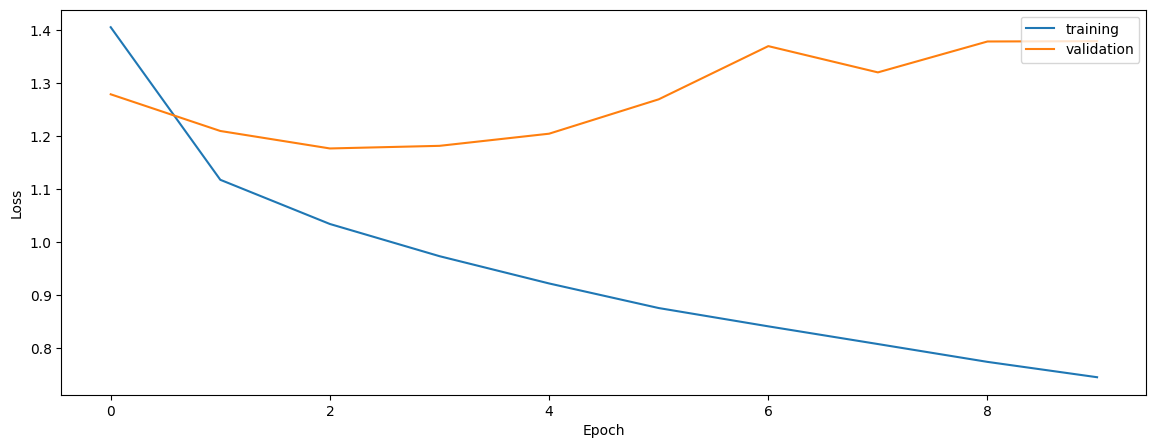

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6217690900649768
0.5453820353403142
0.5094058249083708


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.583474421680291
0.5616914120256283
0.5410381103612545


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.5959908016550457
0.5721563953352498
0.5642364075420153


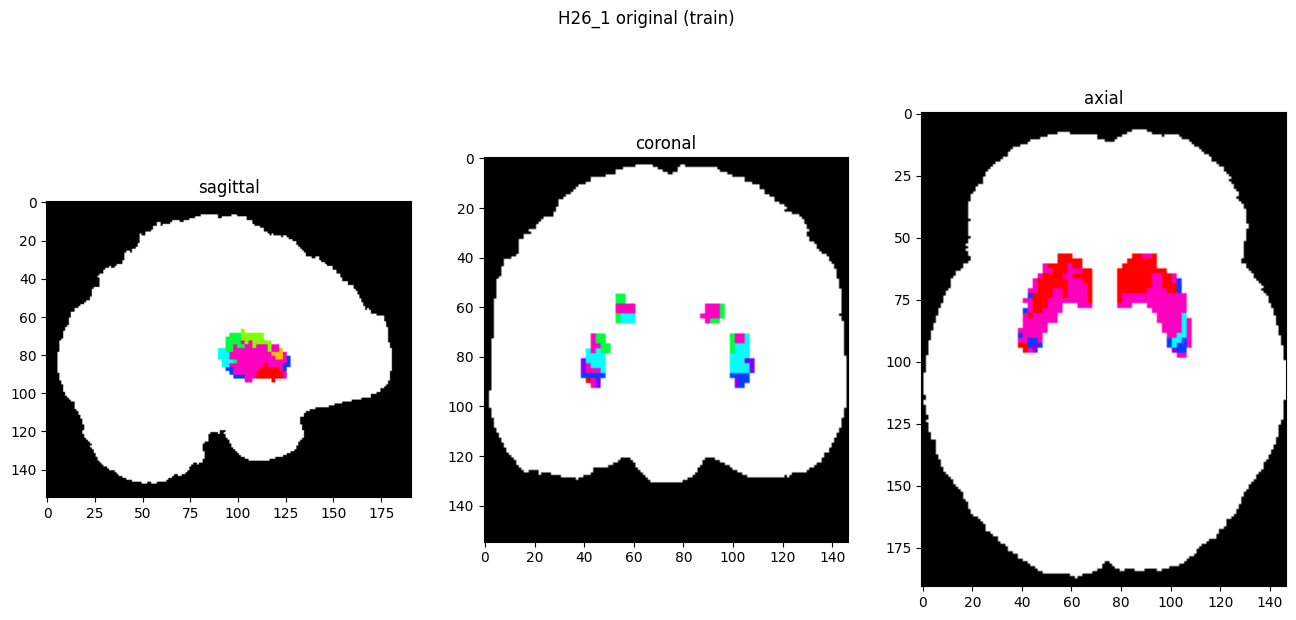

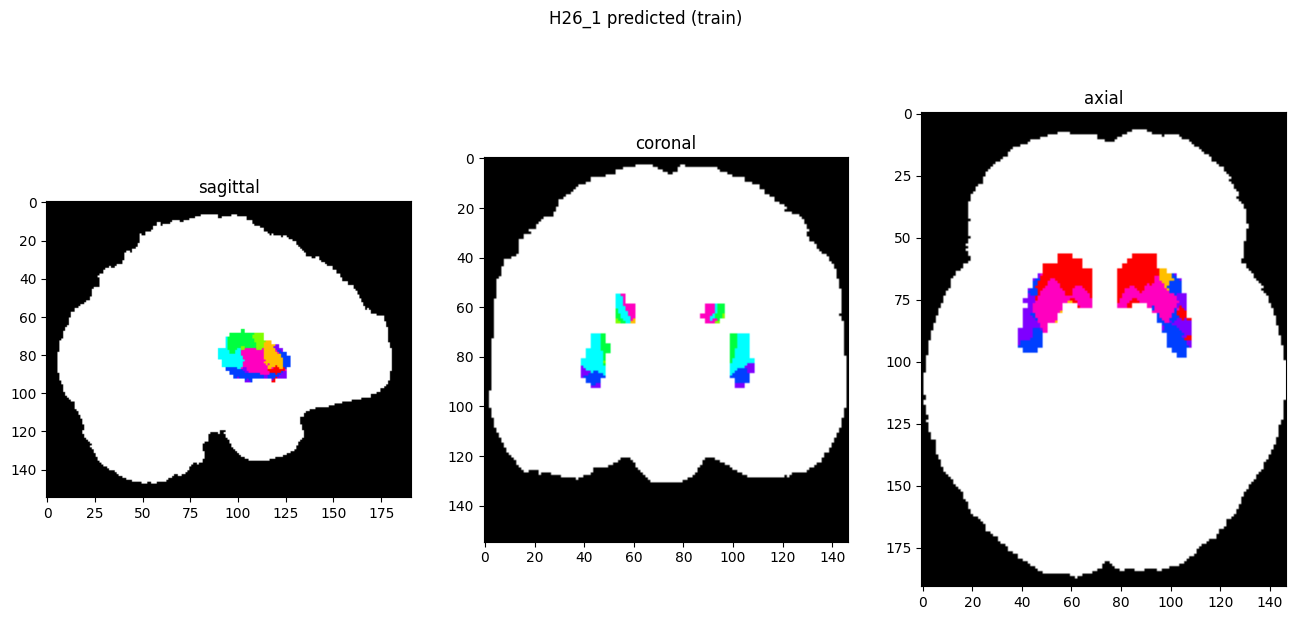

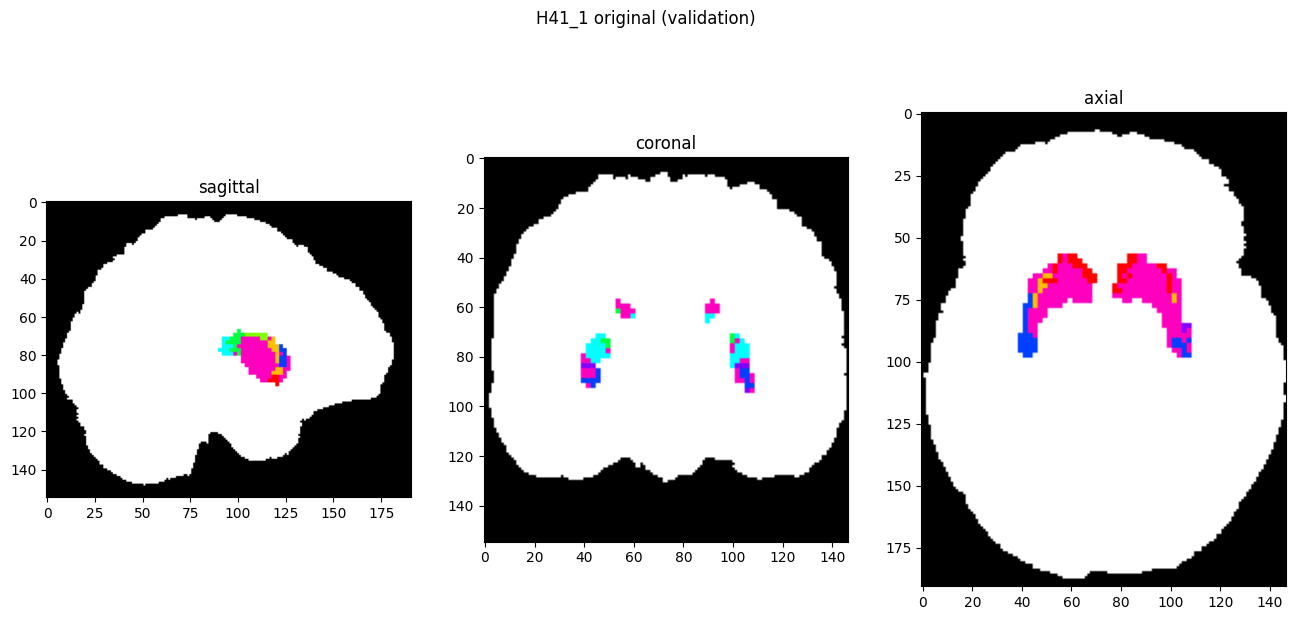

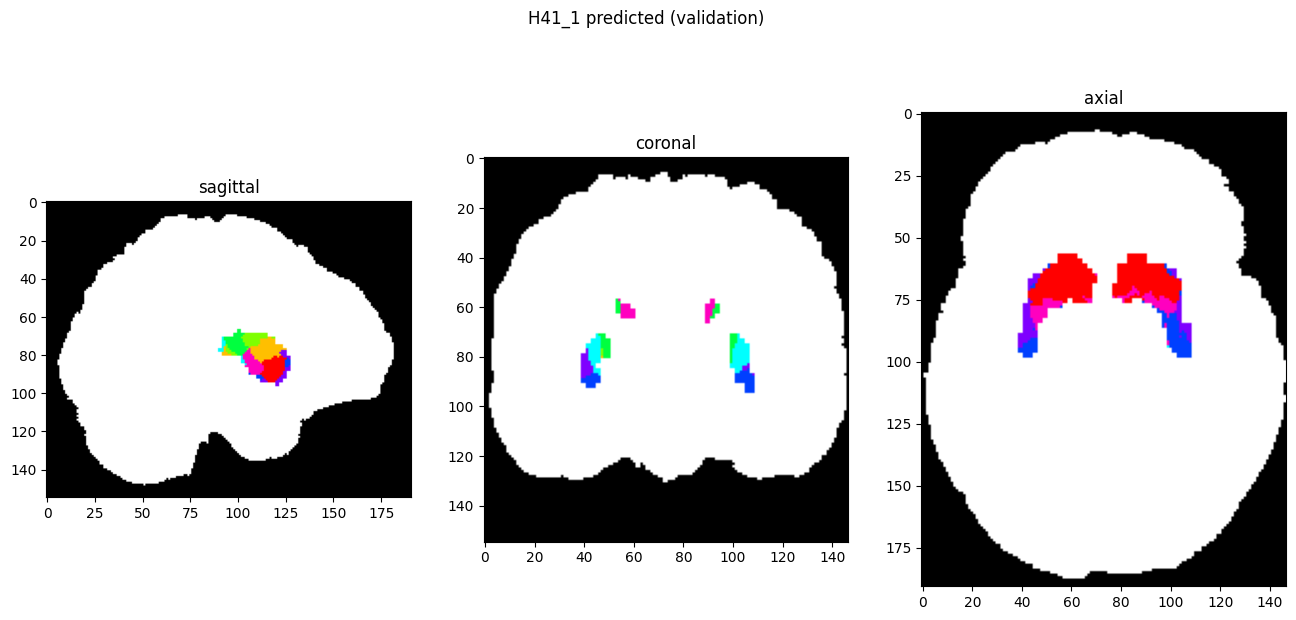

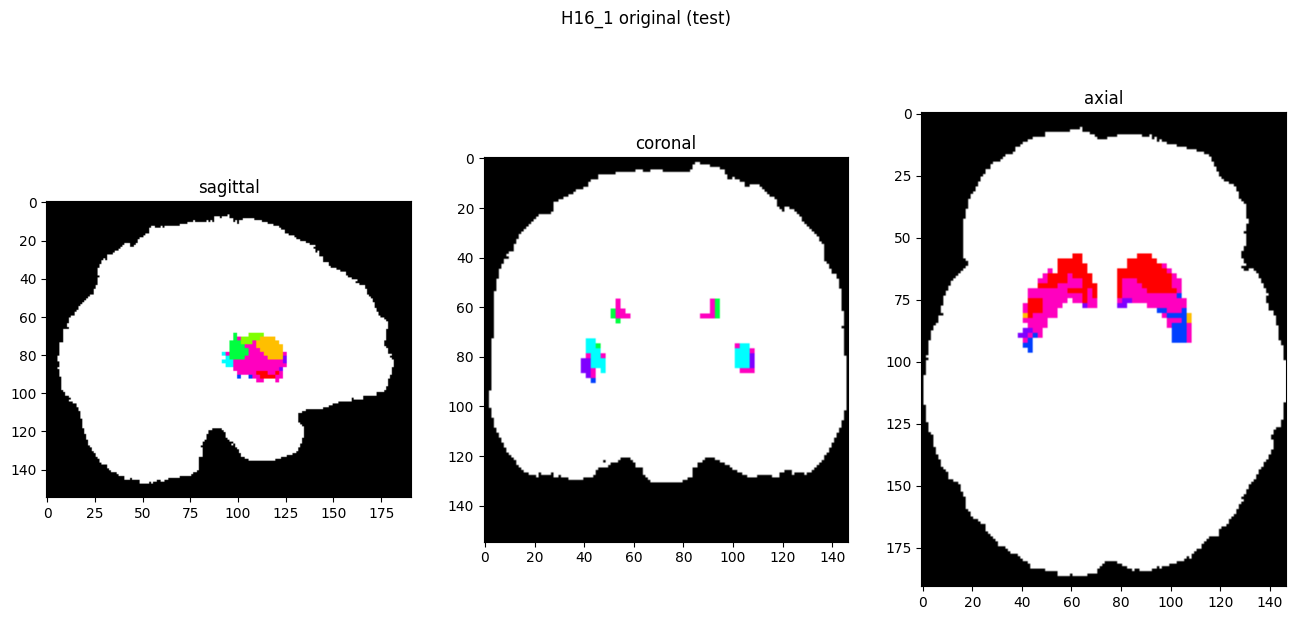

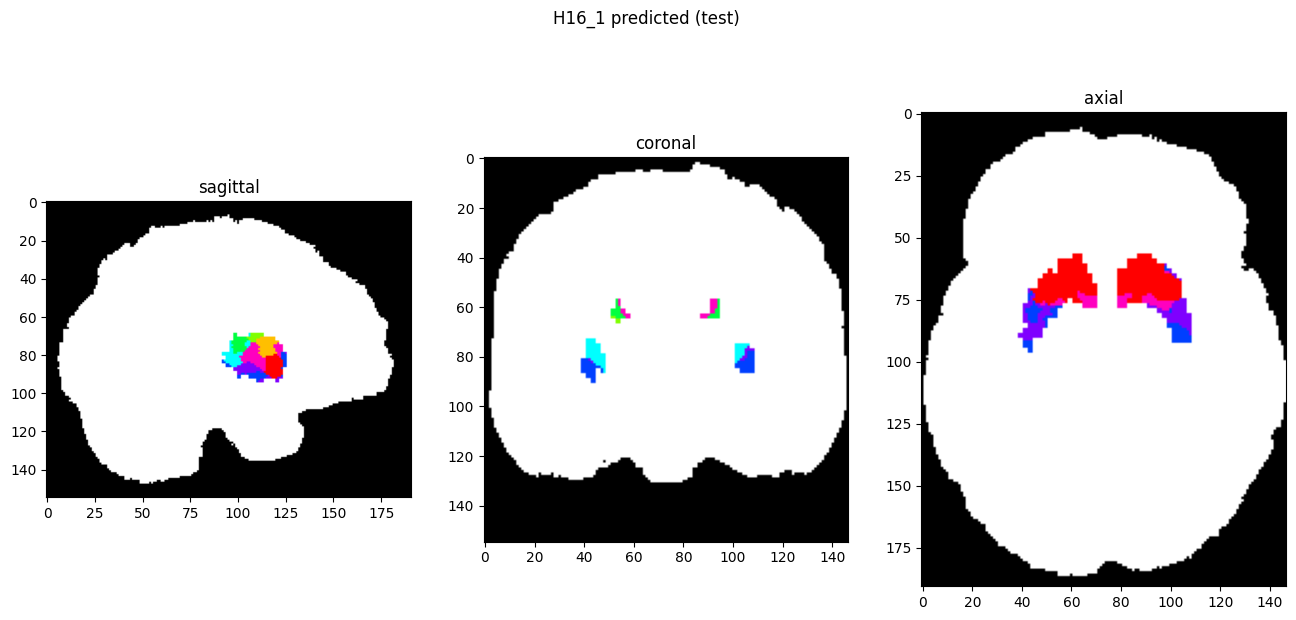

In [10]:
showResults(model, gen, threshold=0)